In [1]:
#=======================================
## DNN_cla_Glass-Identification
#=======================================

# Need compile Create_DNN_model.

#----------------------------------------
# Set random seed for reproducibility.

seed = 543
from numpy import random
random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

# Import classes and functions.

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#----------------------------------------
# Load the Glass-Identification dataset.

dataset = np.loadtxt("Glass-Identification-Data.txt", delimiter = ",")

print(type(dataset))

print(dataset.shape)

index = [3, 4, 7, 8]

X = dataset[:, index]
Y = dataset[:, 10]

print(X.shape)
print(Y.shape)

Y = np.array(Y, dtype = int)

print(np.unique(Y))


<class 'numpy.ndarray'>
(214, 11)
(214, 4)
(214,)
[1 2 3 5 6 7]


In [3]:
#----------------------------------------
# one-hot encoding of output variable.

Y_train = np.zeros((len(Y), 7), dtype = int)

for i in range(len(Y)):
	Y_train[i, Y[i] - 1] = 1

print(np.unique(Y_train))


[0 1]


In [4]:
#----------------------------------------
# Standardize the input data.

X_sample_mean = np.mean(X, axis = 0)
print(np.round(X_sample_mean, 4))

X_sample_std = np.std(X, axis = 0, ddof = 1)
print(np.round(X_sample_std, 4))

standardize = lambda x: (x - np.mean(x, axis = 0)) / np.std(x, axis = 0, ddof = 1)

X_train = standardize(X)

print(np.round(np.mean(X_train, axis = 0), 4))
print(np.round(np.std(X_train, axis = 0, ddof = 1), 4))


[2.6845 1.4449 8.957  0.175 ]
[1.4424 0.4993 1.4232 0.4972]
[-0. -0. -0. -0.]
[1. 1. 1. 1.]


In [5]:
#----------------------------------------
# Define 10-fold cross validation test index sets.

fold_num = 10

L = len(X_train)

quotient = L // fold_num
remainder = L % fold_num

fold_length = np.array([quotient]*fold_num)
if remainder > 0:
    fold_length[0:remainder] = fold_length[0:remainder] + 1

index_begin = np.zeros(fold_num, dtype = int)
index_begin[0] = 0

for j in range(1, fold_num):
    index_begin[j] = index_begin[j-1] + fold_length[j-1]

index = np.random.choice(np.arange(L), size = L, replace = False)


In [6]:
## Create DNN model

def create_DNN_model(nodes, drop, kernel, act):
  model = Sequential()
  # Build input_layer & first_hidden_layer
  if drop[0] > 0:
    model.add(Dropout(rate = drop[0], input_shape = (nodes[0], )))
    model.add(Dense(units = nodes[1], kernel_initializer = kernel[0], activation =act[0]))
    if drop[1] > 0:
      model.add(Dropout(rate = drop[1]))
  else:
    model.add(Dense(units = nodes[1], input_dim = nodes[0], kernel_initializer = kernel[0], activation =act[0]))
    if drop[1] > 0:
      model.add(Dropout(rate = drop[1]))
  # Build other_hidden_layer
  for i in range(2, len(nodes) - 1):
    model.add(Dense(units = nodes[i], kernel_initializer = kernel[i-1], activation =act[i-1]))
    if drop[i] > 0:
      model.add(Dropout(rate = drop[i]))
  # Build output_layer
  model.add(Dense(units = nodes[len(nodes)-1], kernel_initializer = kernel[len(kernel) - 1], activation = act[len(act) - 1]))
  return model


In [7]:
#----------------------------------------
# Create the DNN_model

input_dim = X.shape[1]

nodes = [input_dim, 5, 6, 6, 7]
	# first component: number of input nodes
	# last component: number of output nodes

drop = [0, 0.1, 0.1, 0.1]
	# len(dropout_rate) = len(node) - 1
	# first component: dropout rate for the input layer
	# other components: dropout rates for the hidden layers
	# Dropout rate is not used in the output layer.

#dropout_rate = [0]*(len(node)-1)
#dropout_rate = [0] + [0.2]*(len(node)-2)

kernel = ['uniform', 'uniform', 'uniform', 'uniform']

act = ['relu', 'relu', 'relu', 'softmax']


In [8]:
#----------------------------------------
# 10-fold cross validation

cv_cc = []
cv_acc = []

for k in range(fold_num):
    # Build the model.
    model = create_DNN_model(nodes, drop, kernel, act)
    # Compile the model.
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Select index sets.
    seq_index = range(index_begin[k], (index_begin[k] + fold_length[k]))
    test_index = index[seq_index]
    train_index = np.delete(index, seq_index)
    # Fit the model.
    history = model.fit(X_train[train_index], Y_train[train_index], validation_split = 0.2, epochs = 1000, batch_size = 20, verbose = 1)
    # Evaluate the model.
    scores = model.evaluate(X_train[test_index], Y_train[test_index], verbose = 1)
    print("%s: %.4f" % (model.metrics_names[0], scores[0]))
    print("%s: %.4f" % (model.metrics_names[1], scores[1]))
    cv_cc.append(scores[0])
    cv_acc.append(scores[1])


Train on 153 samples, validate on 39 samples
Epoch 1/1000
153/153 [==============================] - 1s 5ms/step - loss: 1.9434 - acc: 0.3595 - val_loss: 1.9402 - val_acc: 0.3333
Epoch 2/1000
153/153 [==============================] - 0s 265us/step - loss: 1.9366 - acc: 0.3725 - val_loss: 1.9342 - val_acc: 0.3333
Epoch 3/1000
153/153 [==============================] - 0s 207us/step - loss: 1.9299 - acc: 0.3725 - val_loss: 1.9281 - val_acc: 0.3333
Epoch 4/1000
153/153 [==============================] - 0s 155us/step - loss: 1.9229 - acc: 0.3725 - val_loss: 1.9216 - val_acc: 0.3333
Epoch 5/1000
153/153 [==============================] - 0s 238us/step - loss: 1.9155 - acc: 0.3725 - val_loss: 1.9148 - val_acc: 0.3333
Epoch 6/1000
153/153 [==============================] - 0s 227us/step - loss: 1.9078 - acc: 0.3725 - val_loss: 1.9075 - val_acc: 0.3333
Epoch 7/1000
153/153 [==============================] - 0s 181us/step - loss: 1.8993 - acc: 0.3725 - val_loss: 1.8996 - val_acc: 0.3333
Epoch

153/153 [==============================] - 0s 174us/step - loss: 1.2382 - acc: 0.4052 - val_loss: 1.3480 - val_acc: 0.4103
Epoch 61/1000
153/153 [==============================] - 0s 172us/step - loss: 1.2365 - acc: 0.3660 - val_loss: 1.3458 - val_acc: 0.4103
Epoch 62/1000
153/153 [==============================] - 0s 150us/step - loss: 1.2286 - acc: 0.4314 - val_loss: 1.3445 - val_acc: 0.4103
Epoch 63/1000
153/153 [==============================] - 0s 161us/step - loss: 1.2117 - acc: 0.3922 - val_loss: 1.3421 - val_acc: 0.4103
Epoch 64/1000
153/153 [==============================] - 0s 126us/step - loss: 1.2251 - acc: 0.4052 - val_loss: 1.3401 - val_acc: 0.4103
Epoch 65/1000
153/153 [==============================] - 0s 159us/step - loss: 1.2095 - acc: 0.5033 - val_loss: 1.3399 - val_acc: 0.4103
Epoch 66/1000
153/153 [==============================] - 0s 178us/step - loss: 1.2040 - acc: 0.4510 - val_loss: 1.3368 - val_acc: 0.4103
Epoch 67/1000
153/153 [==============================] 

Epoch 120/1000
153/153 [==============================] - 0s 125us/step - loss: 1.0759 - acc: 0.5556 - val_loss: 1.3698 - val_acc: 0.4872
Epoch 121/1000
153/153 [==============================] - 0s 144us/step - loss: 1.0929 - acc: 0.5033 - val_loss: 1.3710 - val_acc: 0.4872
Epoch 122/1000
153/153 [==============================] - 0s 164us/step - loss: 1.0619 - acc: 0.5556 - val_loss: 1.3729 - val_acc: 0.4872
Epoch 123/1000
153/153 [==============================] - 0s 173us/step - loss: 1.0669 - acc: 0.5163 - val_loss: 1.3764 - val_acc: 0.4872
Epoch 124/1000
153/153 [==============================] - 0s 151us/step - loss: 1.0519 - acc: 0.5098 - val_loss: 1.3773 - val_acc: 0.4872
Epoch 125/1000
153/153 [==============================] - 0s 160us/step - loss: 1.0556 - acc: 0.5294 - val_loss: 1.3772 - val_acc: 0.4872
Epoch 126/1000
153/153 [==============================] - 0s 181us/step - loss: 1.0278 - acc: 0.6144 - val_loss: 1.3793 - val_acc: 0.4872
Epoch 127/1000
153/153 [==========

153/153 [==============================] - 0s 254us/step - loss: 1.0258 - acc: 0.5359 - val_loss: 1.5237 - val_acc: 0.6154
Epoch 180/1000
153/153 [==============================] - 0s 227us/step - loss: 0.9743 - acc: 0.5752 - val_loss: 1.5235 - val_acc: 0.5641
Epoch 181/1000
153/153 [==============================] - 0s 266us/step - loss: 0.9615 - acc: 0.5948 - val_loss: 1.5240 - val_acc: 0.6154
Epoch 182/1000
153/153 [==============================] - 0s 219us/step - loss: 0.9747 - acc: 0.5948 - val_loss: 1.5249 - val_acc: 0.6154
Epoch 183/1000
153/153 [==============================] - 0s 249us/step - loss: 0.9751 - acc: 0.5752 - val_loss: 1.5264 - val_acc: 0.5385
Epoch 184/1000
153/153 [==============================] - 0s 235us/step - loss: 0.9984 - acc: 0.5621 - val_loss: 1.5284 - val_acc: 0.4872
Epoch 185/1000
153/153 [==============================] - 0s 290us/step - loss: 1.0035 - acc: 0.5752 - val_loss: 1.5278 - val_acc: 0.4872
Epoch 186/1000
153/153 [=========================

153/153 [==============================] - 0s 164us/step - loss: 0.9638 - acc: 0.5752 - val_loss: 1.5510 - val_acc: 0.6154
Epoch 239/1000
153/153 [==============================] - 0s 132us/step - loss: 0.9784 - acc: 0.5882 - val_loss: 1.5515 - val_acc: 0.6154
Epoch 240/1000
153/153 [==============================] - 0s 127us/step - loss: 0.9313 - acc: 0.5817 - val_loss: 1.5513 - val_acc: 0.6154
Epoch 241/1000
153/153 [==============================] - 0s 156us/step - loss: 0.9712 - acc: 0.5621 - val_loss: 1.5519 - val_acc: 0.6154
Epoch 242/1000
153/153 [==============================] - 0s 171us/step - loss: 0.9634 - acc: 0.5490 - val_loss: 1.5533 - val_acc: 0.6154
Epoch 243/1000
153/153 [==============================] - 0s 182us/step - loss: 0.9453 - acc: 0.6013 - val_loss: 1.5542 - val_acc: 0.6154
Epoch 244/1000
153/153 [==============================] - 0s 171us/step - loss: 0.9477 - acc: 0.6013 - val_loss: 1.5562 - val_acc: 0.5897
Epoch 245/1000
153/153 [=========================

153/153 [==============================] - 0s 277us/step - loss: 0.9449 - acc: 0.5948 - val_loss: 1.5824 - val_acc: 0.6154
Epoch 298/1000
153/153 [==============================] - 0s 163us/step - loss: 0.9395 - acc: 0.6209 - val_loss: 1.5806 - val_acc: 0.6154
Epoch 299/1000
153/153 [==============================] - 0s 175us/step - loss: 0.9617 - acc: 0.5621 - val_loss: 1.5809 - val_acc: 0.5641
Epoch 300/1000
153/153 [==============================] - 0s 151us/step - loss: 0.9510 - acc: 0.5490 - val_loss: 1.5846 - val_acc: 0.6154
Epoch 301/1000
153/153 [==============================] - 0s 187us/step - loss: 0.9195 - acc: 0.5882 - val_loss: 1.5865 - val_acc: 0.6154
Epoch 302/1000
153/153 [==============================] - 0s 205us/step - loss: 0.9473 - acc: 0.5948 - val_loss: 1.5858 - val_acc: 0.5897
Epoch 303/1000
153/153 [==============================] - 0s 172us/step - loss: 0.9312 - acc: 0.6013 - val_loss: 1.5802 - val_acc: 0.6154
Epoch 304/1000
153/153 [=========================

153/153 [==============================] - 0s 130us/step - loss: 0.8882 - acc: 0.6144 - val_loss: 1.6385 - val_acc: 0.6154
Epoch 357/1000
153/153 [==============================] - 0s 169us/step - loss: 0.9207 - acc: 0.6078 - val_loss: 1.6406 - val_acc: 0.6154
Epoch 358/1000
153/153 [==============================] - 0s 162us/step - loss: 0.9269 - acc: 0.6275 - val_loss: 1.6430 - val_acc: 0.6154
Epoch 359/1000
153/153 [==============================] - 0s 170us/step - loss: 0.9575 - acc: 0.5686 - val_loss: 1.6456 - val_acc: 0.6154
Epoch 360/1000
153/153 [==============================] - 0s 131us/step - loss: 0.8971 - acc: 0.6144 - val_loss: 1.6432 - val_acc: 0.6154
Epoch 361/1000
153/153 [==============================] - 0s 181us/step - loss: 0.9057 - acc: 0.6405 - val_loss: 1.6456 - val_acc: 0.6154
Epoch 362/1000
153/153 [==============================] - 0s 178us/step - loss: 0.9662 - acc: 0.5752 - val_loss: 1.6522 - val_acc: 0.6154
Epoch 363/1000
153/153 [=========================

153/153 [==============================] - 0s 130us/step - loss: 0.9241 - acc: 0.6013 - val_loss: 1.7128 - val_acc: 0.6154
Epoch 416/1000
153/153 [==============================] - 0s 214us/step - loss: 0.9239 - acc: 0.5686 - val_loss: 1.7166 - val_acc: 0.6154
Epoch 417/1000
153/153 [==============================] - 0s 180us/step - loss: 0.9635 - acc: 0.6078 - val_loss: 1.7192 - val_acc: 0.6154
Epoch 418/1000
153/153 [==============================] - 0s 207us/step - loss: 0.9284 - acc: 0.5621 - val_loss: 1.7199 - val_acc: 0.6154
Epoch 419/1000
153/153 [==============================] - 0s 176us/step - loss: 0.9230 - acc: 0.5948 - val_loss: 1.7209 - val_acc: 0.6154
Epoch 420/1000
153/153 [==============================] - 0s 218us/step - loss: 0.9176 - acc: 0.5948 - val_loss: 1.7194 - val_acc: 0.5897
Epoch 421/1000
153/153 [==============================] - 0s 183us/step - loss: 0.9533 - acc: 0.5359 - val_loss: 1.7190 - val_acc: 0.5897
Epoch 422/1000
153/153 [=========================

153/153 [==============================] - 0s 176us/step - loss: 0.9427 - acc: 0.5490 - val_loss: 1.8094 - val_acc: 0.5897
Epoch 475/1000
153/153 [==============================] - 0s 191us/step - loss: 0.9074 - acc: 0.6209 - val_loss: 1.8123 - val_acc: 0.5128
Epoch 476/1000
153/153 [==============================] - 0s 138us/step - loss: 0.9044 - acc: 0.5817 - val_loss: 1.8103 - val_acc: 0.4872
Epoch 477/1000
153/153 [==============================] - 0s 178us/step - loss: 0.8909 - acc: 0.5817 - val_loss: 1.8037 - val_acc: 0.5128
Epoch 478/1000
153/153 [==============================] - 0s 216us/step - loss: 0.8899 - acc: 0.6536 - val_loss: 1.7991 - val_acc: 0.6410
Epoch 479/1000
153/153 [==============================] - 0s 189us/step - loss: 0.9325 - acc: 0.5948 - val_loss: 1.8002 - val_acc: 0.5385
Epoch 480/1000
153/153 [==============================] - 0s 206us/step - loss: 0.9183 - acc: 0.5621 - val_loss: 1.7975 - val_acc: 0.6154
Epoch 481/1000
153/153 [=========================

153/153 [==============================] - 0s 235us/step - loss: 0.8825 - acc: 0.6144 - val_loss: 1.8085 - val_acc: 0.6154
Epoch 534/1000
153/153 [==============================] - 0s 232us/step - loss: 0.8811 - acc: 0.6275 - val_loss: 1.8049 - val_acc: 0.5641
Epoch 535/1000
153/153 [==============================] - 0s 191us/step - loss: 0.9250 - acc: 0.6209 - val_loss: 1.8028 - val_acc: 0.5641
Epoch 536/1000
153/153 [==============================] - 0s 300us/step - loss: 0.8907 - acc: 0.5817 - val_loss: 1.8006 - val_acc: 0.6154
Epoch 537/1000
153/153 [==============================] - 0s 172us/step - loss: 0.9088 - acc: 0.5752 - val_loss: 1.8030 - val_acc: 0.6154
Epoch 538/1000
153/153 [==============================] - 0s 227us/step - loss: 0.9029 - acc: 0.6013 - val_loss: 1.8061 - val_acc: 0.6154
Epoch 539/1000
153/153 [==============================] - 0s 161us/step - loss: 0.9042 - acc: 0.6144 - val_loss: 1.8143 - val_acc: 0.4872
Epoch 540/1000
153/153 [=========================

153/153 [==============================] - 0s 231us/step - loss: 0.8855 - acc: 0.6405 - val_loss: 1.8059 - val_acc: 0.5128
Epoch 593/1000
153/153 [==============================] - 0s 220us/step - loss: 0.9069 - acc: 0.6275 - val_loss: 1.8075 - val_acc: 0.5641
Epoch 594/1000
153/153 [==============================] - 0s 205us/step - loss: 0.9034 - acc: 0.6209 - val_loss: 1.8048 - val_acc: 0.6154
Epoch 595/1000
153/153 [==============================] - 0s 171us/step - loss: 0.8923 - acc: 0.6144 - val_loss: 1.8025 - val_acc: 0.6154
Epoch 596/1000
153/153 [==============================] - 0s 215us/step - loss: 0.8676 - acc: 0.6340 - val_loss: 1.8023 - val_acc: 0.6154
Epoch 597/1000
153/153 [==============================] - 0s 192us/step - loss: 0.9250 - acc: 0.5752 - val_loss: 1.8014 - val_acc: 0.6154
Epoch 598/1000
153/153 [==============================] - 0s 178us/step - loss: 0.9085 - acc: 0.6013 - val_loss: 1.8047 - val_acc: 0.6154
Epoch 599/1000
153/153 [=========================

153/153 [==============================] - 0s 148us/step - loss: 0.9182 - acc: 0.6078 - val_loss: 1.8069 - val_acc: 0.5128
Epoch 652/1000
153/153 [==============================] - 0s 234us/step - loss: 0.9431 - acc: 0.5948 - val_loss: 1.8038 - val_acc: 0.6154
Epoch 653/1000
153/153 [==============================] - 0s 204us/step - loss: 0.8917 - acc: 0.6405 - val_loss: 1.8061 - val_acc: 0.6154
Epoch 654/1000
153/153 [==============================] - 0s 199us/step - loss: 0.8830 - acc: 0.6144 - val_loss: 1.8164 - val_acc: 0.4872
Epoch 655/1000
153/153 [==============================] - 0s 352us/step - loss: 0.9051 - acc: 0.5948 - val_loss: 1.8197 - val_acc: 0.4872
Epoch 656/1000
153/153 [==============================] - 0s 189us/step - loss: 0.9193 - acc: 0.6144 - val_loss: 1.8159 - val_acc: 0.5128
Epoch 657/1000
153/153 [==============================] - 0s 189us/step - loss: 0.8858 - acc: 0.5621 - val_loss: 1.8169 - val_acc: 0.4872
Epoch 658/1000
153/153 [=========================

153/153 [==============================] - 0s 204us/step - loss: 0.9128 - acc: 0.6340 - val_loss: 1.8090 - val_acc: 0.6154
Epoch 711/1000
153/153 [==============================] - 0s 236us/step - loss: 0.8764 - acc: 0.6209 - val_loss: 1.8123 - val_acc: 0.6154
Epoch 712/1000
153/153 [==============================] - 0s 288us/step - loss: 0.8876 - acc: 0.6078 - val_loss: 1.8121 - val_acc: 0.6154
Epoch 713/1000
153/153 [==============================] - 0s 294us/step - loss: 0.8935 - acc: 0.6013 - val_loss: 1.8080 - val_acc: 0.6154
Epoch 714/1000
153/153 [==============================] - 0s 277us/step - loss: 0.9037 - acc: 0.6013 - val_loss: 1.8048 - val_acc: 0.6154
Epoch 715/1000
153/153 [==============================] - 0s 180us/step - loss: 0.8945 - acc: 0.6405 - val_loss: 1.8020 - val_acc: 0.6154
Epoch 716/1000
153/153 [==============================] - 0s 355us/step - loss: 0.9397 - acc: 0.5490 - val_loss: 1.8043 - val_acc: 0.5641
Epoch 717/1000
153/153 [=========================

153/153 [==============================] - 0s 189us/step - loss: 0.9208 - acc: 0.6209 - val_loss: 1.8206 - val_acc: 0.5128
Epoch 770/1000
153/153 [==============================] - 0s 170us/step - loss: 0.9180 - acc: 0.6340 - val_loss: 1.8208 - val_acc: 0.6154
Epoch 771/1000
153/153 [==============================] - 0s 215us/step - loss: 0.8745 - acc: 0.6144 - val_loss: 1.8236 - val_acc: 0.4872
Epoch 772/1000
153/153 [==============================] - 0s 217us/step - loss: 0.8809 - acc: 0.6340 - val_loss: 1.8210 - val_acc: 0.4872
Epoch 773/1000
153/153 [==============================] - 0s 233us/step - loss: 0.8964 - acc: 0.6078 - val_loss: 1.8160 - val_acc: 0.5128
Epoch 774/1000
153/153 [==============================] - 0s 178us/step - loss: 0.9050 - acc: 0.5621 - val_loss: 1.8165 - val_acc: 0.5897
Epoch 775/1000
153/153 [==============================] - 0s 224us/step - loss: 0.9133 - acc: 0.6078 - val_loss: 1.8192 - val_acc: 0.5641
Epoch 776/1000
153/153 [=========================

153/153 [==============================] - 0s 155us/step - loss: 0.9499 - acc: 0.5490 - val_loss: 1.8233 - val_acc: 0.4872
Epoch 829/1000
153/153 [==============================] - 0s 336us/step - loss: 0.8778 - acc: 0.6209 - val_loss: 1.8298 - val_acc: 0.4872
Epoch 830/1000
153/153 [==============================] - 0s 237us/step - loss: 0.8813 - acc: 0.6078 - val_loss: 1.8353 - val_acc: 0.4872
Epoch 831/1000
153/153 [==============================] - 0s 186us/step - loss: 0.9224 - acc: 0.5621 - val_loss: 1.8383 - val_acc: 0.4872
Epoch 832/1000
153/153 [==============================] - 0s 147us/step - loss: 0.9080 - acc: 0.6144 - val_loss: 1.8364 - val_acc: 0.6154
Epoch 833/1000
153/153 [==============================] - 0s 168us/step - loss: 0.8847 - acc: 0.6078 - val_loss: 1.8322 - val_acc: 0.4872
Epoch 834/1000
153/153 [==============================] - 0s 194us/step - loss: 0.8752 - acc: 0.6144 - val_loss: 1.8269 - val_acc: 0.4872
Epoch 835/1000
153/153 [=========================

153/153 [==============================] - 0s 238us/step - loss: 0.8643 - acc: 0.6340 - val_loss: 1.8317 - val_acc: 0.5128
Epoch 888/1000
153/153 [==============================] - 0s 208us/step - loss: 0.8844 - acc: 0.6144 - val_loss: 1.8210 - val_acc: 0.6154
Epoch 889/1000
153/153 [==============================] - 0s 222us/step - loss: 0.8810 - acc: 0.5556 - val_loss: 1.8235 - val_acc: 0.4872
Epoch 890/1000
153/153 [==============================] - 0s 205us/step - loss: 0.9200 - acc: 0.6275 - val_loss: 1.8259 - val_acc: 0.4872
Epoch 891/1000
153/153 [==============================] - 0s 248us/step - loss: 0.8702 - acc: 0.6471 - val_loss: 1.8304 - val_acc: 0.4872
Epoch 892/1000
153/153 [==============================] - 0s 204us/step - loss: 0.9213 - acc: 0.5882 - val_loss: 1.8223 - val_acc: 0.6154
Epoch 893/1000
153/153 [==============================] - 0s 208us/step - loss: 0.8768 - acc: 0.6013 - val_loss: 1.8222 - val_acc: 0.6154
Epoch 894/1000
153/153 [=========================

153/153 [==============================] - 0s 185us/step - loss: 0.9316 - acc: 0.5686 - val_loss: 1.8161 - val_acc: 0.5641
Epoch 947/1000
153/153 [==============================] - 0s 159us/step - loss: 0.8684 - acc: 0.6209 - val_loss: 1.8202 - val_acc: 0.5128
Epoch 948/1000
153/153 [==============================] - 0s 199us/step - loss: 0.9019 - acc: 0.6144 - val_loss: 1.8276 - val_acc: 0.5128
Epoch 949/1000
153/153 [==============================] - 0s 253us/step - loss: 0.8720 - acc: 0.6340 - val_loss: 1.8289 - val_acc: 0.6154
Epoch 950/1000
153/153 [==============================] - 0s 202us/step - loss: 0.9178 - acc: 0.6078 - val_loss: 1.8261 - val_acc: 0.6154
Epoch 951/1000
153/153 [==============================] - 0s 217us/step - loss: 0.8715 - acc: 0.6340 - val_loss: 1.8275 - val_acc: 0.6154
Epoch 952/1000
153/153 [==============================] - 0s 244us/step - loss: 0.8434 - acc: 0.6536 - val_loss: 1.8253 - val_acc: 0.5641
Epoch 953/1000
153/153 [=========================

153/153 [==============================] - 0s 379us/step - loss: 1.9263 - acc: 0.3464 - val_loss: 1.9228 - val_acc: 0.3333
Epoch 5/1000
153/153 [==============================] - 0s 233us/step - loss: 1.9203 - acc: 0.3464 - val_loss: 1.9164 - val_acc: 0.3333
Epoch 6/1000
153/153 [==============================] - 0s 268us/step - loss: 1.9135 - acc: 0.3464 - val_loss: 1.9098 - val_acc: 0.3333
Epoch 7/1000
153/153 [==============================] - 0s 171us/step - loss: 1.9065 - acc: 0.3464 - val_loss: 1.9027 - val_acc: 0.3333
Epoch 8/1000
153/153 [==============================] - 0s 215us/step - loss: 1.8997 - acc: 0.3464 - val_loss: 1.8949 - val_acc: 0.3333
Epoch 9/1000
153/153 [==============================] - 0s 165us/step - loss: 1.8917 - acc: 0.3464 - val_loss: 1.8868 - val_acc: 0.3333
Epoch 10/1000
153/153 [==============================] - 0s 248us/step - loss: 1.8829 - acc: 0.3464 - val_loss: 1.8779 - val_acc: 0.3333
Epoch 11/1000
153/153 [==============================] - 0s 

Epoch 64/1000
153/153 [==============================] - 0s 268us/step - loss: 1.1088 - acc: 0.5163 - val_loss: 1.1845 - val_acc: 0.4872
Epoch 65/1000
153/153 [==============================] - 0s 280us/step - loss: 1.1327 - acc: 0.4771 - val_loss: 1.1842 - val_acc: 0.4872
Epoch 66/1000
153/153 [==============================] - 0s 265us/step - loss: 1.1475 - acc: 0.4575 - val_loss: 1.1844 - val_acc: 0.4872
Epoch 67/1000
153/153 [==============================] - ETA: 0s - loss: 0.9386 - acc: 0.650 - 0s 257us/step - loss: 1.1643 - acc: 0.4967 - val_loss: 1.1845 - val_acc: 0.4872
Epoch 68/1000
153/153 [==============================] - 0s 220us/step - loss: 1.1117 - acc: 0.5163 - val_loss: 1.1828 - val_acc: 0.4872
Epoch 69/1000
153/153 [==============================] - 0s 216us/step - loss: 1.1006 - acc: 0.5033 - val_loss: 1.1830 - val_acc: 0.4872
Epoch 70/1000
153/153 [==============================] - 0s 213us/step - loss: 1.1003 - acc: 0.4967 - val_loss: 1.1831 - val_acc: 0.4872
Epo

153/153 [==============================] - 0s 275us/step - loss: 1.0414 - acc: 0.5294 - val_loss: 1.2002 - val_acc: 0.6154
Epoch 124/1000
153/153 [==============================] - 0s 233us/step - loss: 1.0387 - acc: 0.5229 - val_loss: 1.2006 - val_acc: 0.6154
Epoch 125/1000
153/153 [==============================] - 0s 316us/step - loss: 1.0583 - acc: 0.5359 - val_loss: 1.2078 - val_acc: 0.6154
Epoch 126/1000
153/153 [==============================] - 0s 185us/step - loss: 1.0385 - acc: 0.5033 - val_loss: 1.2128 - val_acc: 0.5641
Epoch 127/1000
153/153 [==============================] - 0s 188us/step - loss: 1.0423 - acc: 0.5294 - val_loss: 1.2142 - val_acc: 0.5641
Epoch 128/1000
153/153 [==============================] - 0s 209us/step - loss: 1.0562 - acc: 0.5359 - val_loss: 1.2139 - val_acc: 0.5897
Epoch 129/1000
153/153 [==============================] - 0s 152us/step - loss: 1.0474 - acc: 0.5294 - val_loss: 1.2111 - val_acc: 0.6410
Epoch 130/1000
153/153 [=========================

153/153 [==============================] - 0s 228us/step - loss: 1.0105 - acc: 0.5490 - val_loss: 1.2648 - val_acc: 0.6154
Epoch 183/1000
153/153 [==============================] - 0s 182us/step - loss: 1.0524 - acc: 0.5163 - val_loss: 1.2658 - val_acc: 0.5897
Epoch 184/1000
153/153 [==============================] - 0s 200us/step - loss: 0.9947 - acc: 0.5294 - val_loss: 1.2612 - val_acc: 0.5897
Epoch 185/1000
153/153 [==============================] - 0s 160us/step - loss: 0.9910 - acc: 0.5686 - val_loss: 1.2621 - val_acc: 0.5897
Epoch 186/1000
153/153 [==============================] - 0s 206us/step - loss: 1.0150 - acc: 0.5686 - val_loss: 1.2664 - val_acc: 0.5897
Epoch 187/1000
153/153 [==============================] - 0s 186us/step - loss: 1.0218 - acc: 0.5425 - val_loss: 1.2734 - val_acc: 0.6154
Epoch 188/1000
153/153 [==============================] - 0s 292us/step - loss: 0.9925 - acc: 0.5752 - val_loss: 1.2830 - val_acc: 0.6154
Epoch 189/1000
153/153 [=========================

Epoch 241/1000
153/153 [==============================] - 0s 175us/step - loss: 0.9801 - acc: 0.6013 - val_loss: 1.2918 - val_acc: 0.6154
Epoch 242/1000
153/153 [==============================] - 0s 226us/step - loss: 0.9852 - acc: 0.5686 - val_loss: 1.2953 - val_acc: 0.5897
Epoch 243/1000
153/153 [==============================] - 0s 202us/step - loss: 0.9645 - acc: 0.5948 - val_loss: 1.2985 - val_acc: 0.6154
Epoch 244/1000
153/153 [==============================] - 0s 262us/step - loss: 0.9686 - acc: 0.6144 - val_loss: 1.2959 - val_acc: 0.6154
Epoch 245/1000
153/153 [==============================] - 0s 229us/step - loss: 1.0804 - acc: 0.5359 - val_loss: 1.2942 - val_acc: 0.6154
Epoch 246/1000
153/153 [==============================] - 0s 181us/step - loss: 0.9583 - acc: 0.5621 - val_loss: 1.2934 - val_acc: 0.5897
Epoch 247/1000
153/153 [==============================] - 0s 311us/step - loss: 1.0085 - acc: 0.5752 - val_loss: 1.2969 - val_acc: 0.6154
Epoch 248/1000
153/153 [==========

153/153 [==============================] - 0s 172us/step - loss: 0.9678 - acc: 0.5490 - val_loss: 1.3262 - val_acc: 0.6154
Epoch 301/1000
153/153 [==============================] - 0s 194us/step - loss: 0.9417 - acc: 0.6078 - val_loss: 1.3232 - val_acc: 0.6154
Epoch 302/1000
153/153 [==============================] - 0s 194us/step - loss: 1.0304 - acc: 0.5294 - val_loss: 1.3181 - val_acc: 0.6154
Epoch 303/1000
153/153 [==============================] - 0s 150us/step - loss: 0.9796 - acc: 0.5490 - val_loss: 1.3180 - val_acc: 0.6154
Epoch 304/1000
153/153 [==============================] - 0s 192us/step - loss: 0.9279 - acc: 0.6209 - val_loss: 1.3196 - val_acc: 0.6154
Epoch 305/1000
153/153 [==============================] - 0s 192us/step - loss: 0.9899 - acc: 0.5425 - val_loss: 1.3243 - val_acc: 0.6154
Epoch 306/1000
153/153 [==============================] - 0s 181us/step - loss: 0.9907 - acc: 0.5882 - val_loss: 1.3284 - val_acc: 0.6154
Epoch 307/1000
153/153 [=========================

153/153 [==============================] - 0s 201us/step - loss: 0.9907 - acc: 0.6209 - val_loss: 1.3709 - val_acc: 0.6154
Epoch 360/1000
153/153 [==============================] - 0s 223us/step - loss: 1.0251 - acc: 0.5621 - val_loss: 1.3691 - val_acc: 0.6154
Epoch 361/1000
153/153 [==============================] - 0s 187us/step - loss: 0.9317 - acc: 0.5817 - val_loss: 1.3701 - val_acc: 0.6154
Epoch 362/1000
153/153 [==============================] - 0s 303us/step - loss: 0.9264 - acc: 0.5948 - val_loss: 1.3757 - val_acc: 0.6154
Epoch 363/1000
153/153 [==============================] - 0s 228us/step - loss: 0.9835 - acc: 0.5686 - val_loss: 1.3742 - val_acc: 0.6154
Epoch 364/1000
153/153 [==============================] - 0s 347us/step - loss: 0.9381 - acc: 0.5752 - val_loss: 1.3761 - val_acc: 0.6154
Epoch 365/1000
153/153 [==============================] - 0s 265us/step - loss: 0.9720 - acc: 0.5882 - val_loss: 1.3804 - val_acc: 0.6154
Epoch 366/1000
153/153 [=========================

Epoch 418/1000
153/153 [==============================] - 0s 227us/step - loss: 0.9773 - acc: 0.6209 - val_loss: 1.4025 - val_acc: 0.6154
Epoch 419/1000
153/153 [==============================] - 0s 261us/step - loss: 0.9315 - acc: 0.6078 - val_loss: 1.4006 - val_acc: 0.6154
Epoch 420/1000
153/153 [==============================] - 0s 269us/step - loss: 0.9309 - acc: 0.6209 - val_loss: 1.4024 - val_acc: 0.6154
Epoch 421/1000
153/153 [==============================] - 0s 235us/step - loss: 0.9483 - acc: 0.6078 - val_loss: 1.4017 - val_acc: 0.6154
Epoch 422/1000
153/153 [==============================] - 0s 217us/step - loss: 0.9387 - acc: 0.6013 - val_loss: 1.4045 - val_acc: 0.6154
Epoch 423/1000
153/153 [==============================] - 0s 279us/step - loss: 1.0527 - acc: 0.6013 - val_loss: 1.3975 - val_acc: 0.6154
Epoch 424/1000
153/153 [==============================] - 0s 231us/step - loss: 0.9886 - acc: 0.5948 - val_loss: 1.3859 - val_acc: 0.6154
Epoch 425/1000
153/153 [==========

153/153 [==============================] - 0s 358us/step - loss: 0.9414 - acc: 0.6209 - val_loss: 1.4172 - val_acc: 0.5897
Epoch 477/1000
153/153 [==============================] - 0s 199us/step - loss: 0.9304 - acc: 0.6078 - val_loss: 1.4180 - val_acc: 0.5897
Epoch 478/1000
153/153 [==============================] - 0s 217us/step - loss: 0.9537 - acc: 0.5817 - val_loss: 1.4135 - val_acc: 0.5897
Epoch 479/1000
153/153 [==============================] - 0s 210us/step - loss: 0.9291 - acc: 0.6144 - val_loss: 1.4176 - val_acc: 0.5897
Epoch 480/1000
153/153 [==============================] - 0s 201us/step - loss: 0.9709 - acc: 0.6078 - val_loss: 1.4201 - val_acc: 0.5897
Epoch 481/1000
153/153 [==============================] - 0s 336us/step - loss: 0.9375 - acc: 0.6275 - val_loss: 1.4229 - val_acc: 0.5897
Epoch 482/1000
153/153 [==============================] - 0s 236us/step - loss: 0.9302 - acc: 0.6209 - val_loss: 1.4226 - val_acc: 0.5897
Epoch 483/1000
153/153 [=========================

153/153 [==============================] - 0s 277us/step - loss: 0.9371 - acc: 0.6275 - val_loss: 1.4257 - val_acc: 0.5897
Epoch 536/1000
153/153 [==============================] - 0s 166us/step - loss: 0.8783 - acc: 0.6275 - val_loss: 1.4204 - val_acc: 0.5897
Epoch 537/1000
153/153 [==============================] - 0s 249us/step - loss: 0.9319 - acc: 0.6144 - val_loss: 1.4171 - val_acc: 0.5897
Epoch 538/1000
153/153 [==============================] - 0s 212us/step - loss: 0.9217 - acc: 0.6078 - val_loss: 1.4138 - val_acc: 0.5897
Epoch 539/1000
153/153 [==============================] - 0s 164us/step - loss: 0.9593 - acc: 0.6078 - val_loss: 1.4107 - val_acc: 0.5897
Epoch 540/1000
153/153 [==============================] - 0s 200us/step - loss: 0.8469 - acc: 0.6340 - val_loss: 1.4100 - val_acc: 0.5897
Epoch 541/1000
153/153 [==============================] - 0s 206us/step - loss: 0.9532 - acc: 0.6078 - val_loss: 1.4092 - val_acc: 0.5897
Epoch 542/1000
153/153 [=========================

153/153 [==============================] - 0s 247us/step - loss: 0.9222 - acc: 0.5817 - val_loss: 1.4378 - val_acc: 0.5897
Epoch 595/1000
153/153 [==============================] - 0s 193us/step - loss: 0.8867 - acc: 0.6078 - val_loss: 1.4347 - val_acc: 0.5897
Epoch 596/1000
153/153 [==============================] - 0s 161us/step - loss: 0.9300 - acc: 0.6209 - val_loss: 1.4364 - val_acc: 0.5897
Epoch 597/1000
153/153 [==============================] - 0s 171us/step - loss: 0.9511 - acc: 0.6209 - val_loss: 1.4437 - val_acc: 0.5897
Epoch 598/1000
153/153 [==============================] - 0s 246us/step - loss: 0.9121 - acc: 0.6340 - val_loss: 1.4396 - val_acc: 0.5897
Epoch 599/1000
153/153 [==============================] - 0s 202us/step - loss: 0.9504 - acc: 0.5948 - val_loss: 1.4215 - val_acc: 0.5897
Epoch 600/1000
153/153 [==============================] - 0s 257us/step - loss: 0.9564 - acc: 0.5948 - val_loss: 1.4061 - val_acc: 0.5897
Epoch 601/1000
153/153 [=========================

153/153 [==============================] - 0s 205us/step - loss: 0.9248 - acc: 0.5948 - val_loss: 1.4476 - val_acc: 0.5897
Epoch 654/1000
153/153 [==============================] - 0s 241us/step - loss: 0.8846 - acc: 0.6405 - val_loss: 1.4465 - val_acc: 0.5897
Epoch 655/1000
153/153 [==============================] - 0s 319us/step - loss: 0.9504 - acc: 0.6340 - val_loss: 1.4488 - val_acc: 0.5897
Epoch 656/1000
153/153 [==============================] - 0s 574us/step - loss: 0.9296 - acc: 0.5621 - val_loss: 1.4492 - val_acc: 0.5897
Epoch 657/1000
153/153 [==============================] - 0s 220us/step - loss: 0.9213 - acc: 0.6144 - val_loss: 1.4448 - val_acc: 0.5897
Epoch 658/1000
153/153 [==============================] - 0s 326us/step - loss: 0.9348 - acc: 0.5882 - val_loss: 1.4450 - val_acc: 0.5897
Epoch 659/1000
153/153 [==============================] - 0s 169us/step - loss: 0.9516 - acc: 0.5948 - val_loss: 1.4419 - val_acc: 0.5897
Epoch 660/1000
153/153 [=========================

153/153 [==============================] - 0s 127us/step - loss: 0.9137 - acc: 0.6144 - val_loss: 1.4681 - val_acc: 0.5897
Epoch 713/1000
153/153 [==============================] - 0s 139us/step - loss: 0.9059 - acc: 0.6275 - val_loss: 1.4711 - val_acc: 0.5897
Epoch 714/1000
153/153 [==============================] - 0s 106us/step - loss: 0.9165 - acc: 0.6275 - val_loss: 1.4736 - val_acc: 0.5897
Epoch 715/1000
153/153 [==============================] - 0s 155us/step - loss: 0.8759 - acc: 0.6209 - val_loss: 1.4777 - val_acc: 0.5897
Epoch 716/1000
153/153 [==============================] - 0s 157us/step - loss: 0.9001 - acc: 0.6340 - val_loss: 1.4829 - val_acc: 0.5897
Epoch 717/1000
153/153 [==============================] - 0s 180us/step - loss: 0.8796 - acc: 0.6275 - val_loss: 1.4857 - val_acc: 0.5897
Epoch 718/1000
153/153 [==============================] - 0s 153us/step - loss: 0.9053 - acc: 0.6275 - val_loss: 1.4807 - val_acc: 0.5897
Epoch 719/1000
153/153 [=========================

Epoch 771/1000
153/153 [==============================] - 0s 112us/step - loss: 0.9018 - acc: 0.6078 - val_loss: 1.4858 - val_acc: 0.5897
Epoch 772/1000
153/153 [==============================] - 0s 189us/step - loss: 0.8345 - acc: 0.6471 - val_loss: 1.4841 - val_acc: 0.5897
Epoch 773/1000
153/153 [==============================] - 0s 143us/step - loss: 0.9218 - acc: 0.6078 - val_loss: 1.4860 - val_acc: 0.5897
Epoch 774/1000
153/153 [==============================] - 0s 183us/step - loss: 0.9038 - acc: 0.6536 - val_loss: 1.4896 - val_acc: 0.6154
Epoch 775/1000
153/153 [==============================] - 0s 161us/step - loss: 0.9113 - acc: 0.6340 - val_loss: 1.4945 - val_acc: 0.6154
Epoch 776/1000
153/153 [==============================] - 0s 144us/step - loss: 0.9244 - acc: 0.6078 - val_loss: 1.4960 - val_acc: 0.6154
Epoch 777/1000
153/153 [==============================] - 0s 138us/step - loss: 0.8870 - acc: 0.6209 - val_loss: 1.4971 - val_acc: 0.5897
Epoch 778/1000
153/153 [==========

153/153 [==============================] - 0s 140us/step - loss: 0.9107 - acc: 0.6340 - val_loss: 1.4386 - val_acc: 0.5897
Epoch 831/1000
153/153 [==============================] - 0s 158us/step - loss: 0.8711 - acc: 0.6340 - val_loss: 1.4394 - val_acc: 0.5897
Epoch 832/1000
153/153 [==============================] - 0s 196us/step - loss: 0.8238 - acc: 0.6471 - val_loss: 1.4418 - val_acc: 0.6154
Epoch 833/1000
153/153 [==============================] - 0s 215us/step - loss: 0.9703 - acc: 0.5948 - val_loss: 1.4512 - val_acc: 0.6154
Epoch 834/1000
153/153 [==============================] - 0s 198us/step - loss: 0.9025 - acc: 0.6209 - val_loss: 1.4533 - val_acc: 0.6154
Epoch 835/1000
153/153 [==============================] - 0s 199us/step - loss: 0.8828 - acc: 0.6340 - val_loss: 1.4602 - val_acc: 0.6154
Epoch 836/1000
153/153 [==============================] - 0s 186us/step - loss: 0.9423 - acc: 0.6013 - val_loss: 1.4701 - val_acc: 0.6154
Epoch 837/1000
153/153 [=========================

153/153 [==============================] - 0s 155us/step - loss: 0.8864 - acc: 0.6209 - val_loss: 1.5194 - val_acc: 0.6154
Epoch 890/1000
153/153 [==============================] - 0s 176us/step - loss: 0.9374 - acc: 0.6144 - val_loss: 1.5210 - val_acc: 0.6154
Epoch 891/1000
153/153 [==============================] - 0s 130us/step - loss: 0.8899 - acc: 0.6667 - val_loss: 1.5199 - val_acc: 0.5897
Epoch 892/1000
153/153 [==============================] - 0s 162us/step - loss: 0.8699 - acc: 0.6405 - val_loss: 1.5259 - val_acc: 0.5897
Epoch 893/1000
153/153 [==============================] - 0s 135us/step - loss: 0.8826 - acc: 0.6405 - val_loss: 1.5234 - val_acc: 0.5897
Epoch 894/1000
153/153 [==============================] - 0s 176us/step - loss: 0.8807 - acc: 0.6144 - val_loss: 1.5145 - val_acc: 0.5897
Epoch 895/1000
153/153 [==============================] - 0s 184us/step - loss: 0.8493 - acc: 0.6536 - val_loss: 1.5097 - val_acc: 0.6154
Epoch 896/1000
153/153 [=========================

153/153 [==============================] - 0s 138us/step - loss: 0.9293 - acc: 0.6275 - val_loss: 1.5479 - val_acc: 0.5897
Epoch 949/1000
153/153 [==============================] - 0s 145us/step - loss: 0.8943 - acc: 0.6078 - val_loss: 1.5403 - val_acc: 0.5897
Epoch 950/1000
153/153 [==============================] - 0s 159us/step - loss: 0.8934 - acc: 0.6013 - val_loss: 1.5455 - val_acc: 0.5897
Epoch 951/1000
153/153 [==============================] - 0s 209us/step - loss: 0.8900 - acc: 0.6209 - val_loss: 1.5535 - val_acc: 0.6154
Epoch 952/1000
153/153 [==============================] - 0s 153us/step - loss: 0.9662 - acc: 0.5817 - val_loss: 1.5720 - val_acc: 0.6154
Epoch 953/1000
153/153 [==============================] - 0s 151us/step - loss: 0.8991 - acc: 0.6340 - val_loss: 1.5886 - val_acc: 0.6154
Epoch 954/1000
153/153 [==============================] - 0s 144us/step - loss: 0.9255 - acc: 0.6340 - val_loss: 1.5953 - val_acc: 0.6154
Epoch 955/1000
153/153 [=========================

153/153 [==============================] - 0s 200us/step - loss: 1.9111 - acc: 0.3333 - val_loss: 1.9080 - val_acc: 0.3333
Epoch 7/1000
153/153 [==============================] - 0s 162us/step - loss: 1.9033 - acc: 0.3268 - val_loss: 1.8997 - val_acc: 0.3333
Epoch 8/1000
153/153 [==============================] - 0s 174us/step - loss: 1.8946 - acc: 0.3203 - val_loss: 1.8905 - val_acc: 0.3333
Epoch 9/1000
153/153 [==============================] - 0s 167us/step - loss: 1.8832 - acc: 0.3268 - val_loss: 1.8797 - val_acc: 0.3333
Epoch 10/1000
153/153 [==============================] - 0s 141us/step - loss: 1.8719 - acc: 0.3464 - val_loss: 1.8664 - val_acc: 0.3333
Epoch 11/1000
153/153 [==============================] - 0s 175us/step - loss: 1.8572 - acc: 0.3203 - val_loss: 1.8509 - val_acc: 0.3333
Epoch 12/1000
153/153 [==============================] - 0s 144us/step - loss: 1.8370 - acc: 0.3333 - val_loss: 1.8317 - val_acc: 0.3333
Epoch 13/1000
153/153 [==============================] - 0

Epoch 66/1000
153/153 [==============================] - 0s 243us/step - loss: 1.0967 - acc: 0.4444 - val_loss: 1.2183 - val_acc: 0.4872
Epoch 67/1000
153/153 [==============================] - 0s 147us/step - loss: 1.0510 - acc: 0.5556 - val_loss: 1.2185 - val_acc: 0.4872
Epoch 68/1000
153/153 [==============================] - 0s 181us/step - loss: 1.0752 - acc: 0.5425 - val_loss: 1.2181 - val_acc: 0.4872
Epoch 69/1000
153/153 [==============================] - 0s 196us/step - loss: 1.0946 - acc: 0.5359 - val_loss: 1.2173 - val_acc: 0.4872
Epoch 70/1000
153/153 [==============================] - 0s 255us/step - loss: 1.0920 - acc: 0.5098 - val_loss: 1.2158 - val_acc: 0.4872
Epoch 71/1000
153/153 [==============================] - 0s 176us/step - loss: 1.0668 - acc: 0.5098 - val_loss: 1.2160 - val_acc: 0.4872
Epoch 72/1000
153/153 [==============================] - 0s 283us/step - loss: 1.0232 - acc: 0.4967 - val_loss: 1.2168 - val_acc: 0.4872
Epoch 73/1000
153/153 [==================

153/153 [==============================] - 0s 216us/step - loss: 0.9629 - acc: 0.5621 - val_loss: 1.2646 - val_acc: 0.6667
Epoch 126/1000
153/153 [==============================] - 0s 170us/step - loss: 0.9650 - acc: 0.5490 - val_loss: 1.2686 - val_acc: 0.6667
Epoch 127/1000
153/153 [==============================] - 0s 260us/step - loss: 1.0096 - acc: 0.5359 - val_loss: 1.2745 - val_acc: 0.6410
Epoch 128/1000
153/153 [==============================] - 0s 191us/step - loss: 1.0202 - acc: 0.5556 - val_loss: 1.2742 - val_acc: 0.6410
Epoch 129/1000
153/153 [==============================] - 0s 225us/step - loss: 0.9621 - acc: 0.5686 - val_loss: 1.2706 - val_acc: 0.6410
Epoch 130/1000
153/153 [==============================] - 0s 186us/step - loss: 0.9789 - acc: 0.5752 - val_loss: 1.2725 - val_acc: 0.6410
Epoch 131/1000
153/153 [==============================] - 0s 193us/step - loss: 0.9731 - acc: 0.6013 - val_loss: 1.2741 - val_acc: 0.6410
Epoch 132/1000
153/153 [=========================

153/153 [==============================] - 0s 193us/step - loss: 0.9671 - acc: 0.5490 - val_loss: 1.4096 - val_acc: 0.6410
Epoch 185/1000
153/153 [==============================] - 0s 210us/step - loss: 0.9571 - acc: 0.5556 - val_loss: 1.4139 - val_acc: 0.6410
Epoch 186/1000
153/153 [==============================] - 0s 196us/step - loss: 0.9772 - acc: 0.6144 - val_loss: 1.4198 - val_acc: 0.6410
Epoch 187/1000
153/153 [==============================] - 0s 250us/step - loss: 0.9496 - acc: 0.5817 - val_loss: 1.4184 - val_acc: 0.6410
Epoch 188/1000
153/153 [==============================] - 0s 221us/step - loss: 0.9185 - acc: 0.6471 - val_loss: 1.4205 - val_acc: 0.6410
Epoch 189/1000
153/153 [==============================] - 0s 218us/step - loss: 0.9533 - acc: 0.6078 - val_loss: 1.4247 - val_acc: 0.6410
Epoch 190/1000
153/153 [==============================] - 0s 168us/step - loss: 0.9768 - acc: 0.5948 - val_loss: 1.4312 - val_acc: 0.6410
Epoch 191/1000
153/153 [=========================

153/153 [==============================] - 0s 209us/step - loss: 0.9695 - acc: 0.6078 - val_loss: 1.5041 - val_acc: 0.6410
Epoch 244/1000
153/153 [==============================] - 0s 231us/step - loss: 0.9192 - acc: 0.5948 - val_loss: 1.4961 - val_acc: 0.6410
Epoch 245/1000
153/153 [==============================] - 0s 241us/step - loss: 0.9924 - acc: 0.5752 - val_loss: 1.4976 - val_acc: 0.6410
Epoch 246/1000
153/153 [==============================] - 0s 241us/step - loss: 0.9357 - acc: 0.6144 - val_loss: 1.5036 - val_acc: 0.6410
Epoch 247/1000
153/153 [==============================] - 0s 202us/step - loss: 0.9453 - acc: 0.6013 - val_loss: 1.5039 - val_acc: 0.6410
Epoch 248/1000
153/153 [==============================] - 0s 323us/step - loss: 0.9749 - acc: 0.6013 - val_loss: 1.5028 - val_acc: 0.6410
Epoch 249/1000
153/153 [==============================] - 0s 229us/step - loss: 0.9747 - acc: 0.5686 - val_loss: 1.5094 - val_acc: 0.6410
Epoch 250/1000
153/153 [=========================

153/153 [==============================] - 0s 178us/step - loss: 0.9409 - acc: 0.5817 - val_loss: 1.6052 - val_acc: 0.6154
Epoch 303/1000
153/153 [==============================] - 0s 235us/step - loss: 0.9114 - acc: 0.6340 - val_loss: 1.6037 - val_acc: 0.6154
Epoch 304/1000
153/153 [==============================] - 0s 200us/step - loss: 0.9334 - acc: 0.5752 - val_loss: 1.6051 - val_acc: 0.6154
Epoch 305/1000
153/153 [==============================] - 0s 238us/step - loss: 0.9527 - acc: 0.5817 - val_loss: 1.6089 - val_acc: 0.6154
Epoch 306/1000
153/153 [==============================] - 0s 196us/step - loss: 0.9964 - acc: 0.5556 - val_loss: 1.6115 - val_acc: 0.6154
Epoch 307/1000
153/153 [==============================] - 0s 209us/step - loss: 0.9360 - acc: 0.6144 - val_loss: 1.6184 - val_acc: 0.6154
Epoch 308/1000
153/153 [==============================] - 0s 257us/step - loss: 0.9639 - acc: 0.5621 - val_loss: 1.6250 - val_acc: 0.6154
Epoch 309/1000
153/153 [=========================

153/153 [==============================] - 0s 192us/step - loss: 0.9344 - acc: 0.6340 - val_loss: 1.7341 - val_acc: 0.6154
Epoch 362/1000
153/153 [==============================] - 0s 235us/step - loss: 0.9553 - acc: 0.5882 - val_loss: 1.7331 - val_acc: 0.6154
Epoch 363/1000
153/153 [==============================] - 0s 180us/step - loss: 0.9522 - acc: 0.5752 - val_loss: 1.7374 - val_acc: 0.6154
Epoch 364/1000
153/153 [==============================] - 0s 236us/step - loss: 0.9415 - acc: 0.6340 - val_loss: 1.7389 - val_acc: 0.6154
Epoch 365/1000
153/153 [==============================] - 0s 182us/step - loss: 0.9460 - acc: 0.6144 - val_loss: 1.7390 - val_acc: 0.6154
Epoch 366/1000
153/153 [==============================] - 0s 207us/step - loss: 0.9522 - acc: 0.6144 - val_loss: 1.7397 - val_acc: 0.6154
Epoch 367/1000
153/153 [==============================] - 0s 184us/step - loss: 0.9520 - acc: 0.6013 - val_loss: 1.7373 - val_acc: 0.6154
Epoch 368/1000
153/153 [=========================

153/153 [==============================] - 0s 233us/step - loss: 0.9494 - acc: 0.6013 - val_loss: 1.7357 - val_acc: 0.6154
Epoch 421/1000
153/153 [==============================] - 0s 148us/step - loss: 0.9515 - acc: 0.5817 - val_loss: 1.7341 - val_acc: 0.6154
Epoch 422/1000
153/153 [==============================] - 0s 234us/step - loss: 1.0258 - acc: 0.5490 - val_loss: 1.7346 - val_acc: 0.6154
Epoch 423/1000
153/153 [==============================] - 0s 227us/step - loss: 0.8985 - acc: 0.6601 - val_loss: 1.7349 - val_acc: 0.6154
Epoch 424/1000
153/153 [==============================] - 0s 248us/step - loss: 0.9913 - acc: 0.5882 - val_loss: 1.7367 - val_acc: 0.6154
Epoch 425/1000
153/153 [==============================] - 0s 250us/step - loss: 0.9623 - acc: 0.5948 - val_loss: 1.7345 - val_acc: 0.6154
Epoch 426/1000
153/153 [==============================] - 0s 252us/step - loss: 0.9724 - acc: 0.6209 - val_loss: 1.7331 - val_acc: 0.6154
Epoch 427/1000
153/153 [=========================

153/153 [==============================] - 0s 204us/step - loss: 0.9054 - acc: 0.6209 - val_loss: 1.7294 - val_acc: 0.6154
Epoch 480/1000
153/153 [==============================] - ETA: 0s - loss: 0.7954 - acc: 0.600 - 0s 207us/step - loss: 0.9804 - acc: 0.5490 - val_loss: 1.7325 - val_acc: 0.6154
Epoch 481/1000
153/153 [==============================] - 0s 191us/step - loss: 0.9686 - acc: 0.5817 - val_loss: 1.7325 - val_acc: 0.6154
Epoch 482/1000
153/153 [==============================] - ETA: 0s - loss: 1.1642 - acc: 0.450 - 0s 267us/step - loss: 0.8623 - acc: 0.6863 - val_loss: 1.7311 - val_acc: 0.6154
Epoch 483/1000
153/153 [==============================] - 0s 188us/step - loss: 0.9198 - acc: 0.6144 - val_loss: 1.7293 - val_acc: 0.6154
Epoch 484/1000
153/153 [==============================] - 0s 225us/step - loss: 0.9373 - acc: 0.6275 - val_loss: 1.7284 - val_acc: 0.6154
Epoch 485/1000
153/153 [==============================] - 0s 258us/step - loss: 0.9481 - acc: 0.5752 - val_loss

153/153 [==============================] - 0s 230us/step - loss: 0.9326 - acc: 0.5948 - val_loss: 1.7252 - val_acc: 0.6154
Epoch 538/1000
153/153 [==============================] - 0s 186us/step - loss: 0.9157 - acc: 0.6275 - val_loss: 1.7281 - val_acc: 0.6154
Epoch 539/1000
153/153 [==============================] - 0s 218us/step - loss: 0.9605 - acc: 0.5882 - val_loss: 1.7322 - val_acc: 0.6154
Epoch 540/1000
153/153 [==============================] - 0s 234us/step - loss: 0.9425 - acc: 0.6013 - val_loss: 1.7309 - val_acc: 0.6154
Epoch 541/1000
153/153 [==============================] - 0s 204us/step - loss: 0.9262 - acc: 0.6013 - val_loss: 1.7276 - val_acc: 0.6154
Epoch 542/1000
153/153 [==============================] - 0s 221us/step - loss: 0.9310 - acc: 0.6340 - val_loss: 1.7267 - val_acc: 0.6154
Epoch 543/1000
153/153 [==============================] - 0s 191us/step - loss: 0.8819 - acc: 0.6601 - val_loss: 1.7262 - val_acc: 0.6154
Epoch 544/1000
153/153 [=========================

153/153 [==============================] - 0s 222us/step - loss: 0.9093 - acc: 0.6144 - val_loss: 1.7244 - val_acc: 0.6154
Epoch 597/1000
153/153 [==============================] - 0s 225us/step - loss: 0.9310 - acc: 0.6340 - val_loss: 1.7225 - val_acc: 0.6154
Epoch 598/1000
153/153 [==============================] - 0s 204us/step - loss: 0.9553 - acc: 0.6078 - val_loss: 1.7244 - val_acc: 0.6154
Epoch 599/1000
153/153 [==============================] - 0s 179us/step - loss: 0.9264 - acc: 0.5882 - val_loss: 1.7272 - val_acc: 0.6410
Epoch 600/1000
153/153 [==============================] - 0s 221us/step - loss: 0.9648 - acc: 0.6144 - val_loss: 1.7208 - val_acc: 0.6154
Epoch 601/1000
153/153 [==============================] - 0s 231us/step - loss: 0.9195 - acc: 0.6013 - val_loss: 1.7206 - val_acc: 0.6154
Epoch 602/1000
153/153 [==============================] - 0s 218us/step - loss: 0.9464 - acc: 0.6209 - val_loss: 1.7226 - val_acc: 0.6154
Epoch 603/1000
153/153 [=========================

Epoch 655/1000
153/153 [==============================] - 0s 213us/step - loss: 0.9092 - acc: 0.6209 - val_loss: 1.7268 - val_acc: 0.6154
Epoch 656/1000
153/153 [==============================] - 0s 164us/step - loss: 0.9669 - acc: 0.6275 - val_loss: 1.7248 - val_acc: 0.6154
Epoch 657/1000
153/153 [==============================] - 0s 205us/step - loss: 0.8944 - acc: 0.6601 - val_loss: 1.7196 - val_acc: 0.6154
Epoch 658/1000
153/153 [==============================] - 0s 193us/step - loss: 0.8785 - acc: 0.6275 - val_loss: 1.7197 - val_acc: 0.6154
Epoch 659/1000
153/153 [==============================] - 0s 218us/step - loss: 0.9106 - acc: 0.6471 - val_loss: 1.7181 - val_acc: 0.6154
Epoch 660/1000
153/153 [==============================] - 0s 175us/step - loss: 0.9065 - acc: 0.6275 - val_loss: 1.7161 - val_acc: 0.6154
Epoch 661/1000
153/153 [==============================] - 0s 294us/step - loss: 0.9233 - acc: 0.6275 - val_loss: 1.7153 - val_acc: 0.6154
Epoch 662/1000
153/153 [==========

153/153 [==============================] - 0s 193us/step - loss: 0.8904 - acc: 0.6536 - val_loss: 1.7236 - val_acc: 0.6410
Epoch 715/1000
153/153 [==============================] - 0s 191us/step - loss: 0.9544 - acc: 0.5817 - val_loss: 1.7196 - val_acc: 0.6154
Epoch 716/1000
153/153 [==============================] - 0s 163us/step - loss: 0.8844 - acc: 0.6732 - val_loss: 1.7192 - val_acc: 0.6154
Epoch 717/1000
153/153 [==============================] - 0s 166us/step - loss: 0.9011 - acc: 0.6275 - val_loss: 1.7215 - val_acc: 0.6154
Epoch 718/1000
153/153 [==============================] - 0s 229us/step - loss: 0.9086 - acc: 0.6078 - val_loss: 1.7211 - val_acc: 0.6154
Epoch 719/1000
153/153 [==============================] - 0s 153us/step - loss: 0.9333 - acc: 0.5817 - val_loss: 1.7209 - val_acc: 0.6154
Epoch 720/1000
153/153 [==============================] - 0s 158us/step - loss: 0.9329 - acc: 0.6275 - val_loss: 1.7228 - val_acc: 0.6154
Epoch 721/1000
153/153 [=========================

153/153 [==============================] - 0s 239us/step - loss: 0.8965 - acc: 0.6340 - val_loss: 1.7174 - val_acc: 0.6154
Epoch 774/1000
153/153 [==============================] - 0s 230us/step - loss: 0.9404 - acc: 0.6144 - val_loss: 1.7185 - val_acc: 0.6154
Epoch 775/1000
153/153 [==============================] - 0s 193us/step - loss: 0.9208 - acc: 0.5817 - val_loss: 1.7193 - val_acc: 0.6154
Epoch 776/1000
153/153 [==============================] - 0s 308us/step - loss: 0.9260 - acc: 0.6144 - val_loss: 1.7174 - val_acc: 0.6154
Epoch 777/1000
153/153 [==============================] - 0s 207us/step - loss: 0.9206 - acc: 0.6209 - val_loss: 1.7125 - val_acc: 0.6154
Epoch 778/1000
153/153 [==============================] - 0s 258us/step - loss: 0.8759 - acc: 0.6536 - val_loss: 1.7117 - val_acc: 0.6154
Epoch 779/1000
153/153 [==============================] - 0s 246us/step - loss: 0.9154 - acc: 0.5817 - val_loss: 1.7148 - val_acc: 0.6154
Epoch 780/1000
153/153 [=========================

153/153 [==============================] - 0s 231us/step - loss: 0.9295 - acc: 0.6144 - val_loss: 1.7145 - val_acc: 0.6410
Epoch 833/1000
153/153 [==============================] - 0s 194us/step - loss: 0.8845 - acc: 0.6405 - val_loss: 1.7160 - val_acc: 0.6410
Epoch 834/1000
153/153 [==============================] - 0s 227us/step - loss: 0.8835 - acc: 0.6797 - val_loss: 1.7243 - val_acc: 0.6154
Epoch 835/1000
153/153 [==============================] - 0s 219us/step - loss: 0.9354 - acc: 0.6601 - val_loss: 1.7225 - val_acc: 0.6410
Epoch 836/1000
153/153 [==============================] - 0s 219us/step - loss: 0.8908 - acc: 0.6471 - val_loss: 1.7218 - val_acc: 0.6410
Epoch 837/1000
153/153 [==============================] - 0s 257us/step - loss: 0.9213 - acc: 0.6601 - val_loss: 1.7214 - val_acc: 0.6410
Epoch 838/1000
153/153 [==============================] - 0s 182us/step - loss: 0.9049 - acc: 0.6144 - val_loss: 1.7238 - val_acc: 0.6154
Epoch 839/1000
153/153 [=========================

153/153 [==============================] - 0s 196us/step - loss: 0.9125 - acc: 0.6471 - val_loss: 1.7222 - val_acc: 0.5897
Epoch 892/1000
153/153 [==============================] - 0s 247us/step - loss: 0.9144 - acc: 0.6340 - val_loss: 1.7194 - val_acc: 0.6154
Epoch 893/1000
153/153 [==============================] - 0s 196us/step - loss: 0.8717 - acc: 0.6405 - val_loss: 1.7159 - val_acc: 0.6154
Epoch 894/1000
153/153 [==============================] - 0s 274us/step - loss: 0.8893 - acc: 0.6405 - val_loss: 1.7163 - val_acc: 0.6154
Epoch 895/1000
153/153 [==============================] - 0s 214us/step - loss: 0.8798 - acc: 0.6471 - val_loss: 1.7187 - val_acc: 0.6154
Epoch 896/1000
153/153 [==============================] - 0s 196us/step - loss: 0.9817 - acc: 0.6536 - val_loss: 1.7240 - val_acc: 0.5897
Epoch 897/1000
153/153 [==============================] - 0s 168us/step - loss: 0.9245 - acc: 0.6013 - val_loss: 1.7288 - val_acc: 0.5897
Epoch 898/1000
153/153 [=========================

153/153 [==============================] - 0s 191us/step - loss: 0.8889 - acc: 0.6601 - val_loss: 1.7194 - val_acc: 0.6154
Epoch 951/1000
153/153 [==============================] - 0s 212us/step - loss: 0.9774 - acc: 0.6144 - val_loss: 1.7208 - val_acc: 0.6154
Epoch 952/1000
153/153 [==============================] - 0s 228us/step - loss: 0.8796 - acc: 0.6797 - val_loss: 1.7201 - val_acc: 0.6154
Epoch 953/1000
153/153 [==============================] - 0s 202us/step - loss: 0.9057 - acc: 0.6340 - val_loss: 1.7231 - val_acc: 0.6154
Epoch 954/1000
153/153 [==============================] - 0s 164us/step - loss: 0.8959 - acc: 0.6405 - val_loss: 1.7228 - val_acc: 0.6154
Epoch 955/1000
153/153 [==============================] - 0s 259us/step - loss: 0.8988 - acc: 0.6471 - val_loss: 1.7238 - val_acc: 0.6154
Epoch 956/1000
153/153 [==============================] - 0s 219us/step - loss: 0.8773 - acc: 0.6667 - val_loss: 1.7247 - val_acc: 0.5897
Epoch 957/1000
153/153 [=========================

Epoch 9/1000
153/153 [==============================] - 0s 215us/step - loss: 1.8896 - acc: 0.3333 - val_loss: 1.8850 - val_acc: 0.3333
Epoch 10/1000
153/153 [==============================] - 0s 250us/step - loss: 1.8804 - acc: 0.3007 - val_loss: 1.8760 - val_acc: 0.3333
Epoch 11/1000
153/153 [==============================] - 0s 221us/step - loss: 1.8704 - acc: 0.3464 - val_loss: 1.8661 - val_acc: 0.3333
Epoch 12/1000
153/153 [==============================] - 0s 193us/step - loss: 1.8601 - acc: 0.3268 - val_loss: 1.8553 - val_acc: 0.3333
Epoch 13/1000
153/153 [==============================] - 0s 181us/step - loss: 1.8502 - acc: 0.3072 - val_loss: 1.8436 - val_acc: 0.3333
Epoch 14/1000
153/153 [==============================] - 0s 186us/step - loss: 1.8356 - acc: 0.3268 - val_loss: 1.8309 - val_acc: 0.3333
Epoch 15/1000
153/153 [==============================] - 0s 225us/step - loss: 1.8230 - acc: 0.3137 - val_loss: 1.8165 - val_acc: 0.3333
Epoch 16/1000
153/153 [===================

Epoch 69/1000
153/153 [==============================] - 0s 171us/step - loss: 1.1406 - acc: 0.4902 - val_loss: 1.1690 - val_acc: 0.5128
Epoch 70/1000
153/153 [==============================] - 0s 189us/step - loss: 1.1300 - acc: 0.5229 - val_loss: 1.1688 - val_acc: 0.5128
Epoch 71/1000
153/153 [==============================] - 0s 216us/step - loss: 1.1238 - acc: 0.4641 - val_loss: 1.1684 - val_acc: 0.5128
Epoch 72/1000
153/153 [==============================] - 0s 235us/step - loss: 1.0975 - acc: 0.5098 - val_loss: 1.1679 - val_acc: 0.5128
Epoch 73/1000
153/153 [==============================] - 0s 237us/step - loss: 1.1284 - acc: 0.4575 - val_loss: 1.1682 - val_acc: 0.5128
Epoch 74/1000
153/153 [==============================] - 0s 265us/step - loss: 1.0766 - acc: 0.5621 - val_loss: 1.1681 - val_acc: 0.5128
Epoch 75/1000
153/153 [==============================] - 0s 237us/step - loss: 1.0997 - acc: 0.4837 - val_loss: 1.1675 - val_acc: 0.5128
Epoch 76/1000
153/153 [==================

153/153 [==============================] - 0s 207us/step - loss: 1.0285 - acc: 0.5556 - val_loss: 1.1900 - val_acc: 0.5128
Epoch 129/1000
153/153 [==============================] - 0s 209us/step - loss: 1.0251 - acc: 0.5229 - val_loss: 1.1939 - val_acc: 0.4872
Epoch 130/1000
153/153 [==============================] - 0s 225us/step - loss: 1.0501 - acc: 0.5556 - val_loss: 1.1967 - val_acc: 0.4872
Epoch 131/1000
153/153 [==============================] - 0s 144us/step - loss: 1.0278 - acc: 0.5948 - val_loss: 1.1982 - val_acc: 0.4872
Epoch 132/1000
153/153 [==============================] - 0s 230us/step - loss: 0.9999 - acc: 0.5556 - val_loss: 1.1937 - val_acc: 0.4872
Epoch 133/1000
153/153 [==============================] - 0s 180us/step - loss: 1.0099 - acc: 0.5425 - val_loss: 1.1824 - val_acc: 0.5128
Epoch 134/1000
153/153 [==============================] - 0s 209us/step - loss: 1.0112 - acc: 0.5490 - val_loss: 1.1798 - val_acc: 0.5128
Epoch 135/1000
153/153 [=========================

153/153 [==============================] - 0s 239us/step - loss: 1.0513 - acc: 0.5033 - val_loss: 1.1972 - val_acc: 0.6410
Epoch 188/1000
153/153 [==============================] - 0s 233us/step - loss: 1.0167 - acc: 0.5686 - val_loss: 1.1923 - val_acc: 0.6410
Epoch 189/1000
153/153 [==============================] - 0s 222us/step - loss: 1.0169 - acc: 0.5556 - val_loss: 1.1906 - val_acc: 0.6410
Epoch 190/1000
153/153 [==============================] - 0s 230us/step - loss: 0.9963 - acc: 0.5686 - val_loss: 1.1901 - val_acc: 0.6410
Epoch 191/1000
153/153 [==============================] - 0s 221us/step - loss: 0.9991 - acc: 0.6013 - val_loss: 1.1874 - val_acc: 0.6410
Epoch 192/1000
153/153 [==============================] - 0s 179us/step - loss: 1.0254 - acc: 0.5686 - val_loss: 1.1857 - val_acc: 0.6410
Epoch 193/1000
153/153 [==============================] - 0s 211us/step - loss: 0.9802 - acc: 0.6078 - val_loss: 1.1847 - val_acc: 0.6410
Epoch 194/1000
153/153 [=========================

153/153 [==============================] - 0s 232us/step - loss: 1.0066 - acc: 0.5948 - val_loss: 1.2221 - val_acc: 0.6667
Epoch 247/1000
153/153 [==============================] - 0s 209us/step - loss: 0.9889 - acc: 0.6013 - val_loss: 1.2213 - val_acc: 0.6923
Epoch 248/1000
153/153 [==============================] - 0s 193us/step - loss: 1.0280 - acc: 0.5621 - val_loss: 1.2190 - val_acc: 0.6923
Epoch 249/1000
153/153 [==============================] - 0s 199us/step - loss: 0.9625 - acc: 0.5948 - val_loss: 1.2226 - val_acc: 0.6923
Epoch 250/1000
153/153 [==============================] - 0s 186us/step - loss: 0.9722 - acc: 0.5948 - val_loss: 1.2255 - val_acc: 0.6923
Epoch 251/1000
153/153 [==============================] - 0s 253us/step - loss: 1.0269 - acc: 0.5686 - val_loss: 1.2314 - val_acc: 0.6667
Epoch 252/1000
153/153 [==============================] - 0s 221us/step - loss: 0.9775 - acc: 0.5752 - val_loss: 1.2341 - val_acc: 0.6667
Epoch 253/1000
153/153 [=========================

153/153 [==============================] - 0s 192us/step - loss: 0.9110 - acc: 0.6471 - val_loss: 1.2255 - val_acc: 0.6923
Epoch 306/1000
153/153 [==============================] - 0s 220us/step - loss: 0.9844 - acc: 0.5882 - val_loss: 1.2321 - val_acc: 0.6923
Epoch 307/1000
153/153 [==============================] - 0s 187us/step - loss: 0.9958 - acc: 0.5490 - val_loss: 1.2349 - val_acc: 0.6923
Epoch 308/1000
153/153 [==============================] - 0s 215us/step - loss: 0.9465 - acc: 0.6013 - val_loss: 1.2395 - val_acc: 0.6923
Epoch 309/1000
153/153 [==============================] - 0s 222us/step - loss: 0.9666 - acc: 0.6144 - val_loss: 1.2389 - val_acc: 0.6923
Epoch 310/1000
153/153 [==============================] - 0s 230us/step - loss: 0.9713 - acc: 0.6013 - val_loss: 1.2321 - val_acc: 0.6923
Epoch 311/1000
153/153 [==============================] - 0s 247us/step - loss: 0.9924 - acc: 0.5490 - val_loss: 1.2277 - val_acc: 0.6923
Epoch 312/1000
153/153 [=========================

153/153 [==============================] - 0s 231us/step - loss: 0.9942 - acc: 0.5752 - val_loss: 1.2378 - val_acc: 0.7179
Epoch 365/1000
153/153 [==============================] - 0s 162us/step - loss: 0.9525 - acc: 0.6013 - val_loss: 1.2388 - val_acc: 0.7179
Epoch 366/1000
153/153 [==============================] - 0s 165us/step - loss: 0.9236 - acc: 0.6275 - val_loss: 1.2388 - val_acc: 0.7179
Epoch 367/1000
153/153 [==============================] - 0s 180us/step - loss: 0.9734 - acc: 0.5948 - val_loss: 1.2434 - val_acc: 0.7179
Epoch 368/1000
153/153 [==============================] - 0s 170us/step - loss: 0.9787 - acc: 0.5752 - val_loss: 1.2412 - val_acc: 0.7179
Epoch 369/1000
153/153 [==============================] - 0s 174us/step - loss: 0.9315 - acc: 0.6144 - val_loss: 1.2448 - val_acc: 0.7179
Epoch 370/1000
153/153 [==============================] - 0s 199us/step - loss: 0.9353 - acc: 0.6275 - val_loss: 1.2509 - val_acc: 0.7179
Epoch 371/1000
153/153 [=========================

153/153 [==============================] - 0s 168us/step - loss: 0.9279 - acc: 0.6340 - val_loss: 1.2589 - val_acc: 0.7179
Epoch 424/1000
153/153 [==============================] - 0s 158us/step - loss: 0.8923 - acc: 0.6275 - val_loss: 1.2572 - val_acc: 0.7179
Epoch 425/1000
153/153 [==============================] - 0s 159us/step - loss: 0.9168 - acc: 0.6209 - val_loss: 1.2508 - val_acc: 0.7179
Epoch 426/1000
153/153 [==============================] - 0s 162us/step - loss: 0.8801 - acc: 0.6144 - val_loss: 1.2562 - val_acc: 0.7179
Epoch 427/1000
153/153 [==============================] - 0s 178us/step - loss: 0.9458 - acc: 0.6078 - val_loss: 1.2657 - val_acc: 0.7179
Epoch 428/1000
153/153 [==============================] - 0s 137us/step - loss: 0.9396 - acc: 0.6078 - val_loss: 1.2719 - val_acc: 0.7179
Epoch 429/1000
153/153 [==============================] - 0s 167us/step - loss: 0.9812 - acc: 0.6078 - val_loss: 1.2785 - val_acc: 0.7179
Epoch 430/1000
153/153 [=========================

153/153 [==============================] - 0s 142us/step - loss: 0.9628 - acc: 0.5817 - val_loss: 1.3031 - val_acc: 0.7179
Epoch 483/1000
153/153 [==============================] - 0s 171us/step - loss: 0.9448 - acc: 0.5882 - val_loss: 1.3075 - val_acc: 0.7179
Epoch 484/1000
153/153 [==============================] - 0s 157us/step - loss: 0.9420 - acc: 0.5882 - val_loss: 1.3021 - val_acc: 0.7179
Epoch 485/1000
153/153 [==============================] - 0s 149us/step - loss: 0.9127 - acc: 0.6144 - val_loss: 1.3071 - val_acc: 0.7179
Epoch 486/1000
153/153 [==============================] - 0s 195us/step - loss: 0.9306 - acc: 0.6144 - val_loss: 1.3128 - val_acc: 0.7179
Epoch 487/1000
153/153 [==============================] - 0s 162us/step - loss: 0.9241 - acc: 0.6013 - val_loss: 1.3170 - val_acc: 0.7179
Epoch 488/1000
153/153 [==============================] - 0s 216us/step - loss: 0.9160 - acc: 0.6078 - val_loss: 1.3111 - val_acc: 0.7179
Epoch 489/1000
153/153 [=========================

153/153 [==============================] - 0s 152us/step - loss: 0.9383 - acc: 0.6144 - val_loss: 1.2791 - val_acc: 0.7179
Epoch 542/1000
153/153 [==============================] - 0s 118us/step - loss: 0.9684 - acc: 0.5817 - val_loss: 1.2818 - val_acc: 0.7179
Epoch 543/1000
153/153 [==============================] - 0s 148us/step - loss: 0.9543 - acc: 0.5882 - val_loss: 1.2809 - val_acc: 0.7179
Epoch 544/1000
153/153 [==============================] - 0s 169us/step - loss: 0.9141 - acc: 0.5948 - val_loss: 1.2808 - val_acc: 0.7179
Epoch 545/1000
153/153 [==============================] - 0s 178us/step - loss: 0.9247 - acc: 0.6275 - val_loss: 1.2822 - val_acc: 0.7179
Epoch 546/1000
153/153 [==============================] - 0s 172us/step - loss: 0.9641 - acc: 0.5817 - val_loss: 1.2909 - val_acc: 0.7179
Epoch 547/1000
153/153 [==============================] - 0s 152us/step - loss: 0.9635 - acc: 0.6078 - val_loss: 1.2954 - val_acc: 0.7179
Epoch 548/1000
153/153 [=========================

153/153 [==============================] - 0s 158us/step - loss: 0.9627 - acc: 0.5817 - val_loss: 1.2898 - val_acc: 0.7179
Epoch 601/1000
153/153 [==============================] - 0s 185us/step - loss: 0.8994 - acc: 0.6078 - val_loss: 1.2877 - val_acc: 0.7179
Epoch 602/1000
153/153 [==============================] - 0s 198us/step - loss: 0.9663 - acc: 0.5817 - val_loss: 1.2921 - val_acc: 0.7179
Epoch 603/1000
153/153 [==============================] - 0s 137us/step - loss: 0.9183 - acc: 0.6209 - val_loss: 1.2963 - val_acc: 0.7179
Epoch 604/1000
153/153 [==============================] - 0s 166us/step - loss: 0.9121 - acc: 0.6275 - val_loss: 1.2968 - val_acc: 0.7179
Epoch 605/1000
153/153 [==============================] - 0s 191us/step - loss: 0.9303 - acc: 0.6013 - val_loss: 1.2911 - val_acc: 0.7179
Epoch 606/1000
153/153 [==============================] - 0s 160us/step - loss: 0.9207 - acc: 0.6471 - val_loss: 1.2876 - val_acc: 0.7179
Epoch 607/1000
153/153 [=========================

153/153 [==============================] - 0s 138us/step - loss: 0.9024 - acc: 0.6340 - val_loss: 1.2848 - val_acc: 0.7179
Epoch 660/1000
153/153 [==============================] - 0s 137us/step - loss: 0.9297 - acc: 0.5948 - val_loss: 1.2889 - val_acc: 0.7179
Epoch 661/1000
153/153 [==============================] - 0s 156us/step - loss: 0.8659 - acc: 0.6471 - val_loss: 1.2964 - val_acc: 0.6923
Epoch 662/1000
153/153 [==============================] - 0s 139us/step - loss: 0.9681 - acc: 0.5817 - val_loss: 1.2844 - val_acc: 0.7179
Epoch 663/1000
153/153 [==============================] - 0s 168us/step - loss: 0.9041 - acc: 0.6144 - val_loss: 1.2837 - val_acc: 0.7179
Epoch 664/1000
153/153 [==============================] - 0s 180us/step - loss: 0.9096 - acc: 0.6144 - val_loss: 1.2864 - val_acc: 0.7179
Epoch 665/1000
153/153 [==============================] - 0s 189us/step - loss: 0.9316 - acc: 0.6275 - val_loss: 1.2884 - val_acc: 0.7179
Epoch 666/1000
153/153 [=========================

153/153 [==============================] - 0s 171us/step - loss: 0.8506 - acc: 0.6340 - val_loss: 1.2855 - val_acc: 0.7179
Epoch 719/1000
153/153 [==============================] - 0s 128us/step - loss: 0.9123 - acc: 0.6601 - val_loss: 1.2917 - val_acc: 0.7179
Epoch 720/1000
153/153 [==============================] - 0s 205us/step - loss: 0.9423 - acc: 0.5882 - val_loss: 1.2980 - val_acc: 0.7179
Epoch 721/1000
153/153 [==============================] - 0s 150us/step - loss: 0.8666 - acc: 0.6209 - val_loss: 1.2921 - val_acc: 0.7179
Epoch 722/1000
153/153 [==============================] - 0s 152us/step - loss: 0.9002 - acc: 0.6275 - val_loss: 1.2929 - val_acc: 0.7179
Epoch 723/1000
153/153 [==============================] - 0s 156us/step - loss: 0.8808 - acc: 0.6275 - val_loss: 1.2931 - val_acc: 0.7179
Epoch 724/1000
153/153 [==============================] - 0s 212us/step - loss: 0.9155 - acc: 0.6275 - val_loss: 1.2890 - val_acc: 0.7179
Epoch 725/1000
153/153 [=========================

153/153 [==============================] - 0s 152us/step - loss: 0.9027 - acc: 0.6144 - val_loss: 1.3154 - val_acc: 0.7179
Epoch 778/1000
153/153 [==============================] - 0s 169us/step - loss: 0.9048 - acc: 0.6209 - val_loss: 1.3210 - val_acc: 0.7179
Epoch 779/1000
153/153 [==============================] - 0s 168us/step - loss: 0.9537 - acc: 0.6013 - val_loss: 1.3184 - val_acc: 0.7179
Epoch 780/1000
153/153 [==============================] - 0s 102us/step - loss: 0.8830 - acc: 0.6078 - val_loss: 1.3147 - val_acc: 0.7179
Epoch 781/1000
153/153 [==============================] - 0s 162us/step - loss: 0.8851 - acc: 0.6144 - val_loss: 1.3077 - val_acc: 0.7179
Epoch 782/1000
153/153 [==============================] - 0s 172us/step - loss: 0.8723 - acc: 0.6536 - val_loss: 1.3074 - val_acc: 0.7179
Epoch 783/1000
153/153 [==============================] - 0s 182us/step - loss: 0.8984 - acc: 0.6340 - val_loss: 1.3100 - val_acc: 0.7179
Epoch 784/1000
153/153 [=========================

153/153 [==============================] - 0s 139us/step - loss: 0.9003 - acc: 0.6601 - val_loss: 1.3302 - val_acc: 0.7179
Epoch 837/1000
153/153 [==============================] - 0s 179us/step - loss: 0.8933 - acc: 0.6209 - val_loss: 1.3272 - val_acc: 0.7179
Epoch 838/1000
153/153 [==============================] - 0s 155us/step - loss: 0.9475 - acc: 0.5882 - val_loss: 1.3397 - val_acc: 0.7179
Epoch 839/1000
153/153 [==============================] - 0s 179us/step - loss: 0.9318 - acc: 0.5948 - val_loss: 1.3560 - val_acc: 0.7179
Epoch 840/1000
153/153 [==============================] - 0s 149us/step - loss: 0.8605 - acc: 0.6275 - val_loss: 1.3508 - val_acc: 0.7179
Epoch 841/1000
153/153 [==============================] - 0s 195us/step - loss: 0.8863 - acc: 0.6144 - val_loss: 1.3484 - val_acc: 0.7179
Epoch 842/1000
153/153 [==============================] - 0s 161us/step - loss: 0.8901 - acc: 0.6209 - val_loss: 1.3567 - val_acc: 0.7179
Epoch 843/1000
153/153 [=========================

153/153 [==============================] - 0s 190us/step - loss: 0.9037 - acc: 0.6144 - val_loss: 1.3254 - val_acc: 0.7179
Epoch 896/1000
153/153 [==============================] - 0s 213us/step - loss: 0.8977 - acc: 0.6209 - val_loss: 1.3253 - val_acc: 0.7179
Epoch 897/1000
153/153 [==============================] - 0s 236us/step - loss: 0.8869 - acc: 0.6340 - val_loss: 1.3277 - val_acc: 0.7179
Epoch 898/1000
153/153 [==============================] - 0s 229us/step - loss: 0.8490 - acc: 0.6536 - val_loss: 1.3369 - val_acc: 0.7179
Epoch 899/1000
153/153 [==============================] - 0s 249us/step - loss: 0.9140 - acc: 0.5948 - val_loss: 1.3442 - val_acc: 0.7179
Epoch 900/1000
153/153 [==============================] - 0s 212us/step - loss: 0.9043 - acc: 0.6209 - val_loss: 1.3533 - val_acc: 0.7179
Epoch 901/1000
153/153 [==============================] - 0s 253us/step - loss: 0.8580 - acc: 0.6601 - val_loss: 1.3392 - val_acc: 0.7179
Epoch 902/1000
153/153 [=========================

153/153 [==============================] - 0s 239us/step - loss: 0.9387 - acc: 0.5882 - val_loss: 1.3404 - val_acc: 0.7179
Epoch 955/1000
153/153 [==============================] - 0s 178us/step - loss: 0.9176 - acc: 0.6209 - val_loss: 1.3389 - val_acc: 0.7179
Epoch 956/1000
153/153 [==============================] - 0s 254us/step - loss: 0.8994 - acc: 0.6471 - val_loss: 1.3465 - val_acc: 0.7179
Epoch 957/1000
153/153 [==============================] - 0s 188us/step - loss: 0.8992 - acc: 0.6078 - val_loss: 1.3471 - val_acc: 0.7179
Epoch 958/1000
153/153 [==============================] - 0s 193us/step - loss: 0.9404 - acc: 0.6078 - val_loss: 1.3483 - val_acc: 0.7179
Epoch 959/1000
153/153 [==============================] - 0s 204us/step - loss: 0.8875 - acc: 0.6144 - val_loss: 1.3483 - val_acc: 0.7179
Epoch 960/1000
153/153 [==============================] - 0s 246us/step - loss: 0.8880 - acc: 0.6275 - val_loss: 1.3524 - val_acc: 0.7179
Epoch 961/1000
153/153 [=========================

Epoch 13/1000
154/154 [==============================] - 0s 163us/step - loss: 1.8275 - acc: 0.3636 - val_loss: 1.8192 - val_acc: 0.3333
Epoch 14/1000
154/154 [==============================] - 0s 191us/step - loss: 1.8119 - acc: 0.3636 - val_loss: 1.8009 - val_acc: 0.3333
Epoch 15/1000
154/154 [==============================] - 0s 218us/step - loss: 1.7899 - acc: 0.3636 - val_loss: 1.7790 - val_acc: 0.3333
Epoch 16/1000
154/154 [==============================] - 0s 220us/step - loss: 1.7690 - acc: 0.3636 - val_loss: 1.7547 - val_acc: 0.3333
Epoch 17/1000
154/154 [==============================] - 0s 249us/step - loss: 1.7415 - acc: 0.3636 - val_loss: 1.7268 - val_acc: 0.3333
Epoch 18/1000
154/154 [==============================] - 0s 213us/step - loss: 1.7161 - acc: 0.3636 - val_loss: 1.6965 - val_acc: 0.3333
Epoch 19/1000
154/154 [==============================] - 0s 267us/step - loss: 1.6834 - acc: 0.3636 - val_loss: 1.6643 - val_acc: 0.3333
Epoch 20/1000
154/154 [==================

Epoch 73/1000
154/154 [==============================] - 0s 236us/step - loss: 1.2441 - acc: 0.5065 - val_loss: 1.3635 - val_acc: 0.3590
Epoch 74/1000
154/154 [==============================] - 0s 295us/step - loss: 1.2426 - acc: 0.4351 - val_loss: 1.3653 - val_acc: 0.3846
Epoch 75/1000
154/154 [==============================] - 0s 261us/step - loss: 1.2472 - acc: 0.4351 - val_loss: 1.3671 - val_acc: 0.3846
Epoch 76/1000
154/154 [==============================] - 0s 238us/step - loss: 1.2509 - acc: 0.4156 - val_loss: 1.3681 - val_acc: 0.3846
Epoch 77/1000
154/154 [==============================] - 0s 206us/step - loss: 1.2471 - acc: 0.3896 - val_loss: 1.3677 - val_acc: 0.3846
Epoch 78/1000
154/154 [==============================] - 0s 275us/step - loss: 1.2386 - acc: 0.4675 - val_loss: 1.3691 - val_acc: 0.3846
Epoch 79/1000
154/154 [==============================] - 0s 257us/step - loss: 1.2587 - acc: 0.4805 - val_loss: 1.3681 - val_acc: 0.3590
Epoch 80/1000
154/154 [==================

154/154 [==============================] - 0s 237us/step - loss: 1.2029 - acc: 0.4610 - val_loss: 1.3955 - val_acc: 0.2308
Epoch 133/1000
154/154 [==============================] - 0s 207us/step - loss: 1.1875 - acc: 0.5130 - val_loss: 1.3928 - val_acc: 0.3590
Epoch 134/1000
154/154 [==============================] - 0s 228us/step - loss: 1.1922 - acc: 0.5065 - val_loss: 1.3917 - val_acc: 0.3846
Epoch 135/1000
154/154 [==============================] - 0s 249us/step - loss: 1.1715 - acc: 0.4870 - val_loss: 1.3911 - val_acc: 0.3590
Epoch 136/1000
154/154 [==============================] - 0s 231us/step - loss: 1.1888 - acc: 0.4221 - val_loss: 1.3913 - val_acc: 0.3590
Epoch 137/1000
154/154 [==============================] - 0s 259us/step - loss: 1.1725 - acc: 0.5195 - val_loss: 1.3924 - val_acc: 0.3590
Epoch 138/1000
154/154 [==============================] - 0s 157us/step - loss: 1.1939 - acc: 0.4481 - val_loss: 1.3927 - val_acc: 0.3333
Epoch 139/1000
154/154 [=========================

154/154 [==============================] - 0s 254us/step - loss: 1.1278 - acc: 0.4870 - val_loss: 1.4550 - val_acc: 0.3590
Epoch 192/1000
154/154 [==============================] - 0s 212us/step - loss: 1.1388 - acc: 0.4610 - val_loss: 1.4580 - val_acc: 0.3590
Epoch 193/1000
154/154 [==============================] - 0s 206us/step - loss: 1.1226 - acc: 0.4870 - val_loss: 1.4607 - val_acc: 0.3077
Epoch 194/1000
154/154 [==============================] - 0s 270us/step - loss: 1.1364 - acc: 0.4545 - val_loss: 1.4625 - val_acc: 0.2564
Epoch 195/1000
154/154 [==============================] - 0s 197us/step - loss: 1.1217 - acc: 0.4481 - val_loss: 1.4633 - val_acc: 0.3077
Epoch 196/1000
154/154 [==============================] - 0s 226us/step - loss: 1.1230 - acc: 0.4351 - val_loss: 1.4648 - val_acc: 0.3590
Epoch 197/1000
154/154 [==============================] - 0s 164us/step - loss: 1.1327 - acc: 0.4870 - val_loss: 1.4652 - val_acc: 0.3590
Epoch 198/1000
154/154 [=========================

154/154 [==============================] - 0s 182us/step - loss: 1.0049 - acc: 0.5000 - val_loss: 1.4107 - val_acc: 0.2821
Epoch 251/1000
154/154 [==============================] - 0s 229us/step - loss: 1.0264 - acc: 0.5000 - val_loss: 1.4135 - val_acc: 0.3333
Epoch 252/1000
154/154 [==============================] - 0s 184us/step - loss: 1.0289 - acc: 0.4026 - val_loss: 1.4148 - val_acc: 0.3333
Epoch 253/1000
154/154 [==============================] - 0s 241us/step - loss: 1.0168 - acc: 0.4481 - val_loss: 1.4162 - val_acc: 0.4103
Epoch 254/1000
154/154 [==============================] - 0s 282us/step - loss: 0.9946 - acc: 0.5325 - val_loss: 1.4175 - val_acc: 0.2821
Epoch 255/1000
154/154 [==============================] - 0s 212us/step - loss: 0.9931 - acc: 0.5455 - val_loss: 1.4183 - val_acc: 0.3333
Epoch 256/1000
154/154 [==============================] - 0s 194us/step - loss: 0.9985 - acc: 0.4870 - val_loss: 1.4196 - val_acc: 0.3333
Epoch 257/1000
154/154 [=========================

154/154 [==============================] - 0s 220us/step - loss: 0.9729 - acc: 0.5130 - val_loss: 1.4173 - val_acc: 0.4103
Epoch 310/1000
154/154 [==============================] - 0s 243us/step - loss: 1.0011 - acc: 0.4870 - val_loss: 1.4181 - val_acc: 0.5128
Epoch 311/1000
154/154 [==============================] - 0s 219us/step - loss: 1.0018 - acc: 0.5325 - val_loss: 1.4186 - val_acc: 0.5128
Epoch 312/1000
154/154 [==============================] - 0s 239us/step - loss: 1.0058 - acc: 0.5390 - val_loss: 1.4191 - val_acc: 0.5128
Epoch 313/1000
154/154 [==============================] - 0s 209us/step - loss: 0.9775 - acc: 0.5260 - val_loss: 1.4196 - val_acc: 0.5128
Epoch 314/1000
154/154 [==============================] - 0s 212us/step - loss: 1.0025 - acc: 0.4740 - val_loss: 1.4200 - val_acc: 0.5128
Epoch 315/1000
154/154 [==============================] - 0s 236us/step - loss: 0.9964 - acc: 0.4935 - val_loss: 1.4206 - val_acc: 0.4615
Epoch 316/1000
154/154 [=========================

154/154 [==============================] - 0s 212us/step - loss: 0.9445 - acc: 0.5260 - val_loss: 1.4152 - val_acc: 0.4615
Epoch 369/1000
154/154 [==============================] - 0s 175us/step - loss: 0.9698 - acc: 0.5584 - val_loss: 1.4154 - val_acc: 0.4615
Epoch 370/1000
154/154 [==============================] - 0s 204us/step - loss: 0.9660 - acc: 0.5390 - val_loss: 1.4163 - val_acc: 0.4615
Epoch 371/1000
154/154 [==============================] - 0s 206us/step - loss: 0.9684 - acc: 0.5455 - val_loss: 1.4194 - val_acc: 0.4615
Epoch 372/1000
154/154 [==============================] - 0s 241us/step - loss: 0.9419 - acc: 0.5584 - val_loss: 1.4216 - val_acc: 0.4615
Epoch 373/1000
154/154 [==============================] - 0s 263us/step - loss: 0.9637 - acc: 0.5260 - val_loss: 1.4225 - val_acc: 0.4615
Epoch 374/1000
154/154 [==============================] - 0s 252us/step - loss: 0.9542 - acc: 0.5974 - val_loss: 1.4230 - val_acc: 0.4615
Epoch 375/1000
154/154 [=========================

154/154 [==============================] - 0s 206us/step - loss: 0.9236 - acc: 0.6364 - val_loss: 1.4629 - val_acc: 0.4615
Epoch 428/1000
154/154 [==============================] - 0s 226us/step - loss: 0.9612 - acc: 0.5909 - val_loss: 1.4604 - val_acc: 0.4615
Epoch 429/1000
154/154 [==============================] - 0s 187us/step - loss: 0.9489 - acc: 0.5649 - val_loss: 1.4585 - val_acc: 0.4872
Epoch 430/1000
154/154 [==============================] - 0s 181us/step - loss: 0.9470 - acc: 0.5714 - val_loss: 1.4653 - val_acc: 0.4615
Epoch 431/1000
154/154 [==============================] - 0s 197us/step - loss: 0.9321 - acc: 0.5779 - val_loss: 1.4717 - val_acc: 0.4615
Epoch 432/1000
154/154 [==============================] - 0s 269us/step - loss: 0.9452 - acc: 0.5649 - val_loss: 1.4735 - val_acc: 0.4872
Epoch 433/1000
154/154 [==============================] - 0s 213us/step - loss: 0.9118 - acc: 0.6169 - val_loss: 1.4663 - val_acc: 0.4615
Epoch 434/1000
154/154 [=========================

Epoch 486/1000
154/154 [==============================] - 0s 188us/step - loss: 0.9145 - acc: 0.6429 - val_loss: 1.4196 - val_acc: 0.6410
Epoch 487/1000
154/154 [==============================] - 0s 245us/step - loss: 0.9247 - acc: 0.6039 - val_loss: 1.4174 - val_acc: 0.6410
Epoch 488/1000
154/154 [==============================] - 0s 226us/step - loss: 0.8995 - acc: 0.6104 - val_loss: 1.4143 - val_acc: 0.6410
Epoch 489/1000
154/154 [==============================] - 0s 223us/step - loss: 0.9750 - acc: 0.5649 - val_loss: 1.4134 - val_acc: 0.6410
Epoch 490/1000
154/154 [==============================] - 0s 203us/step - loss: 0.8956 - acc: 0.6299 - val_loss: 1.4114 - val_acc: 0.6410
Epoch 491/1000
154/154 [==============================] - 0s 227us/step - loss: 0.9655 - acc: 0.5909 - val_loss: 1.4113 - val_acc: 0.6410
Epoch 492/1000
154/154 [==============================] - 0s 251us/step - loss: 0.9473 - acc: 0.6104 - val_loss: 1.4147 - val_acc: 0.6410
Epoch 493/1000
154/154 [==========

154/154 [==============================] - 0s 186us/step - loss: 0.9366 - acc: 0.6169 - val_loss: 1.4068 - val_acc: 0.6410
Epoch 546/1000
154/154 [==============================] - 0s 261us/step - loss: 0.9166 - acc: 0.6039 - val_loss: 1.4135 - val_acc: 0.6410
Epoch 547/1000
154/154 [==============================] - 0s 228us/step - loss: 0.9477 - acc: 0.6234 - val_loss: 1.4170 - val_acc: 0.6410
Epoch 548/1000
154/154 [==============================] - 0s 258us/step - loss: 0.9259 - acc: 0.5844 - val_loss: 1.4179 - val_acc: 0.6410
Epoch 549/1000
154/154 [==============================] - 0s 239us/step - loss: 0.9421 - acc: 0.6169 - val_loss: 1.4161 - val_acc: 0.6410
Epoch 550/1000
154/154 [==============================] - 0s 192us/step - loss: 0.9681 - acc: 0.5909 - val_loss: 1.4154 - val_acc: 0.6410
Epoch 551/1000
154/154 [==============================] - 0s 237us/step - loss: 0.9370 - acc: 0.5844 - val_loss: 1.4172 - val_acc: 0.6410
Epoch 552/1000
154/154 [=========================

154/154 [==============================] - 0s 199us/step - loss: 0.8789 - acc: 0.5974 - val_loss: 1.4224 - val_acc: 0.6154
Epoch 605/1000
154/154 [==============================] - 0s 176us/step - loss: 0.9247 - acc: 0.5714 - val_loss: 1.4223 - val_acc: 0.6410
Epoch 606/1000
154/154 [==============================] - 0s 244us/step - loss: 0.8810 - acc: 0.6299 - val_loss: 1.4211 - val_acc: 0.6410
Epoch 607/1000
154/154 [==============================] - 0s 193us/step - loss: 0.9053 - acc: 0.6234 - val_loss: 1.4189 - val_acc: 0.6154
Epoch 608/1000
154/154 [==============================] - 0s 242us/step - loss: 0.9150 - acc: 0.6364 - val_loss: 1.4200 - val_acc: 0.6410
Epoch 609/1000
154/154 [==============================] - 0s 215us/step - loss: 0.9322 - acc: 0.6494 - val_loss: 1.4224 - val_acc: 0.6410
Epoch 610/1000
154/154 [==============================] - 0s 259us/step - loss: 0.8921 - acc: 0.6234 - val_loss: 1.4223 - val_acc: 0.6410
Epoch 611/1000
154/154 [=========================

154/154 [==============================] - 0s 225us/step - loss: 0.9051 - acc: 0.5974 - val_loss: 1.4568 - val_acc: 0.6410
Epoch 664/1000
154/154 [==============================] - 0s 220us/step - loss: 0.9035 - acc: 0.6234 - val_loss: 1.4575 - val_acc: 0.6410
Epoch 665/1000
154/154 [==============================] - 0s 247us/step - loss: 0.9062 - acc: 0.6169 - val_loss: 1.4553 - val_acc: 0.6410
Epoch 666/1000
154/154 [==============================] - 0s 173us/step - loss: 0.9116 - acc: 0.6299 - val_loss: 1.4540 - val_acc: 0.6410
Epoch 667/1000
154/154 [==============================] - 0s 201us/step - loss: 0.9242 - acc: 0.5844 - val_loss: 1.4582 - val_acc: 0.6154
Epoch 668/1000
154/154 [==============================] - 0s 261us/step - loss: 0.9000 - acc: 0.6299 - val_loss: 1.4581 - val_acc: 0.6154
Epoch 669/1000
154/154 [==============================] - 0s 192us/step - loss: 0.9172 - acc: 0.5974 - val_loss: 1.4507 - val_acc: 0.6410
Epoch 670/1000
154/154 [=========================

154/154 [==============================] - 0s 222us/step - loss: 0.8925 - acc: 0.6169 - val_loss: 1.4357 - val_acc: 0.6410
Epoch 723/1000
154/154 [==============================] - 0s 259us/step - loss: 0.8997 - acc: 0.6364 - val_loss: 1.4394 - val_acc: 0.6410
Epoch 724/1000
154/154 [==============================] - 0s 217us/step - loss: 0.9346 - acc: 0.5649 - val_loss: 1.4404 - val_acc: 0.6154
Epoch 725/1000
154/154 [==============================] - 0s 220us/step - loss: 0.9132 - acc: 0.6169 - val_loss: 1.4468 - val_acc: 0.6667
Epoch 726/1000
154/154 [==============================] - 0s 257us/step - loss: 0.8950 - acc: 0.6169 - val_loss: 1.4468 - val_acc: 0.6667
Epoch 727/1000
154/154 [==============================] - 0s 207us/step - loss: 0.9055 - acc: 0.6104 - val_loss: 1.4491 - val_acc: 0.6667
Epoch 728/1000
154/154 [==============================] - 0s 253us/step - loss: 0.9246 - acc: 0.6039 - val_loss: 1.4484 - val_acc: 0.6667
Epoch 729/1000
154/154 [=========================

154/154 [==============================] - 0s 203us/step - loss: 0.9680 - acc: 0.5909 - val_loss: 1.4645 - val_acc: 0.6154
Epoch 782/1000
154/154 [==============================] - 0s 200us/step - loss: 0.9437 - acc: 0.5844 - val_loss: 1.4681 - val_acc: 0.6154
Epoch 783/1000
154/154 [==============================] - 0s 223us/step - loss: 0.8767 - acc: 0.6234 - val_loss: 1.4722 - val_acc: 0.6154
Epoch 784/1000
154/154 [==============================] - 0s 205us/step - loss: 0.9275 - acc: 0.5909 - val_loss: 1.4794 - val_acc: 0.6154
Epoch 785/1000
154/154 [==============================] - 0s 184us/step - loss: 0.9296 - acc: 0.5844 - val_loss: 1.4776 - val_acc: 0.6154
Epoch 786/1000
154/154 [==============================] - 0s 216us/step - loss: 0.9175 - acc: 0.5974 - val_loss: 1.4742 - val_acc: 0.6154
Epoch 787/1000
154/154 [==============================] - 0s 254us/step - loss: 0.9170 - acc: 0.5844 - val_loss: 1.4729 - val_acc: 0.6154
Epoch 788/1000
154/154 [=========================

154/154 [==============================] - 0s 180us/step - loss: 0.9072 - acc: 0.6558 - val_loss: 1.5021 - val_acc: 0.5897
Epoch 841/1000
154/154 [==============================] - 0s 234us/step - loss: 0.9223 - acc: 0.6364 - val_loss: 1.5014 - val_acc: 0.5897
Epoch 842/1000
154/154 [==============================] - 0s 217us/step - loss: 0.8986 - acc: 0.6364 - val_loss: 1.4982 - val_acc: 0.6154
Epoch 843/1000
154/154 [==============================] - 0s 248us/step - loss: 0.8786 - acc: 0.6623 - val_loss: 1.4930 - val_acc: 0.5897
Epoch 844/1000
154/154 [==============================] - 0s 201us/step - loss: 0.9576 - acc: 0.6039 - val_loss: 1.4900 - val_acc: 0.5897
Epoch 845/1000
154/154 [==============================] - 0s 206us/step - loss: 0.9034 - acc: 0.6169 - val_loss: 1.4903 - val_acc: 0.5897
Epoch 846/1000
154/154 [==============================] - 0s 239us/step - loss: 0.9180 - acc: 0.6299 - val_loss: 1.4910 - val_acc: 0.5897
Epoch 847/1000
154/154 [=========================

154/154 [==============================] - 0s 216us/step - loss: 0.9301 - acc: 0.6234 - val_loss: 1.4664 - val_acc: 0.6154
Epoch 900/1000
154/154 [==============================] - 0s 201us/step - loss: 0.9441 - acc: 0.5844 - val_loss: 1.4623 - val_acc: 0.5897
Epoch 901/1000
154/154 [==============================] - 0s 192us/step - loss: 0.9224 - acc: 0.6169 - val_loss: 1.4613 - val_acc: 0.5897
Epoch 902/1000
154/154 [==============================] - 0s 205us/step - loss: 0.9022 - acc: 0.6234 - val_loss: 1.4605 - val_acc: 0.6154
Epoch 903/1000
154/154 [==============================] - 0s 222us/step - loss: 0.9385 - acc: 0.5974 - val_loss: 1.4586 - val_acc: 0.6154
Epoch 904/1000
154/154 [==============================] - 0s 195us/step - loss: 0.8658 - acc: 0.6688 - val_loss: 1.4570 - val_acc: 0.6154
Epoch 905/1000
154/154 [==============================] - 0s 225us/step - loss: 0.9416 - acc: 0.5779 - val_loss: 1.4509 - val_acc: 0.6154
Epoch 906/1000
154/154 [=========================

Epoch 958/1000
154/154 [==============================] - 0s 237us/step - loss: 0.8893 - acc: 0.6364 - val_loss: 1.4983 - val_acc: 0.5897
Epoch 959/1000
154/154 [==============================] - 0s 210us/step - loss: 0.9130 - acc: 0.6169 - val_loss: 1.4999 - val_acc: 0.6154
Epoch 960/1000
154/154 [==============================] - 0s 177us/step - loss: 0.9058 - acc: 0.6299 - val_loss: 1.5021 - val_acc: 0.6154
Epoch 961/1000
154/154 [==============================] - 0s 221us/step - loss: 0.9051 - acc: 0.6039 - val_loss: 1.5026 - val_acc: 0.6154
Epoch 962/1000
154/154 [==============================] - 0s 213us/step - loss: 0.8897 - acc: 0.6364 - val_loss: 1.4997 - val_acc: 0.6154
Epoch 963/1000
154/154 [==============================] - 0s 209us/step - loss: 0.9569 - acc: 0.5909 - val_loss: 1.4992 - val_acc: 0.6154
Epoch 964/1000
154/154 [==============================] - 0s 272us/step - loss: 0.9586 - acc: 0.5844 - val_loss: 1.4993 - val_acc: 0.5897
Epoch 965/1000
154/154 [==========

154/154 [==============================] - 0s 197us/step - loss: 1.6102 - acc: 0.3831 - val_loss: 1.6010 - val_acc: 0.3333
Epoch 17/1000
154/154 [==============================] - 0s 273us/step - loss: 1.5482 - acc: 0.3377 - val_loss: 1.5568 - val_acc: 0.3333
Epoch 18/1000
154/154 [==============================] - 0s 343us/step - loss: 1.5194 - acc: 0.3636 - val_loss: 1.5206 - val_acc: 0.3333
Epoch 19/1000
154/154 [==============================] - 0s 229us/step - loss: 1.4827 - acc: 0.3896 - val_loss: 1.4961 - val_acc: 0.3333
Epoch 20/1000
154/154 [==============================] - 0s 249us/step - loss: 1.4504 - acc: 0.3247 - val_loss: 1.4806 - val_acc: 0.3333
Epoch 21/1000
154/154 [==============================] - 0s 259us/step - loss: 1.4384 - acc: 0.3896 - val_loss: 1.4722 - val_acc: 0.4359
Epoch 22/1000
154/154 [==============================] - 0s 219us/step - loss: 1.4423 - acc: 0.3831 - val_loss: 1.4657 - val_acc: 0.4103
Epoch 23/1000
154/154 [==============================] 

154/154 [==============================] - 0s 213us/step - loss: 1.2237 - acc: 0.5130 - val_loss: 1.3649 - val_acc: 0.4359
Epoch 76/1000
154/154 [==============================] - 0s 220us/step - loss: 1.2235 - acc: 0.4675 - val_loss: 1.3648 - val_acc: 0.4615
Epoch 77/1000
154/154 [==============================] - 0s 136us/step - loss: 1.2177 - acc: 0.4740 - val_loss: 1.3650 - val_acc: 0.4359
Epoch 78/1000
154/154 [==============================] - 0s 160us/step - loss: 1.2104 - acc: 0.4805 - val_loss: 1.3659 - val_acc: 0.4359
Epoch 79/1000
154/154 [==============================] - 0s 211us/step - loss: 1.2033 - acc: 0.4740 - val_loss: 1.3673 - val_acc: 0.4359
Epoch 80/1000
154/154 [==============================] - 0s 244us/step - loss: 1.2183 - acc: 0.4610 - val_loss: 1.3692 - val_acc: 0.4615
Epoch 81/1000
154/154 [==============================] - 0s 271us/step - loss: 1.2062 - acc: 0.4935 - val_loss: 1.3717 - val_acc: 0.4615
Epoch 82/1000
154/154 [==============================] 

154/154 [==============================] - 0s 177us/step - loss: 1.1429 - acc: 0.5000 - val_loss: 1.4073 - val_acc: 0.4359
Epoch 135/1000
154/154 [==============================] - 0s 155us/step - loss: 1.1303 - acc: 0.5519 - val_loss: 1.4078 - val_acc: 0.4359
Epoch 136/1000
154/154 [==============================] - 0s 163us/step - loss: 1.1378 - acc: 0.5130 - val_loss: 1.4075 - val_acc: 0.4359
Epoch 137/1000
154/154 [==============================] - 0s 172us/step - loss: 1.1302 - acc: 0.5130 - val_loss: 1.4088 - val_acc: 0.4359
Epoch 138/1000
154/154 [==============================] - 0s 205us/step - loss: 1.1214 - acc: 0.5390 - val_loss: 1.4091 - val_acc: 0.4615
Epoch 139/1000
154/154 [==============================] - 0s 192us/step - loss: 1.1392 - acc: 0.5390 - val_loss: 1.4095 - val_acc: 0.4615
Epoch 140/1000
154/154 [==============================] - 0s 219us/step - loss: 1.1109 - acc: 0.5649 - val_loss: 1.4127 - val_acc: 0.4615
Epoch 141/1000
154/154 [=========================

154/154 [==============================] - 0s 156us/step - loss: 1.0637 - acc: 0.5779 - val_loss: 1.4570 - val_acc: 0.6154
Epoch 194/1000
154/154 [==============================] - 0s 156us/step - loss: 1.0581 - acc: 0.5844 - val_loss: 1.4643 - val_acc: 0.4872
Epoch 195/1000
154/154 [==============================] - 0s 182us/step - loss: 1.0761 - acc: 0.5649 - val_loss: 1.4696 - val_acc: 0.4872
Epoch 196/1000
154/154 [==============================] - 0s 164us/step - loss: 1.0938 - acc: 0.5455 - val_loss: 1.4695 - val_acc: 0.4872
Epoch 197/1000
154/154 [==============================] - 0s 168us/step - loss: 1.0988 - acc: 0.5260 - val_loss: 1.4685 - val_acc: 0.5897
Epoch 198/1000
154/154 [==============================] - 0s 176us/step - loss: 1.0808 - acc: 0.5260 - val_loss: 1.4656 - val_acc: 0.6154
Epoch 199/1000
154/154 [==============================] - 0s 176us/step - loss: 1.0792 - acc: 0.5325 - val_loss: 1.4673 - val_acc: 0.6154
Epoch 200/1000
154/154 [=========================

154/154 [==============================] - 0s 162us/step - loss: 1.0382 - acc: 0.6234 - val_loss: 1.4942 - val_acc: 0.6154
Epoch 253/1000
154/154 [==============================] - 0s 149us/step - loss: 1.0452 - acc: 0.5584 - val_loss: 1.4913 - val_acc: 0.6154
Epoch 254/1000
154/154 [==============================] - 0s 111us/step - loss: 1.0211 - acc: 0.5909 - val_loss: 1.4928 - val_acc: 0.6154
Epoch 255/1000
154/154 [==============================] - 0s 155us/step - loss: 1.0542 - acc: 0.5260 - val_loss: 1.4915 - val_acc: 0.6154
Epoch 256/1000
154/154 [==============================] - 0s 186us/step - loss: 1.0359 - acc: 0.5584 - val_loss: 1.4908 - val_acc: 0.6154
Epoch 257/1000
154/154 [==============================] - 0s 161us/step - loss: 1.0408 - acc: 0.5584 - val_loss: 1.4902 - val_acc: 0.5897
Epoch 258/1000
154/154 [==============================] - 0s 172us/step - loss: 1.0306 - acc: 0.5909 - val_loss: 1.4896 - val_acc: 0.5897
Epoch 259/1000
154/154 [=========================

154/154 [==============================] - 0s 161us/step - loss: 1.0011 - acc: 0.5974 - val_loss: 1.4781 - val_acc: 0.6154
Epoch 312/1000
154/154 [==============================] - 0s 193us/step - loss: 1.0210 - acc: 0.5649 - val_loss: 1.4742 - val_acc: 0.5897
Epoch 313/1000
154/154 [==============================] - 0s 180us/step - loss: 0.9986 - acc: 0.6039 - val_loss: 1.4740 - val_acc: 0.5897
Epoch 314/1000
154/154 [==============================] - 0s 202us/step - loss: 1.0138 - acc: 0.5909 - val_loss: 1.4725 - val_acc: 0.5897
Epoch 315/1000
154/154 [==============================] - 0s 179us/step - loss: 0.9955 - acc: 0.5909 - val_loss: 1.4730 - val_acc: 0.6154
Epoch 316/1000
154/154 [==============================] - 0s 237us/step - loss: 0.9807 - acc: 0.6169 - val_loss: 1.4731 - val_acc: 0.6154
Epoch 317/1000
154/154 [==============================] - 0s 159us/step - loss: 1.0107 - acc: 0.5455 - val_loss: 1.4726 - val_acc: 0.6154
Epoch 318/1000
154/154 [=========================

154/154 [==============================] - 0s 152us/step - loss: 1.0209 - acc: 0.5714 - val_loss: 1.4615 - val_acc: 0.6154
Epoch 371/1000
154/154 [==============================] - 0s 174us/step - loss: 0.9726 - acc: 0.5649 - val_loss: 1.4594 - val_acc: 0.5897
Epoch 372/1000
154/154 [==============================] - 0s 166us/step - loss: 0.9739 - acc: 0.5909 - val_loss: 1.4565 - val_acc: 0.5897
Epoch 373/1000
154/154 [==============================] - 0s 140us/step - loss: 0.9751 - acc: 0.5844 - val_loss: 1.4587 - val_acc: 0.6154
Epoch 374/1000
154/154 [==============================] - 0s 243us/step - loss: 1.0014 - acc: 0.5714 - val_loss: 1.4595 - val_acc: 0.6154
Epoch 375/1000
154/154 [==============================] - 0s 164us/step - loss: 0.9884 - acc: 0.6039 - val_loss: 1.4564 - val_acc: 0.5897
Epoch 376/1000
154/154 [==============================] - 0s 188us/step - loss: 0.9779 - acc: 0.5844 - val_loss: 1.4582 - val_acc: 0.5897
Epoch 377/1000
154/154 [=========================

154/154 [==============================] - 0s 159us/step - loss: 0.9537 - acc: 0.6169 - val_loss: 1.4619 - val_acc: 0.5897
Epoch 430/1000
154/154 [==============================] - 0s 140us/step - loss: 0.9568 - acc: 0.6039 - val_loss: 1.4580 - val_acc: 0.5897
Epoch 431/1000
154/154 [==============================] - 0s 130us/step - loss: 0.9870 - acc: 0.5909 - val_loss: 1.4586 - val_acc: 0.5897
Epoch 432/1000
154/154 [==============================] - 0s 186us/step - loss: 0.9762 - acc: 0.5390 - val_loss: 1.4562 - val_acc: 0.5128
Epoch 433/1000
154/154 [==============================] - 0s 188us/step - loss: 0.9737 - acc: 0.5649 - val_loss: 1.4573 - val_acc: 0.5897
Epoch 434/1000
154/154 [==============================] - 0s 146us/step - loss: 0.9470 - acc: 0.5974 - val_loss: 1.4611 - val_acc: 0.5897
Epoch 435/1000
154/154 [==============================] - 0s 157us/step - loss: 0.9906 - acc: 0.5455 - val_loss: 1.4672 - val_acc: 0.6154
Epoch 436/1000
154/154 [=========================

154/154 [==============================] - 0s 196us/step - loss: 0.9731 - acc: 0.5584 - val_loss: 1.4698 - val_acc: 0.5897
Epoch 489/1000
154/154 [==============================] - 0s 175us/step - loss: 0.9536 - acc: 0.5974 - val_loss: 1.4699 - val_acc: 0.5897
Epoch 490/1000
154/154 [==============================] - 0s 148us/step - loss: 0.9711 - acc: 0.5649 - val_loss: 1.4677 - val_acc: 0.5897
Epoch 491/1000
154/154 [==============================] - 0s 232us/step - loss: 0.9469 - acc: 0.5779 - val_loss: 1.4730 - val_acc: 0.5897
Epoch 492/1000
154/154 [==============================] - 0s 195us/step - loss: 0.9621 - acc: 0.5844 - val_loss: 1.4701 - val_acc: 0.5897
Epoch 493/1000
154/154 [==============================] - 0s 213us/step - loss: 0.9812 - acc: 0.5649 - val_loss: 1.4716 - val_acc: 0.5897
Epoch 494/1000
154/154 [==============================] - 0s 149us/step - loss: 0.9548 - acc: 0.5909 - val_loss: 1.4709 - val_acc: 0.5897
Epoch 495/1000
154/154 [=========================

154/154 [==============================] - 0s 165us/step - loss: 0.9389 - acc: 0.5649 - val_loss: 1.4852 - val_acc: 0.5897
Epoch 548/1000
154/154 [==============================] - 0s 157us/step - loss: 0.9508 - acc: 0.5714 - val_loss: 1.4906 - val_acc: 0.5897
Epoch 549/1000
154/154 [==============================] - 0s 209us/step - loss: 0.9415 - acc: 0.6234 - val_loss: 1.4857 - val_acc: 0.5897
Epoch 550/1000
154/154 [==============================] - 0s 140us/step - loss: 0.9434 - acc: 0.5974 - val_loss: 1.4830 - val_acc: 0.5897
Epoch 551/1000
154/154 [==============================] - 0s 208us/step - loss: 0.9378 - acc: 0.5909 - val_loss: 1.4867 - val_acc: 0.5897
Epoch 552/1000
154/154 [==============================] - 0s 144us/step - loss: 0.9523 - acc: 0.5909 - val_loss: 1.4915 - val_acc: 0.5897
Epoch 553/1000
154/154 [==============================] - 0s 163us/step - loss: 0.9533 - acc: 0.5584 - val_loss: 1.4891 - val_acc: 0.5897
Epoch 554/1000
154/154 [=========================

154/154 [==============================] - 0s 206us/step - loss: 0.9504 - acc: 0.5779 - val_loss: 1.4940 - val_acc: 0.5897
Epoch 607/1000
154/154 [==============================] - 0s 251us/step - loss: 0.9172 - acc: 0.6234 - val_loss: 1.5085 - val_acc: 0.6154
Epoch 608/1000
154/154 [==============================] - 0s 297us/step - loss: 0.9446 - acc: 0.5714 - val_loss: 1.4992 - val_acc: 0.5897
Epoch 609/1000
154/154 [==============================] - 0s 191us/step - loss: 0.9178 - acc: 0.6299 - val_loss: 1.4997 - val_acc: 0.6154
Epoch 610/1000
154/154 [==============================] - 0s 212us/step - loss: 0.9298 - acc: 0.5974 - val_loss: 1.4970 - val_acc: 0.5897
Epoch 611/1000
154/154 [==============================] - 0s 193us/step - loss: 0.9404 - acc: 0.5974 - val_loss: 1.4939 - val_acc: 0.5897
Epoch 612/1000
154/154 [==============================] - 0s 288us/step - loss: 0.9533 - acc: 0.5584 - val_loss: 1.4919 - val_acc: 0.5897
Epoch 613/1000
154/154 [=========================

154/154 [==============================] - 0s 229us/step - loss: 0.9266 - acc: 0.5909 - val_loss: 1.4965 - val_acc: 0.5641
Epoch 666/1000
154/154 [==============================] - 0s 205us/step - loss: 0.9349 - acc: 0.5844 - val_loss: 1.4996 - val_acc: 0.5897
Epoch 667/1000
154/154 [==============================] - 0s 259us/step - loss: 0.9386 - acc: 0.5909 - val_loss: 1.5030 - val_acc: 0.5897
Epoch 668/1000
154/154 [==============================] - 0s 219us/step - loss: 0.9391 - acc: 0.5844 - val_loss: 1.5020 - val_acc: 0.5897
Epoch 669/1000
154/154 [==============================] - 0s 220us/step - loss: 0.9407 - acc: 0.5779 - val_loss: 1.4989 - val_acc: 0.5897
Epoch 670/1000
154/154 [==============================] - 0s 287us/step - loss: 0.9322 - acc: 0.5909 - val_loss: 1.4986 - val_acc: 0.5897
Epoch 671/1000
154/154 [==============================] - 0s 248us/step - loss: 0.9291 - acc: 0.5649 - val_loss: 1.4997 - val_acc: 0.5897
Epoch 672/1000
154/154 [=========================

154/154 [==============================] - 0s 268us/step - loss: 0.9138 - acc: 0.6299 - val_loss: 1.5124 - val_acc: 0.5897
Epoch 725/1000
154/154 [==============================] - 0s 182us/step - loss: 0.9235 - acc: 0.5649 - val_loss: 1.5190 - val_acc: 0.6154
Epoch 726/1000
154/154 [==============================] - 0s 222us/step - loss: 0.9233 - acc: 0.5844 - val_loss: 1.5313 - val_acc: 0.6154
Epoch 727/1000
154/154 [==============================] - 0s 227us/step - loss: 0.9500 - acc: 0.5844 - val_loss: 1.5169 - val_acc: 0.5897
Epoch 728/1000
154/154 [==============================] - 0s 194us/step - loss: 0.9106 - acc: 0.6299 - val_loss: 1.5035 - val_acc: 0.5897
Epoch 729/1000
154/154 [==============================] - 0s 289us/step - loss: 0.9361 - acc: 0.6039 - val_loss: 1.4986 - val_acc: 0.5641
Epoch 730/1000
154/154 [==============================] - 0s 227us/step - loss: 0.9228 - acc: 0.5649 - val_loss: 1.4997 - val_acc: 0.5897
Epoch 731/1000
154/154 [=========================

154/154 [==============================] - 0s 212us/step - loss: 0.9279 - acc: 0.5779 - val_loss: 1.5107 - val_acc: 0.5641
Epoch 784/1000
154/154 [==============================] - 0s 213us/step - loss: 0.9442 - acc: 0.5519 - val_loss: 1.5098 - val_acc: 0.5385
Epoch 785/1000
154/154 [==============================] - 0s 291us/step - loss: 0.9192 - acc: 0.5909 - val_loss: 1.5086 - val_acc: 0.5385
Epoch 786/1000
154/154 [==============================] - 0s 251us/step - loss: 0.9247 - acc: 0.5974 - val_loss: 1.5159 - val_acc: 0.5897
Epoch 787/1000
154/154 [==============================] - 0s 262us/step - loss: 0.9137 - acc: 0.5584 - val_loss: 1.5248 - val_acc: 0.5897
Epoch 788/1000
154/154 [==============================] - 0s 224us/step - loss: 0.9222 - acc: 0.5844 - val_loss: 1.5221 - val_acc: 0.5897
Epoch 789/1000
154/154 [==============================] - 0s 202us/step - loss: 0.9635 - acc: 0.5779 - val_loss: 1.5123 - val_acc: 0.5641
Epoch 790/1000
154/154 [=========================

154/154 [==============================] - 0s 241us/step - loss: 0.9190 - acc: 0.5649 - val_loss: 1.5075 - val_acc: 0.5897
Epoch 843/1000
154/154 [==============================] - 0s 224us/step - loss: 0.9102 - acc: 0.5779 - val_loss: 1.5168 - val_acc: 0.5897
Epoch 844/1000
154/154 [==============================] - 0s 304us/step - loss: 0.9341 - acc: 0.5390 - val_loss: 1.5131 - val_acc: 0.5897
Epoch 845/1000
154/154 [==============================] - 0s 205us/step - loss: 0.9167 - acc: 0.6169 - val_loss: 1.5144 - val_acc: 0.5897
Epoch 846/1000
154/154 [==============================] - 0s 203us/step - loss: 0.9092 - acc: 0.6039 - val_loss: 1.5141 - val_acc: 0.5897
Epoch 847/1000
154/154 [==============================] - 0s 234us/step - loss: 0.9164 - acc: 0.6104 - val_loss: 1.5022 - val_acc: 0.5641
Epoch 848/1000
154/154 [==============================] - 0s 153us/step - loss: 0.9270 - acc: 0.5909 - val_loss: 1.5092 - val_acc: 0.5897
Epoch 849/1000
154/154 [=========================

154/154 [==============================] - 0s 216us/step - loss: 0.9034 - acc: 0.6104 - val_loss: 1.5082 - val_acc: 0.5641
Epoch 902/1000
154/154 [==============================] - 0s 233us/step - loss: 0.9082 - acc: 0.6039 - val_loss: 1.5137 - val_acc: 0.5897
Epoch 903/1000
154/154 [==============================] - 0s 192us/step - loss: 0.8834 - acc: 0.5909 - val_loss: 1.5280 - val_acc: 0.6154
Epoch 904/1000
154/154 [==============================] - 0s 209us/step - loss: 0.9278 - acc: 0.6104 - val_loss: 1.5318 - val_acc: 0.6154
Epoch 905/1000
154/154 [==============================] - 0s 204us/step - loss: 0.9127 - acc: 0.5779 - val_loss: 1.5188 - val_acc: 0.5897
Epoch 906/1000
154/154 [==============================] - 0s 230us/step - loss: 0.9093 - acc: 0.5779 - val_loss: 1.5135 - val_acc: 0.5897
Epoch 907/1000
154/154 [==============================] - 0s 253us/step - loss: 0.8946 - acc: 0.6299 - val_loss: 1.5113 - val_acc: 0.5897
Epoch 908/1000
154/154 [=========================

154/154 [==============================] - 0s 284us/step - loss: 0.8884 - acc: 0.6039 - val_loss: 1.5224 - val_acc: 0.5897
Epoch 961/1000
154/154 [==============================] - 0s 233us/step - loss: 0.8792 - acc: 0.6364 - val_loss: 1.5301 - val_acc: 0.5897
Epoch 962/1000
154/154 [==============================] - 0s 214us/step - loss: 0.9200 - acc: 0.5714 - val_loss: 1.5263 - val_acc: 0.5897
Epoch 963/1000
154/154 [==============================] - 0s 249us/step - loss: 0.8895 - acc: 0.6104 - val_loss: 1.5335 - val_acc: 0.5897
Epoch 964/1000
154/154 [==============================] - 0s 222us/step - loss: 0.9111 - acc: 0.5974 - val_loss: 1.5305 - val_acc: 0.5897
Epoch 965/1000
154/154 [==============================] - 0s 165us/step - loss: 0.8937 - acc: 0.6234 - val_loss: 1.5219 - val_acc: 0.5897
Epoch 966/1000
154/154 [==============================] - 0s 245us/step - loss: 0.9447 - acc: 0.5714 - val_loss: 1.5183 - val_acc: 0.5385
Epoch 967/1000
154/154 [=========================

Epoch 19/1000
154/154 [==============================] - 0s 239us/step - loss: 1.7862 - acc: 0.3247 - val_loss: 1.7689 - val_acc: 0.3333
Epoch 20/1000
154/154 [==============================] - 0s 189us/step - loss: 1.7661 - acc: 0.3377 - val_loss: 1.7465 - val_acc: 0.3333
Epoch 21/1000
154/154 [==============================] - 0s 246us/step - loss: 1.7458 - acc: 0.2987 - val_loss: 1.7209 - val_acc: 0.3333
Epoch 22/1000
154/154 [==============================] - 0s 275us/step - loss: 1.7144 - acc: 0.3377 - val_loss: 1.6921 - val_acc: 0.3333
Epoch 23/1000
154/154 [==============================] - 0s 207us/step - loss: 1.6876 - acc: 0.3247 - val_loss: 1.6621 - val_acc: 0.3333
Epoch 24/1000
154/154 [==============================] - 0s 236us/step - loss: 1.6706 - acc: 0.3117 - val_loss: 1.6306 - val_acc: 0.3333
Epoch 25/1000
154/154 [==============================] - 0s 224us/step - loss: 1.6262 - acc: 0.3442 - val_loss: 1.5989 - val_acc: 0.3333
Epoch 26/1000
154/154 [==================

Epoch 79/1000
154/154 [==============================] - 0s 261us/step - loss: 1.1445 - acc: 0.5195 - val_loss: 1.1831 - val_acc: 0.4872
Epoch 80/1000
154/154 [==============================] - 0s 218us/step - loss: 1.1509 - acc: 0.4805 - val_loss: 1.1833 - val_acc: 0.4872
Epoch 81/1000
154/154 [==============================] - 0s 264us/step - loss: 1.1762 - acc: 0.4610 - val_loss: 1.1826 - val_acc: 0.4872
Epoch 82/1000
154/154 [==============================] - 0s 207us/step - loss: 1.1033 - acc: 0.5065 - val_loss: 1.1828 - val_acc: 0.4872
Epoch 83/1000
154/154 [==============================] - 0s 300us/step - loss: 1.1481 - acc: 0.5260 - val_loss: 1.1824 - val_acc: 0.4872
Epoch 84/1000
154/154 [==============================] - 0s 281us/step - loss: 1.1392 - acc: 0.5000 - val_loss: 1.1800 - val_acc: 0.4872
Epoch 85/1000
154/154 [==============================] - 0s 242us/step - loss: 1.1626 - acc: 0.5000 - val_loss: 1.1771 - val_acc: 0.4872
Epoch 86/1000
154/154 [==================

154/154 [==============================] - 0s 233us/step - loss: 1.0590 - acc: 0.5519 - val_loss: 1.1777 - val_acc: 0.6667
Epoch 139/1000
154/154 [==============================] - 0s 181us/step - loss: 1.1845 - acc: 0.4740 - val_loss: 1.1808 - val_acc: 0.6667
Epoch 140/1000
154/154 [==============================] - 0s 331us/step - loss: 1.1397 - acc: 0.4675 - val_loss: 1.1792 - val_acc: 0.6667
Epoch 141/1000
154/154 [==============================] - 0s 191us/step - loss: 1.1414 - acc: 0.4805 - val_loss: 1.1810 - val_acc: 0.6667
Epoch 142/1000
154/154 [==============================] - 0s 232us/step - loss: 1.0964 - acc: 0.5000 - val_loss: 1.1846 - val_acc: 0.6667
Epoch 143/1000
154/154 [==============================] - 0s 203us/step - loss: 1.0653 - acc: 0.5065 - val_loss: 1.1891 - val_acc: 0.6154
Epoch 144/1000
154/154 [==============================] - 0s 283us/step - loss: 1.0562 - acc: 0.4805 - val_loss: 1.1891 - val_acc: 0.6410
Epoch 145/1000
154/154 [=========================

154/154 [==============================] - 0s 221us/step - loss: 1.0928 - acc: 0.5130 - val_loss: 1.2157 - val_acc: 0.6410
Epoch 198/1000
154/154 [==============================] - 0s 259us/step - loss: 1.0258 - acc: 0.5260 - val_loss: 1.2148 - val_acc: 0.6410
Epoch 199/1000
154/154 [==============================] - 0s 307us/step - loss: 0.9986 - acc: 0.5779 - val_loss: 1.2209 - val_acc: 0.6410
Epoch 200/1000
154/154 [==============================] - 0s 246us/step - loss: 1.0798 - acc: 0.5325 - val_loss: 1.2211 - val_acc: 0.6410
Epoch 201/1000
154/154 [==============================] - 0s 178us/step - loss: 1.0823 - acc: 0.5390 - val_loss: 1.2231 - val_acc: 0.6410
Epoch 202/1000
154/154 [==============================] - 0s 212us/step - loss: 1.0053 - acc: 0.5584 - val_loss: 1.2260 - val_acc: 0.6667
Epoch 203/1000
154/154 [==============================] - 0s 196us/step - loss: 1.0050 - acc: 0.5909 - val_loss: 1.2262 - val_acc: 0.6667
Epoch 204/1000
154/154 [=========================

154/154 [==============================] - 0s 204us/step - loss: 1.0342 - acc: 0.5455 - val_loss: 1.2931 - val_acc: 0.6410
Epoch 257/1000
154/154 [==============================] - 0s 219us/step - loss: 1.0114 - acc: 0.5779 - val_loss: 1.2917 - val_acc: 0.6667
Epoch 258/1000
154/154 [==============================] - 0s 231us/step - loss: 1.0558 - acc: 0.5260 - val_loss: 1.2904 - val_acc: 0.6410
Epoch 259/1000
154/154 [==============================] - 0s 232us/step - loss: 1.0408 - acc: 0.5195 - val_loss: 1.2894 - val_acc: 0.6410
Epoch 260/1000
154/154 [==============================] - 0s 209us/step - loss: 1.0161 - acc: 0.5519 - val_loss: 1.2959 - val_acc: 0.6410
Epoch 261/1000
154/154 [==============================] - 0s 161us/step - loss: 1.0343 - acc: 0.5455 - val_loss: 1.2963 - val_acc: 0.6410
Epoch 262/1000
154/154 [==============================] - 0s 278us/step - loss: 1.0478 - acc: 0.5325 - val_loss: 1.2982 - val_acc: 0.6410
Epoch 263/1000
154/154 [=========================

Epoch 315/1000
154/154 [==============================] - 0s 283us/step - loss: 0.9551 - acc: 0.6169 - val_loss: 1.3693 - val_acc: 0.6410
Epoch 316/1000
154/154 [==============================] - 0s 263us/step - loss: 0.9929 - acc: 0.5974 - val_loss: 1.3670 - val_acc: 0.6410
Epoch 317/1000
154/154 [==============================] - 0s 197us/step - loss: 1.0154 - acc: 0.5844 - val_loss: 1.3698 - val_acc: 0.6410
Epoch 318/1000
154/154 [==============================] - 0s 197us/step - loss: 1.0028 - acc: 0.5455 - val_loss: 1.3759 - val_acc: 0.6410
Epoch 319/1000
154/154 [==============================] - 0s 166us/step - loss: 1.0474 - acc: 0.5519 - val_loss: 1.3791 - val_acc: 0.6410
Epoch 320/1000
154/154 [==============================] - 0s 238us/step - loss: 0.9986 - acc: 0.5584 - val_loss: 1.3855 - val_acc: 0.5897
Epoch 321/1000
154/154 [==============================] - 0s 217us/step - loss: 0.9912 - acc: 0.6104 - val_loss: 1.3848 - val_acc: 0.6410
Epoch 322/1000
154/154 [==========

154/154 [==============================] - 0s 236us/step - loss: 0.9875 - acc: 0.5649 - val_loss: 1.4002 - val_acc: 0.6154
Epoch 375/1000
154/154 [==============================] - 0s 201us/step - loss: 0.9972 - acc: 0.5974 - val_loss: 1.4013 - val_acc: 0.6154
Epoch 376/1000
154/154 [==============================] - 0s 209us/step - loss: 0.9920 - acc: 0.5649 - val_loss: 1.4023 - val_acc: 0.6154
Epoch 377/1000
154/154 [==============================] - 0s 170us/step - loss: 0.9712 - acc: 0.5714 - val_loss: 1.4015 - val_acc: 0.6154
Epoch 378/1000
154/154 [==============================] - 0s 224us/step - loss: 1.0201 - acc: 0.5714 - val_loss: 1.4012 - val_acc: 0.6154
Epoch 379/1000
154/154 [==============================] - 0s 213us/step - loss: 1.0188 - acc: 0.5455 - val_loss: 1.4042 - val_acc: 0.6154
Epoch 380/1000
154/154 [==============================] - 0s 234us/step - loss: 1.0122 - acc: 0.5909 - val_loss: 1.4072 - val_acc: 0.6154
Epoch 381/1000
154/154 [=========================

154/154 [==============================] - 0s 209us/step - loss: 1.0119 - acc: 0.5909 - val_loss: 1.4353 - val_acc: 0.5897
Epoch 434/1000
154/154 [==============================] - 0s 259us/step - loss: 0.9250 - acc: 0.6104 - val_loss: 1.4306 - val_acc: 0.5897
Epoch 435/1000
154/154 [==============================] - 0s 224us/step - loss: 1.0066 - acc: 0.5844 - val_loss: 1.4284 - val_acc: 0.5897
Epoch 436/1000
154/154 [==============================] - 0s 220us/step - loss: 1.0418 - acc: 0.5455 - val_loss: 1.4258 - val_acc: 0.5897
Epoch 437/1000
154/154 [==============================] - 0s 257us/step - loss: 0.9394 - acc: 0.6104 - val_loss: 1.4250 - val_acc: 0.5897
Epoch 438/1000
154/154 [==============================] - 0s 201us/step - loss: 0.9381 - acc: 0.6234 - val_loss: 1.4232 - val_acc: 0.5897
Epoch 439/1000
154/154 [==============================] - 0s 204us/step - loss: 0.9989 - acc: 0.5260 - val_loss: 1.4218 - val_acc: 0.5897
Epoch 440/1000
154/154 [=========================

154/154 [==============================] - 0s 205us/step - loss: 0.9525 - acc: 0.5974 - val_loss: 1.4837 - val_acc: 0.5897
Epoch 493/1000
154/154 [==============================] - 0s 224us/step - loss: 1.0178 - acc: 0.5909 - val_loss: 1.4835 - val_acc: 0.5897
Epoch 494/1000
154/154 [==============================] - 0s 237us/step - loss: 0.9630 - acc: 0.5844 - val_loss: 1.4826 - val_acc: 0.5897
Epoch 495/1000
154/154 [==============================] - 0s 241us/step - loss: 0.9698 - acc: 0.5649 - val_loss: 1.4815 - val_acc: 0.5897
Epoch 496/1000
154/154 [==============================] - 0s 253us/step - loss: 0.9419 - acc: 0.5714 - val_loss: 1.4810 - val_acc: 0.5897
Epoch 497/1000
154/154 [==============================] - 0s 241us/step - loss: 0.9517 - acc: 0.5844 - val_loss: 1.4838 - val_acc: 0.5897
Epoch 498/1000
154/154 [==============================] - 0s 219us/step - loss: 0.9740 - acc: 0.5779 - val_loss: 1.4851 - val_acc: 0.5897
Epoch 499/1000
154/154 [=========================

154/154 [==============================] - 0s 176us/step - loss: 0.9016 - acc: 0.6494 - val_loss: 1.5220 - val_acc: 0.6154
Epoch 552/1000
154/154 [==============================] - 0s 306us/step - loss: 1.0151 - acc: 0.5455 - val_loss: 1.5267 - val_acc: 0.6154
Epoch 553/1000
154/154 [==============================] - 0s 235us/step - loss: 0.9353 - acc: 0.6039 - val_loss: 1.5421 - val_acc: 0.6154
Epoch 554/1000
154/154 [==============================] - 0s 293us/step - loss: 0.9295 - acc: 0.6299 - val_loss: 1.5418 - val_acc: 0.6154
Epoch 555/1000
154/154 [==============================] - 0s 248us/step - loss: 0.9368 - acc: 0.5909 - val_loss: 1.5409 - val_acc: 0.6154
Epoch 556/1000
154/154 [==============================] - 0s 202us/step - loss: 0.9508 - acc: 0.6299 - val_loss: 1.5353 - val_acc: 0.6154
Epoch 557/1000
154/154 [==============================] - 0s 202us/step - loss: 0.9565 - acc: 0.5649 - val_loss: 1.5273 - val_acc: 0.6154
Epoch 558/1000
154/154 [=========================

154/154 [==============================] - 0s 191us/step - loss: 0.9308 - acc: 0.6039 - val_loss: 1.5600 - val_acc: 0.6154
Epoch 611/1000
154/154 [==============================] - 0s 247us/step - loss: 1.0393 - acc: 0.5455 - val_loss: 1.5619 - val_acc: 0.6154
Epoch 612/1000
154/154 [==============================] - 0s 191us/step - loss: 1.0067 - acc: 0.5714 - val_loss: 1.5700 - val_acc: 0.6154
Epoch 613/1000
154/154 [==============================] - 0s 253us/step - loss: 0.9103 - acc: 0.5974 - val_loss: 1.5737 - val_acc: 0.6154
Epoch 614/1000
154/154 [==============================] - 0s 222us/step - loss: 0.8916 - acc: 0.6494 - val_loss: 1.5761 - val_acc: 0.6154
Epoch 615/1000
154/154 [==============================] - 0s 271us/step - loss: 0.9334 - acc: 0.5909 - val_loss: 1.5734 - val_acc: 0.6154
Epoch 616/1000
154/154 [==============================] - 0s 257us/step - loss: 0.9964 - acc: 0.5390 - val_loss: 1.5671 - val_acc: 0.6154
Epoch 617/1000
154/154 [=========================

154/154 [==============================] - 0s 187us/step - loss: 0.9264 - acc: 0.6494 - val_loss: 1.6502 - val_acc: 0.6154
Epoch 670/1000
154/154 [==============================] - 0s 381us/step - loss: 0.9495 - acc: 0.6104 - val_loss: 1.6541 - val_acc: 0.6154
Epoch 671/1000
154/154 [==============================] - 0s 193us/step - loss: 0.9252 - acc: 0.6039 - val_loss: 1.6624 - val_acc: 0.6154
Epoch 672/1000
154/154 [==============================] - 0s 253us/step - loss: 0.9552 - acc: 0.6039 - val_loss: 1.6706 - val_acc: 0.6154
Epoch 673/1000
154/154 [==============================] - 0s 267us/step - loss: 0.9925 - acc: 0.5844 - val_loss: 1.6709 - val_acc: 0.6154
Epoch 674/1000
154/154 [==============================] - 0s 271us/step - loss: 0.9567 - acc: 0.5974 - val_loss: 1.6735 - val_acc: 0.6154
Epoch 675/1000
154/154 [==============================] - 0s 196us/step - loss: 0.9886 - acc: 0.5519 - val_loss: 1.6825 - val_acc: 0.6154
Epoch 676/1000
154/154 [=========================

154/154 [==============================] - 0s 278us/step - loss: 0.9410 - acc: 0.6104 - val_loss: 1.7139 - val_acc: 0.6154
Epoch 729/1000
154/154 [==============================] - 0s 224us/step - loss: 0.9495 - acc: 0.6039 - val_loss: 1.7120 - val_acc: 0.6154
Epoch 730/1000
154/154 [==============================] - 0s 219us/step - loss: 0.9131 - acc: 0.6623 - val_loss: 1.7120 - val_acc: 0.6154
Epoch 731/1000
154/154 [==============================] - 0s 237us/step - loss: 0.9120 - acc: 0.6429 - val_loss: 1.7037 - val_acc: 0.6154
Epoch 732/1000
154/154 [==============================] - 0s 249us/step - loss: 0.9190 - acc: 0.6364 - val_loss: 1.7010 - val_acc: 0.6154
Epoch 733/1000
154/154 [==============================] - 0s 233us/step - loss: 0.9837 - acc: 0.5584 - val_loss: 1.7091 - val_acc: 0.6154
Epoch 734/1000
154/154 [==============================] - 0s 201us/step - loss: 0.8802 - acc: 0.6494 - val_loss: 1.7057 - val_acc: 0.6154
Epoch 735/1000
154/154 [=========================

154/154 [==============================] - 0s 275us/step - loss: 0.9100 - acc: 0.6558 - val_loss: 1.8251 - val_acc: 0.6154
Epoch 788/1000
154/154 [==============================] - 0s 293us/step - loss: 0.9217 - acc: 0.6234 - val_loss: 1.8446 - val_acc: 0.6154
Epoch 789/1000
154/154 [==============================] - 0s 222us/step - loss: 0.9192 - acc: 0.5909 - val_loss: 1.8585 - val_acc: 0.6154
Epoch 790/1000
154/154 [==============================] - 0s 205us/step - loss: 0.9412 - acc: 0.5649 - val_loss: 1.8627 - val_acc: 0.6154
Epoch 791/1000
154/154 [==============================] - 0s 235us/step - loss: 0.9557 - acc: 0.6039 - val_loss: 1.8790 - val_acc: 0.6154
Epoch 792/1000
154/154 [==============================] - 0s 209us/step - loss: 0.9390 - acc: 0.5974 - val_loss: 1.8784 - val_acc: 0.6154
Epoch 793/1000
154/154 [==============================] - 0s 173us/step - loss: 0.9049 - acc: 0.6039 - val_loss: 1.8759 - val_acc: 0.6154
Epoch 794/1000
154/154 [=========================

154/154 [==============================] - 0s 180us/step - loss: 0.9616 - acc: 0.6169 - val_loss: 1.9376 - val_acc: 0.6154
Epoch 847/1000
154/154 [==============================] - 0s 203us/step - loss: 0.9307 - acc: 0.6039 - val_loss: 1.9432 - val_acc: 0.6154
Epoch 848/1000
154/154 [==============================] - 0s 222us/step - loss: 0.9003 - acc: 0.6169 - val_loss: 1.9518 - val_acc: 0.6154
Epoch 849/1000
154/154 [==============================] - 0s 246us/step - loss: 0.8991 - acc: 0.6039 - val_loss: 1.9503 - val_acc: 0.6154
Epoch 850/1000
154/154 [==============================] - 0s 207us/step - loss: 0.8974 - acc: 0.6234 - val_loss: 1.9483 - val_acc: 0.6154
Epoch 851/1000
154/154 [==============================] - 0s 222us/step - loss: 0.8830 - acc: 0.6429 - val_loss: 1.9443 - val_acc: 0.6154
Epoch 852/1000
154/154 [==============================] - 0s 240us/step - loss: 0.8980 - acc: 0.6494 - val_loss: 1.9395 - val_acc: 0.6154
Epoch 853/1000
154/154 [=========================

154/154 [==============================] - 0s 208us/step - loss: 0.8478 - acc: 0.6818 - val_loss: 2.0270 - val_acc: 0.5897
Epoch 906/1000
154/154 [==============================] - 0s 191us/step - loss: 0.8867 - acc: 0.6364 - val_loss: 2.0234 - val_acc: 0.6154
Epoch 907/1000
154/154 [==============================] - 0s 171us/step - loss: 0.9099 - acc: 0.6429 - val_loss: 2.0185 - val_acc: 0.6154
Epoch 908/1000
154/154 [==============================] - 0s 202us/step - loss: 0.9534 - acc: 0.6364 - val_loss: 2.0177 - val_acc: 0.6154
Epoch 909/1000
154/154 [==============================] - 0s 160us/step - loss: 0.9707 - acc: 0.5779 - val_loss: 2.0119 - val_acc: 0.6154
Epoch 910/1000
154/154 [==============================] - 0s 184us/step - loss: 0.9589 - acc: 0.5649 - val_loss: 2.0109 - val_acc: 0.6154
Epoch 911/1000
154/154 [==============================] - 0s 188us/step - loss: 0.8828 - acc: 0.6169 - val_loss: 2.0106 - val_acc: 0.6154
Epoch 912/1000
154/154 [=========================

154/154 [==============================] - 0s 183us/step - loss: 0.9471 - acc: 0.5909 - val_loss: 2.0697 - val_acc: 0.6154
Epoch 965/1000
154/154 [==============================] - 0s 161us/step - loss: 0.8931 - acc: 0.6104 - val_loss: 2.0699 - val_acc: 0.6154
Epoch 966/1000
154/154 [==============================] - 0s 161us/step - loss: 0.9157 - acc: 0.6299 - val_loss: 2.0662 - val_acc: 0.6154
Epoch 967/1000
154/154 [==============================] - 0s 135us/step - loss: 0.9376 - acc: 0.5909 - val_loss: 2.0721 - val_acc: 0.6154
Epoch 968/1000
154/154 [==============================] - 0s 190us/step - loss: 0.8894 - acc: 0.6429 - val_loss: 2.0745 - val_acc: 0.6154
Epoch 969/1000
154/154 [==============================] - 0s 151us/step - loss: 0.9766 - acc: 0.6299 - val_loss: 2.0781 - val_acc: 0.6154
Epoch 970/1000
154/154 [==============================] - 0s 198us/step - loss: 0.9039 - acc: 0.6234 - val_loss: 2.0739 - val_acc: 0.6154
Epoch 971/1000
154/154 [=========================

Epoch 23/1000
154/154 [==============================] - 0s 138us/step - loss: 1.5002 - acc: 0.3442 - val_loss: 1.4777 - val_acc: 0.3333
Epoch 24/1000
154/154 [==============================] - 0s 150us/step - loss: 1.4562 - acc: 0.3506 - val_loss: 1.4600 - val_acc: 0.3333
Epoch 25/1000
154/154 [==============================] - 0s 146us/step - loss: 1.4658 - acc: 0.3117 - val_loss: 1.4467 - val_acc: 0.4103
Epoch 26/1000
154/154 [==============================] - 0s 147us/step - loss: 1.4182 - acc: 0.3247 - val_loss: 1.4376 - val_acc: 0.4103
Epoch 27/1000
154/154 [==============================] - 0s 154us/step - loss: 1.4096 - acc: 0.3636 - val_loss: 1.4315 - val_acc: 0.3333
Epoch 28/1000
154/154 [==============================] - 0s 161us/step - loss: 1.4121 - acc: 0.3182 - val_loss: 1.4257 - val_acc: 0.4103
Epoch 29/1000
154/154 [==============================] - 0s 184us/step - loss: 1.3959 - acc: 0.3247 - val_loss: 1.4219 - val_acc: 0.4359
Epoch 30/1000
154/154 [==================

Epoch 83/1000
154/154 [==============================] - 0s 130us/step - loss: 1.2374 - acc: 0.4545 - val_loss: 1.3840 - val_acc: 0.2821
Epoch 84/1000
154/154 [==============================] - 0s 155us/step - loss: 1.2225 - acc: 0.4740 - val_loss: 1.3851 - val_acc: 0.2821
Epoch 85/1000
154/154 [==============================] - 0s 124us/step - loss: 1.2368 - acc: 0.4805 - val_loss: 1.3828 - val_acc: 0.4615
Epoch 86/1000
154/154 [==============================] - 0s 187us/step - loss: 1.2287 - acc: 0.5000 - val_loss: 1.3830 - val_acc: 0.4103
Epoch 87/1000
154/154 [==============================] - 0s 156us/step - loss: 1.2371 - acc: 0.4740 - val_loss: 1.3841 - val_acc: 0.4872
Epoch 88/1000
154/154 [==============================] - 0s 170us/step - loss: 1.2318 - acc: 0.4545 - val_loss: 1.3857 - val_acc: 0.3846
Epoch 89/1000
154/154 [==============================] - 0s 177us/step - loss: 1.2237 - acc: 0.4805 - val_loss: 1.3871 - val_acc: 0.4872
Epoch 90/1000
154/154 [==================

154/154 [==============================] - 0s 172us/step - loss: 1.1513 - acc: 0.4740 - val_loss: 1.4482 - val_acc: 0.4872
Epoch 143/1000
154/154 [==============================] - 0s 209us/step - loss: 1.1654 - acc: 0.4481 - val_loss: 1.4505 - val_acc: 0.4872
Epoch 144/1000
154/154 [==============================] - 0s 104us/step - loss: 1.1541 - acc: 0.4870 - val_loss: 1.4536 - val_acc: 0.3846
Epoch 145/1000
154/154 [==============================] - 0s 141us/step - loss: 1.1498 - acc: 0.4610 - val_loss: 1.4556 - val_acc: 0.3846
Epoch 146/1000
154/154 [==============================] - 0s 228us/step - loss: 1.1558 - acc: 0.5390 - val_loss: 1.4557 - val_acc: 0.3333
Epoch 147/1000
154/154 [==============================] - 0s 204us/step - loss: 1.1459 - acc: 0.5065 - val_loss: 1.4566 - val_acc: 0.4615
Epoch 148/1000
154/154 [==============================] - 0s 203us/step - loss: 1.1583 - acc: 0.4675 - val_loss: 1.4579 - val_acc: 0.4872
Epoch 149/1000
154/154 [=========================

154/154 [==============================] - 0s 223us/step - loss: 1.1409 - acc: 0.4870 - val_loss: 1.5169 - val_acc: 0.4615
Epoch 202/1000
154/154 [==============================] - 0s 234us/step - loss: 1.1131 - acc: 0.4740 - val_loss: 1.5179 - val_acc: 0.4615
Epoch 203/1000
154/154 [==============================] - 0s 167us/step - loss: 1.1271 - acc: 0.4935 - val_loss: 1.5185 - val_acc: 0.4615
Epoch 204/1000
154/154 [==============================] - 0s 270us/step - loss: 1.1139 - acc: 0.4740 - val_loss: 1.5196 - val_acc: 0.4615
Epoch 205/1000
154/154 [==============================] - 0s 182us/step - loss: 1.1256 - acc: 0.5130 - val_loss: 1.5220 - val_acc: 0.4359
Epoch 206/1000
154/154 [==============================] - 0s 206us/step - loss: 1.1226 - acc: 0.5065 - val_loss: 1.5237 - val_acc: 0.4615
Epoch 207/1000
154/154 [==============================] - 0s 298us/step - loss: 1.1205 - acc: 0.5260 - val_loss: 1.5251 - val_acc: 0.4615
Epoch 208/1000
154/154 [=========================

154/154 [==============================] - 0s 222us/step - loss: 1.1007 - acc: 0.5130 - val_loss: 1.5668 - val_acc: 0.4615
Epoch 261/1000
154/154 [==============================] - 0s 200us/step - loss: 1.0963 - acc: 0.5065 - val_loss: 1.5630 - val_acc: 0.4615
Epoch 262/1000
154/154 [==============================] - 0s 248us/step - loss: 1.0805 - acc: 0.5195 - val_loss: 1.5608 - val_acc: 0.4615
Epoch 263/1000
154/154 [==============================] - 0s 250us/step - loss: 1.0790 - acc: 0.4740 - val_loss: 1.5599 - val_acc: 0.4615
Epoch 264/1000
154/154 [==============================] - 0s 231us/step - loss: 1.0954 - acc: 0.5260 - val_loss: 1.5606 - val_acc: 0.4615
Epoch 265/1000
154/154 [==============================] - 0s 215us/step - loss: 1.0820 - acc: 0.5130 - val_loss: 1.5601 - val_acc: 0.4359
Epoch 266/1000
154/154 [==============================] - 0s 211us/step - loss: 1.0767 - acc: 0.4870 - val_loss: 1.5562 - val_acc: 0.4615
Epoch 267/1000
154/154 [=========================

154/154 [==============================] - 0s 205us/step - loss: 1.0643 - acc: 0.5065 - val_loss: 1.5105 - val_acc: 0.4615
Epoch 320/1000
154/154 [==============================] - 0s 213us/step - loss: 1.0630 - acc: 0.5325 - val_loss: 1.5099 - val_acc: 0.4872
Epoch 321/1000
154/154 [==============================] - 0s 183us/step - loss: 1.0466 - acc: 0.5714 - val_loss: 1.5075 - val_acc: 0.4872
Epoch 322/1000
154/154 [==============================] - 0s 233us/step - loss: 1.0702 - acc: 0.5065 - val_loss: 1.5059 - val_acc: 0.4872
Epoch 323/1000
154/154 [==============================] - 0s 217us/step - loss: 1.0701 - acc: 0.5260 - val_loss: 1.5047 - val_acc: 0.4872
Epoch 324/1000
154/154 [==============================] - 0s 222us/step - loss: 1.0614 - acc: 0.5065 - val_loss: 1.5040 - val_acc: 0.4872
Epoch 325/1000
154/154 [==============================] - 0s 196us/step - loss: 1.0586 - acc: 0.5000 - val_loss: 1.5033 - val_acc: 0.4615
Epoch 326/1000
154/154 [=========================

154/154 [==============================] - 0s 292us/step - loss: 1.0364 - acc: 0.5000 - val_loss: 1.4816 - val_acc: 0.5385
Epoch 379/1000
154/154 [==============================] - 0s 201us/step - loss: 1.0567 - acc: 0.5519 - val_loss: 1.4828 - val_acc: 0.6154
Epoch 380/1000
154/154 [==============================] - 0s 196us/step - loss: 1.0213 - acc: 0.5844 - val_loss: 1.4822 - val_acc: 0.4872
Epoch 381/1000
154/154 [==============================] - 0s 224us/step - loss: 1.0717 - acc: 0.5325 - val_loss: 1.4825 - val_acc: 0.4872
Epoch 382/1000
154/154 [==============================] - 0s 174us/step - loss: 1.0761 - acc: 0.4675 - val_loss: 1.4831 - val_acc: 0.4872
Epoch 383/1000
154/154 [==============================] - 0s 226us/step - loss: 1.0609 - acc: 0.4805 - val_loss: 1.4835 - val_acc: 0.5128
Epoch 384/1000
154/154 [==============================] - 0s 226us/step - loss: 1.0372 - acc: 0.5325 - val_loss: 1.4835 - val_acc: 0.5128
Epoch 385/1000
154/154 [=========================

154/154 [==============================] - 0s 187us/step - loss: 1.0432 - acc: 0.5130 - val_loss: 1.4756 - val_acc: 0.5897
Epoch 438/1000
154/154 [==============================] - 0s 193us/step - loss: 1.0371 - acc: 0.5130 - val_loss: 1.4757 - val_acc: 0.5385
Epoch 439/1000
154/154 [==============================] - 0s 265us/step - loss: 1.0156 - acc: 0.5844 - val_loss: 1.4739 - val_acc: 0.5897
Epoch 440/1000
154/154 [==============================] - 0s 180us/step - loss: 1.0261 - acc: 0.5519 - val_loss: 1.4743 - val_acc: 0.5385
Epoch 441/1000
154/154 [==============================] - 0s 238us/step - loss: 1.0106 - acc: 0.5584 - val_loss: 1.4744 - val_acc: 0.4615
Epoch 442/1000
154/154 [==============================] - 0s 158us/step - loss: 1.0187 - acc: 0.5519 - val_loss: 1.4737 - val_acc: 0.4872
Epoch 443/1000
154/154 [==============================] - 0s 278us/step - loss: 1.0376 - acc: 0.5260 - val_loss: 1.4734 - val_acc: 0.5897
Epoch 444/1000
154/154 [=========================

154/154 [==============================] - 0s 227us/step - loss: 1.0165 - acc: 0.5779 - val_loss: 1.4647 - val_acc: 0.6154
Epoch 497/1000
154/154 [==============================] - 0s 196us/step - loss: 1.0237 - acc: 0.5584 - val_loss: 1.4641 - val_acc: 0.6154
Epoch 498/1000
154/154 [==============================] - 0s 249us/step - loss: 1.0221 - acc: 0.5000 - val_loss: 1.4649 - val_acc: 0.5128
Epoch 499/1000
154/154 [==============================] - 0s 199us/step - loss: 1.0493 - acc: 0.5455 - val_loss: 1.4653 - val_acc: 0.6154
Epoch 500/1000
154/154 [==============================] - 0s 236us/step - loss: 1.0157 - acc: 0.5844 - val_loss: 1.4652 - val_acc: 0.6154
Epoch 501/1000
154/154 [==============================] - 0s 235us/step - loss: 1.0243 - acc: 0.5325 - val_loss: 1.4651 - val_acc: 0.6154
Epoch 502/1000
154/154 [==============================] - 0s 201us/step - loss: 1.0136 - acc: 0.5584 - val_loss: 1.4656 - val_acc: 0.6154
Epoch 503/1000
154/154 [=========================

154/154 [==============================] - 0s 183us/step - loss: 1.0193 - acc: 0.5649 - val_loss: 1.4683 - val_acc: 0.5897
Epoch 556/1000
154/154 [==============================] - 0s 216us/step - loss: 1.0131 - acc: 0.5455 - val_loss: 1.4678 - val_acc: 0.5897
Epoch 557/1000
154/154 [==============================] - 0s 245us/step - loss: 1.0126 - acc: 0.5455 - val_loss: 1.4670 - val_acc: 0.5897
Epoch 558/1000
154/154 [==============================] - 0s 232us/step - loss: 1.0242 - acc: 0.4805 - val_loss: 1.4672 - val_acc: 0.5385
Epoch 559/1000
154/154 [==============================] - 0s 234us/step - loss: 1.0271 - acc: 0.5195 - val_loss: 1.4683 - val_acc: 0.5385
Epoch 560/1000
154/154 [==============================] - 0s 274us/step - loss: 1.0014 - acc: 0.5260 - val_loss: 1.4660 - val_acc: 0.5641
Epoch 561/1000
154/154 [==============================] - 0s 283us/step - loss: 0.9820 - acc: 0.5714 - val_loss: 1.4665 - val_acc: 0.5897
Epoch 562/1000
154/154 [=========================

154/154 [==============================] - 0s 219us/step - loss: 1.0193 - acc: 0.5325 - val_loss: 1.4612 - val_acc: 0.5897
Epoch 615/1000
154/154 [==============================] - 0s 227us/step - loss: 1.0003 - acc: 0.5390 - val_loss: 1.4613 - val_acc: 0.6154
Epoch 616/1000
154/154 [==============================] - 0s 245us/step - loss: 1.0223 - acc: 0.4935 - val_loss: 1.4616 - val_acc: 0.5897
Epoch 617/1000
154/154 [==============================] - 0s 200us/step - loss: 1.0023 - acc: 0.5844 - val_loss: 1.4594 - val_acc: 0.6154
Epoch 618/1000
154/154 [==============================] - 0s 193us/step - loss: 1.0189 - acc: 0.5325 - val_loss: 1.4598 - val_acc: 0.5641
Epoch 619/1000
154/154 [==============================] - 0s 226us/step - loss: 0.9847 - acc: 0.5909 - val_loss: 1.4606 - val_acc: 0.5641
Epoch 620/1000
154/154 [==============================] - 0s 179us/step - loss: 1.0220 - acc: 0.5390 - val_loss: 1.4624 - val_acc: 0.5128
Epoch 621/1000
154/154 [=========================

154/154 [==============================] - 0s 251us/step - loss: 0.9900 - acc: 0.5519 - val_loss: 1.4561 - val_acc: 0.6154
Epoch 674/1000
154/154 [==============================] - 0s 199us/step - loss: 1.0204 - acc: 0.5260 - val_loss: 1.4560 - val_acc: 0.6154
Epoch 675/1000
154/154 [==============================] - 0s 208us/step - loss: 1.0458 - acc: 0.5455 - val_loss: 1.4587 - val_acc: 0.5897
Epoch 676/1000
154/154 [==============================] - 0s 260us/step - loss: 1.0009 - acc: 0.5325 - val_loss: 1.4600 - val_acc: 0.6154
Epoch 677/1000
154/154 [==============================] - 0s 217us/step - loss: 1.0252 - acc: 0.5649 - val_loss: 1.4600 - val_acc: 0.6154
Epoch 678/1000
154/154 [==============================] - 0s 232us/step - loss: 0.9770 - acc: 0.5584 - val_loss: 1.4604 - val_acc: 0.6154
Epoch 679/1000
154/154 [==============================] - 0s 208us/step - loss: 0.9813 - acc: 0.5455 - val_loss: 1.4592 - val_acc: 0.6154
Epoch 680/1000
154/154 [=========================

154/154 [==============================] - 0s 236us/step - loss: 0.9883 - acc: 0.5649 - val_loss: 1.4693 - val_acc: 0.5897
Epoch 733/1000
154/154 [==============================] - 0s 215us/step - loss: 0.9724 - acc: 0.5714 - val_loss: 1.4679 - val_acc: 0.5641
Epoch 734/1000
154/154 [==============================] - 0s 283us/step - loss: 0.9972 - acc: 0.5584 - val_loss: 1.4654 - val_acc: 0.5897
Epoch 735/1000
154/154 [==============================] - 0s 168us/step - loss: 1.0211 - acc: 0.5260 - val_loss: 1.4648 - val_acc: 0.6154
Epoch 736/1000
154/154 [==============================] - 0s 242us/step - loss: 1.0109 - acc: 0.5390 - val_loss: 1.4627 - val_acc: 0.5897
Epoch 737/1000
154/154 [==============================] - 0s 222us/step - loss: 1.0145 - acc: 0.5519 - val_loss: 1.4648 - val_acc: 0.5897
Epoch 738/1000
154/154 [==============================] - 0s 237us/step - loss: 1.0054 - acc: 0.5390 - val_loss: 1.4659 - val_acc: 0.5897
Epoch 739/1000
154/154 [=========================

154/154 [==============================] - 0s 214us/step - loss: 1.0372 - acc: 0.4870 - val_loss: 1.4873 - val_acc: 0.5641
Epoch 792/1000
154/154 [==============================] - 0s 214us/step - loss: 0.9857 - acc: 0.5649 - val_loss: 1.4858 - val_acc: 0.5641
Epoch 793/1000
154/154 [==============================] - 0s 195us/step - loss: 0.9978 - acc: 0.5519 - val_loss: 1.4875 - val_acc: 0.5385
Epoch 794/1000
154/154 [==============================] - 0s 187us/step - loss: 1.0101 - acc: 0.5325 - val_loss: 1.4870 - val_acc: 0.5128
Epoch 795/1000
154/154 [==============================] - 0s 197us/step - loss: 0.9852 - acc: 0.5714 - val_loss: 1.4887 - val_acc: 0.5641
Epoch 796/1000
154/154 [==============================] - 0s 267us/step - loss: 0.9897 - acc: 0.5260 - val_loss: 1.4899 - val_acc: 0.5641
Epoch 797/1000
154/154 [==============================] - 0s 256us/step - loss: 0.9771 - acc: 0.5909 - val_loss: 1.4918 - val_acc: 0.5641
Epoch 798/1000
154/154 [=========================

154/154 [==============================] - 0s 267us/step - loss: 0.9682 - acc: 0.5974 - val_loss: 1.5665 - val_acc: 0.5128
Epoch 851/1000
154/154 [==============================] - 0s 183us/step - loss: 0.9823 - acc: 0.5909 - val_loss: 1.5643 - val_acc: 0.5897
Epoch 852/1000
154/154 [==============================] - 0s 261us/step - loss: 0.9939 - acc: 0.5390 - val_loss: 1.5584 - val_acc: 0.5897
Epoch 853/1000
154/154 [==============================] - 0s 207us/step - loss: 1.0433 - acc: 0.5065 - val_loss: 1.5587 - val_acc: 0.5897
Epoch 854/1000
154/154 [==============================] - 0s 207us/step - loss: 0.9849 - acc: 0.5519 - val_loss: 1.5580 - val_acc: 0.5641
Epoch 855/1000
154/154 [==============================] - 0s 189us/step - loss: 1.0111 - acc: 0.5390 - val_loss: 1.5619 - val_acc: 0.5385
Epoch 856/1000
154/154 [==============================] - 0s 254us/step - loss: 0.9761 - acc: 0.5714 - val_loss: 1.5598 - val_acc: 0.5897
Epoch 857/1000
154/154 [=========================

154/154 [==============================] - 0s 263us/step - loss: 0.9946 - acc: 0.5909 - val_loss: 1.5685 - val_acc: 0.5897
Epoch 910/1000
154/154 [==============================] - 0s 178us/step - loss: 0.9818 - acc: 0.5455 - val_loss: 1.5687 - val_acc: 0.5897
Epoch 911/1000
154/154 [==============================] - 0s 228us/step - loss: 1.0165 - acc: 0.5195 - val_loss: 1.5771 - val_acc: 0.5385
Epoch 912/1000
154/154 [==============================] - 0s 214us/step - loss: 1.0289 - acc: 0.5130 - val_loss: 1.5837 - val_acc: 0.5641
Epoch 913/1000
154/154 [==============================] - 0s 278us/step - loss: 0.9787 - acc: 0.5390 - val_loss: 1.5842 - val_acc: 0.5897
Epoch 914/1000
154/154 [==============================] - 0s 186us/step - loss: 1.0071 - acc: 0.5130 - val_loss: 1.5852 - val_acc: 0.5641
Epoch 915/1000
154/154 [==============================] - 0s 198us/step - loss: 0.9455 - acc: 0.6104 - val_loss: 1.5901 - val_acc: 0.5897
Epoch 916/1000
154/154 [=========================

154/154 [==============================] - 0s 185us/step - loss: 0.9883 - acc: 0.5455 - val_loss: 1.6636 - val_acc: 0.5897
Epoch 969/1000
154/154 [==============================] - 0s 291us/step - loss: 0.9727 - acc: 0.5909 - val_loss: 1.6611 - val_acc: 0.5897
Epoch 970/1000
154/154 [==============================] - 0s 197us/step - loss: 1.0128 - acc: 0.5325 - val_loss: 1.6637 - val_acc: 0.5897
Epoch 971/1000
154/154 [==============================] - 0s 210us/step - loss: 0.9804 - acc: 0.5519 - val_loss: 1.6621 - val_acc: 0.5641
Epoch 972/1000
154/154 [==============================] - 0s 186us/step - loss: 0.9880 - acc: 0.5000 - val_loss: 1.6599 - val_acc: 0.5385
Epoch 973/1000
154/154 [==============================] - 0s 204us/step - loss: 0.9901 - acc: 0.5195 - val_loss: 1.6594 - val_acc: 0.5385
Epoch 974/1000
154/154 [==============================] - 0s 293us/step - loss: 0.9418 - acc: 0.6299 - val_loss: 1.6622 - val_acc: 0.5641
Epoch 975/1000
154/154 [=========================

154/154 [==============================] - 0s 248us/step - loss: 1.4074 - acc: 0.3571 - val_loss: 1.3393 - val_acc: 0.4359
Epoch 27/1000
154/154 [==============================] - 0s 209us/step - loss: 1.4122 - acc: 0.3766 - val_loss: 1.3357 - val_acc: 0.4359
Epoch 28/1000
154/154 [==============================] - 0s 220us/step - loss: 1.4021 - acc: 0.3312 - val_loss: 1.3334 - val_acc: 0.4359
Epoch 29/1000
154/154 [==============================] - 0s 198us/step - loss: 1.3836 - acc: 0.3506 - val_loss: 1.3305 - val_acc: 0.4359
Epoch 30/1000
154/154 [==============================] - 0s 203us/step - loss: 1.3834 - acc: 0.3896 - val_loss: 1.3275 - val_acc: 0.4359
Epoch 31/1000
154/154 [==============================] - 0s 206us/step - loss: 1.3746 - acc: 0.3506 - val_loss: 1.3248 - val_acc: 0.4359
Epoch 32/1000
154/154 [==============================] - 0s 222us/step - loss: 1.3718 - acc: 0.3831 - val_loss: 1.3229 - val_acc: 0.4359
Epoch 33/1000
154/154 [==============================] 

154/154 [==============================] - 0s 211us/step - loss: 1.1993 - acc: 0.4740 - val_loss: 1.2360 - val_acc: 0.4615
Epoch 86/1000
154/154 [==============================] - 0s 191us/step - loss: 1.2102 - acc: 0.5065 - val_loss: 1.2360 - val_acc: 0.4359
Epoch 87/1000
154/154 [==============================] - 0s 227us/step - loss: 1.1962 - acc: 0.5195 - val_loss: 1.2362 - val_acc: 0.4615
Epoch 88/1000
154/154 [==============================] - 0s 200us/step - loss: 1.1843 - acc: 0.5195 - val_loss: 1.2359 - val_acc: 0.4615
Epoch 89/1000
154/154 [==============================] - 0s 226us/step - loss: 1.1970 - acc: 0.4805 - val_loss: 1.2361 - val_acc: 0.4615
Epoch 90/1000
154/154 [==============================] - 0s 232us/step - loss: 1.1929 - acc: 0.4870 - val_loss: 1.2362 - val_acc: 0.4359
Epoch 91/1000
154/154 [==============================] - 0s 239us/step - loss: 1.1919 - acc: 0.5390 - val_loss: 1.2372 - val_acc: 0.4359
Epoch 92/1000
154/154 [==============================] 

154/154 [==============================] - 0s 266us/step - loss: 1.1308 - acc: 0.5130 - val_loss: 1.2230 - val_acc: 0.4359
Epoch 145/1000
154/154 [==============================] - 0s 253us/step - loss: 1.1294 - acc: 0.5260 - val_loss: 1.2227 - val_acc: 0.4359
Epoch 146/1000
154/154 [==============================] - 0s 243us/step - loss: 1.1192 - acc: 0.5390 - val_loss: 1.2218 - val_acc: 0.4359
Epoch 147/1000
154/154 [==============================] - 0s 220us/step - loss: 1.1350 - acc: 0.5065 - val_loss: 1.2204 - val_acc: 0.4359
Epoch 148/1000
154/154 [==============================] - 0s 307us/step - loss: 1.1093 - acc: 0.5455 - val_loss: 1.2196 - val_acc: 0.4359
Epoch 149/1000
154/154 [==============================] - 0s 197us/step - loss: 1.1229 - acc: 0.5714 - val_loss: 1.2194 - val_acc: 0.4359
Epoch 150/1000
154/154 [==============================] - 0s 212us/step - loss: 1.1239 - acc: 0.4870 - val_loss: 1.2177 - val_acc: 0.4359
Epoch 151/1000
154/154 [=========================

154/154 [==============================] - 0s 220us/step - loss: 1.0364 - acc: 0.5519 - val_loss: 1.1436 - val_acc: 0.4615
Epoch 204/1000
154/154 [==============================] - 0s 195us/step - loss: 1.0307 - acc: 0.5909 - val_loss: 1.1460 - val_acc: 0.4359
Epoch 205/1000
154/154 [==============================] - 0s 257us/step - loss: 1.0566 - acc: 0.5649 - val_loss: 1.1462 - val_acc: 0.4359
Epoch 206/1000
154/154 [==============================] - 0s 229us/step - loss: 1.0282 - acc: 0.5455 - val_loss: 1.1443 - val_acc: 0.4615
Epoch 207/1000
154/154 [==============================] - 0s 221us/step - loss: 1.0360 - acc: 0.5390 - val_loss: 1.1422 - val_acc: 0.5128
Epoch 208/1000
154/154 [==============================] - 0s 210us/step - loss: 1.0425 - acc: 0.5390 - val_loss: 1.1411 - val_acc: 0.4872
Epoch 209/1000
154/154 [==============================] - 0s 246us/step - loss: 1.0350 - acc: 0.5779 - val_loss: 1.1393 - val_acc: 0.5385
Epoch 210/1000
154/154 [=========================

154/154 [==============================] - 0s 246us/step - loss: 0.9852 - acc: 0.5584 - val_loss: 1.1702 - val_acc: 0.5385
Epoch 263/1000
154/154 [==============================] - 0s 169us/step - loss: 1.0161 - acc: 0.5390 - val_loss: 1.1640 - val_acc: 0.5385
Epoch 264/1000
154/154 [==============================] - 0s 230us/step - loss: 0.9539 - acc: 0.5779 - val_loss: 1.1621 - val_acc: 0.5385
Epoch 265/1000
154/154 [==============================] - 0s 205us/step - loss: 0.9577 - acc: 0.6104 - val_loss: 1.1462 - val_acc: 0.4872
Epoch 266/1000
154/154 [==============================] - 0s 197us/step - loss: 0.9554 - acc: 0.6104 - val_loss: 1.1447 - val_acc: 0.4872
Epoch 267/1000
154/154 [==============================] - 0s 298us/step - loss: 0.9487 - acc: 0.5714 - val_loss: 1.1520 - val_acc: 0.5385
Epoch 268/1000
154/154 [==============================] - 0s 197us/step - loss: 0.9700 - acc: 0.5714 - val_loss: 1.1582 - val_acc: 0.5385
Epoch 269/1000
154/154 [=========================

154/154 [==============================] - 0s 250us/step - loss: 0.9566 - acc: 0.6039 - val_loss: 1.1633 - val_acc: 0.5385
Epoch 322/1000
154/154 [==============================] - 0s 269us/step - loss: 0.9805 - acc: 0.5455 - val_loss: 1.1656 - val_acc: 0.5385
Epoch 323/1000
154/154 [==============================] - 0s 224us/step - loss: 0.9639 - acc: 0.5974 - val_loss: 1.1585 - val_acc: 0.4872
Epoch 324/1000
154/154 [==============================] - 0s 244us/step - loss: 0.9605 - acc: 0.6364 - val_loss: 1.1604 - val_acc: 0.5128
Epoch 325/1000
154/154 [==============================] - 0s 230us/step - loss: 0.9859 - acc: 0.5714 - val_loss: 1.1689 - val_acc: 0.5385
Epoch 326/1000
154/154 [==============================] - 0s 185us/step - loss: 0.9629 - acc: 0.5909 - val_loss: 1.1683 - val_acc: 0.5385
Epoch 327/1000
154/154 [==============================] - 0s 239us/step - loss: 0.9204 - acc: 0.6104 - val_loss: 1.1732 - val_acc: 0.5385
Epoch 328/1000
154/154 [=========================

154/154 [==============================] - 0s 211us/step - loss: 0.9228 - acc: 0.6104 - val_loss: 1.1874 - val_acc: 0.5128
Epoch 381/1000
154/154 [==============================] - 0s 258us/step - loss: 0.9694 - acc: 0.5779 - val_loss: 1.1792 - val_acc: 0.4615
Epoch 382/1000
154/154 [==============================] - 0s 240us/step - loss: 0.9470 - acc: 0.6039 - val_loss: 1.1857 - val_acc: 0.5128
Epoch 383/1000
154/154 [==============================] - 0s 204us/step - loss: 0.9058 - acc: 0.6429 - val_loss: 1.1881 - val_acc: 0.5128
Epoch 384/1000
154/154 [==============================] - 0s 226us/step - loss: 0.9476 - acc: 0.6299 - val_loss: 1.1947 - val_acc: 0.5128
Epoch 385/1000
154/154 [==============================] - 0s 202us/step - loss: 0.9367 - acc: 0.6104 - val_loss: 1.2001 - val_acc: 0.5128
Epoch 386/1000
154/154 [==============================] - 0s 243us/step - loss: 0.9282 - acc: 0.6169 - val_loss: 1.1944 - val_acc: 0.5128
Epoch 387/1000
154/154 [=========================

154/154 [==============================] - 0s 242us/step - loss: 0.9553 - acc: 0.6234 - val_loss: 1.2280 - val_acc: 0.5128
Epoch 440/1000
154/154 [==============================] - 0s 218us/step - loss: 0.9158 - acc: 0.6364 - val_loss: 1.2444 - val_acc: 0.5128
Epoch 441/1000
154/154 [==============================] - 0s 221us/step - loss: 0.9495 - acc: 0.5844 - val_loss: 1.2459 - val_acc: 0.5128
Epoch 442/1000
154/154 [==============================] - 0s 209us/step - loss: 0.9502 - acc: 0.6234 - val_loss: 1.2436 - val_acc: 0.5128
Epoch 443/1000
154/154 [==============================] - 0s 277us/step - loss: 0.9957 - acc: 0.5974 - val_loss: 1.2400 - val_acc: 0.5128
Epoch 444/1000
154/154 [==============================] - 0s 231us/step - loss: 0.9074 - acc: 0.6039 - val_loss: 1.2383 - val_acc: 0.5128
Epoch 445/1000
154/154 [==============================] - 0s 191us/step - loss: 0.9958 - acc: 0.5779 - val_loss: 1.2339 - val_acc: 0.4615
Epoch 446/1000
154/154 [=========================

154/154 [==============================] - 0s 211us/step - loss: 0.9810 - acc: 0.6039 - val_loss: 1.3079 - val_acc: 0.5128
Epoch 499/1000
154/154 [==============================] - 0s 227us/step - loss: 0.9444 - acc: 0.6104 - val_loss: 1.3146 - val_acc: 0.5128
Epoch 500/1000
154/154 [==============================] - 0s 228us/step - loss: 0.9289 - acc: 0.5974 - val_loss: 1.3172 - val_acc: 0.5128
Epoch 501/1000
154/154 [==============================] - 0s 207us/step - loss: 1.0115 - acc: 0.5390 - val_loss: 1.3274 - val_acc: 0.5128
Epoch 502/1000
154/154 [==============================] - 0s 226us/step - loss: 0.9511 - acc: 0.5714 - val_loss: 1.3288 - val_acc: 0.5128
Epoch 503/1000
154/154 [==============================] - 0s 260us/step - loss: 0.9247 - acc: 0.6039 - val_loss: 1.3388 - val_acc: 0.5128
Epoch 504/1000
154/154 [==============================] - 0s 304us/step - loss: 0.9490 - acc: 0.6039 - val_loss: 1.3379 - val_acc: 0.5128
Epoch 505/1000
154/154 [=========================

154/154 [==============================] - 0s 202us/step - loss: 0.9125 - acc: 0.6234 - val_loss: 1.3807 - val_acc: 0.4615
Epoch 558/1000
154/154 [==============================] - 0s 202us/step - loss: 0.9207 - acc: 0.6494 - val_loss: 1.4031 - val_acc: 0.5128
Epoch 559/1000
154/154 [==============================] - 0s 158us/step - loss: 1.0058 - acc: 0.5519 - val_loss: 1.4058 - val_acc: 0.5128
Epoch 560/1000
154/154 [==============================] - 0s 216us/step - loss: 0.9223 - acc: 0.6039 - val_loss: 1.3991 - val_acc: 0.5128
Epoch 561/1000
154/154 [==============================] - 0s 261us/step - loss: 0.9420 - acc: 0.5974 - val_loss: 1.4006 - val_acc: 0.5128
Epoch 562/1000
154/154 [==============================] - 0s 195us/step - loss: 0.9461 - acc: 0.5974 - val_loss: 1.3856 - val_acc: 0.5128
Epoch 563/1000
154/154 [==============================] - 0s 180us/step - loss: 0.9524 - acc: 0.5974 - val_loss: 1.3830 - val_acc: 0.5128
Epoch 564/1000
154/154 [=========================

154/154 [==============================] - 0s 171us/step - loss: 0.9450 - acc: 0.6039 - val_loss: 1.4630 - val_acc: 0.5128
Epoch 617/1000
154/154 [==============================] - 0s 140us/step - loss: 0.9378 - acc: 0.5649 - val_loss: 1.4817 - val_acc: 0.5385
Epoch 618/1000
154/154 [==============================] - 0s 157us/step - loss: 0.9137 - acc: 0.5909 - val_loss: 1.4877 - val_acc: 0.5641
Epoch 619/1000
154/154 [==============================] - 0s 251us/step - loss: 0.9392 - acc: 0.5909 - val_loss: 1.4704 - val_acc: 0.5128
Epoch 620/1000
154/154 [==============================] - 0s 229us/step - loss: 0.9270 - acc: 0.6429 - val_loss: 1.4636 - val_acc: 0.5128
Epoch 621/1000
154/154 [==============================] - 0s 158us/step - loss: 0.9088 - acc: 0.6169 - val_loss: 1.4687 - val_acc: 0.5128
Epoch 622/1000
154/154 [==============================] - 0s 167us/step - loss: 0.9761 - acc: 0.5844 - val_loss: 1.4806 - val_acc: 0.5128
Epoch 623/1000
154/154 [=========================

154/154 [==============================] - 0s 140us/step - loss: 0.8849 - acc: 0.6299 - val_loss: 1.5726 - val_acc: 0.5128
Epoch 676/1000
154/154 [==============================] - 0s 192us/step - loss: 0.9382 - acc: 0.6299 - val_loss: 1.5648 - val_acc: 0.5128
Epoch 677/1000
154/154 [==============================] - 0s 275us/step - loss: 0.9443 - acc: 0.5974 - val_loss: 1.5485 - val_acc: 0.5128
Epoch 678/1000
154/154 [==============================] - 0s 243us/step - loss: 0.9264 - acc: 0.6039 - val_loss: 1.5544 - val_acc: 0.5128
Epoch 679/1000
154/154 [==============================] - 0s 268us/step - loss: 0.9235 - acc: 0.6364 - val_loss: 1.5569 - val_acc: 0.5128
Epoch 680/1000
154/154 [==============================] - 0s 235us/step - loss: 0.9035 - acc: 0.6299 - val_loss: 1.5693 - val_acc: 0.5128
Epoch 681/1000
154/154 [==============================] - 0s 260us/step - loss: 0.8884 - acc: 0.6364 - val_loss: 1.5717 - val_acc: 0.5128
Epoch 682/1000
154/154 [=========================

154/154 [==============================] - 0s 165us/step - loss: 0.9281 - acc: 0.5844 - val_loss: 1.5947 - val_acc: 0.5128
Epoch 735/1000
154/154 [==============================] - 0s 142us/step - loss: 0.8881 - acc: 0.6429 - val_loss: 1.5925 - val_acc: 0.5128
Epoch 736/1000
154/154 [==============================] - 0s 118us/step - loss: 0.9303 - acc: 0.5714 - val_loss: 1.5948 - val_acc: 0.5128
Epoch 737/1000
154/154 [==============================] - 0s 160us/step - loss: 0.9235 - acc: 0.5909 - val_loss: 1.6012 - val_acc: 0.5128
Epoch 738/1000
154/154 [==============================] - 0s 188us/step - loss: 0.9356 - acc: 0.5974 - val_loss: 1.5893 - val_acc: 0.5128
Epoch 739/1000
154/154 [==============================] - 0s 145us/step - loss: 0.9109 - acc: 0.5909 - val_loss: 1.5890 - val_acc: 0.5128
Epoch 740/1000
154/154 [==============================] - 0s 189us/step - loss: 0.9346 - acc: 0.6364 - val_loss: 1.5888 - val_acc: 0.5128
Epoch 741/1000
154/154 [=========================

154/154 [==============================] - 0s 204us/step - loss: 0.9022 - acc: 0.6558 - val_loss: 1.5797 - val_acc: 0.5128
Epoch 794/1000
154/154 [==============================] - 0s 193us/step - loss: 0.9226 - acc: 0.5909 - val_loss: 1.5868 - val_acc: 0.5128
Epoch 795/1000
154/154 [==============================] - 0s 161us/step - loss: 0.9018 - acc: 0.5909 - val_loss: 1.5806 - val_acc: 0.5128
Epoch 796/1000
154/154 [==============================] - 0s 169us/step - loss: 0.9522 - acc: 0.5714 - val_loss: 1.5793 - val_acc: 0.5128
Epoch 797/1000
154/154 [==============================] - 0s 182us/step - loss: 0.9189 - acc: 0.6558 - val_loss: 1.5876 - val_acc: 0.5128
Epoch 798/1000
154/154 [==============================] - 0s 172us/step - loss: 0.9106 - acc: 0.6039 - val_loss: 1.5877 - val_acc: 0.5128
Epoch 799/1000
154/154 [==============================] - 0s 196us/step - loss: 0.9170 - acc: 0.6104 - val_loss: 1.5828 - val_acc: 0.5128
Epoch 800/1000
154/154 [=========================

154/154 [==============================] - 0s 233us/step - loss: 0.9345 - acc: 0.5974 - val_loss: 1.6045 - val_acc: 0.5128
Epoch 853/1000
154/154 [==============================] - 0s 249us/step - loss: 0.9252 - acc: 0.6299 - val_loss: 1.6036 - val_acc: 0.5128
Epoch 854/1000
154/154 [==============================] - 0s 244us/step - loss: 0.9522 - acc: 0.6299 - val_loss: 1.6043 - val_acc: 0.5128
Epoch 855/1000
154/154 [==============================] - 0s 234us/step - loss: 0.9236 - acc: 0.6558 - val_loss: 1.6108 - val_acc: 0.5128
Epoch 856/1000
154/154 [==============================] - 0s 254us/step - loss: 0.8864 - acc: 0.6429 - val_loss: 1.6059 - val_acc: 0.5128
Epoch 857/1000
154/154 [==============================] - 0s 302us/step - loss: 0.9041 - acc: 0.6234 - val_loss: 1.5896 - val_acc: 0.5128
Epoch 858/1000
154/154 [==============================] - 0s 218us/step - loss: 0.9503 - acc: 0.6234 - val_loss: 1.5958 - val_acc: 0.5128
Epoch 859/1000
154/154 [=========================

154/154 [==============================] - 0s 147us/step - loss: 0.9344 - acc: 0.5844 - val_loss: 1.6066 - val_acc: 0.5128
Epoch 912/1000
154/154 [==============================] - 0s 176us/step - loss: 0.9418 - acc: 0.6039 - val_loss: 1.5957 - val_acc: 0.5128
Epoch 913/1000
154/154 [==============================] - 0s 158us/step - loss: 0.9537 - acc: 0.5649 - val_loss: 1.5938 - val_acc: 0.5128
Epoch 914/1000
154/154 [==============================] - 0s 242us/step - loss: 0.9480 - acc: 0.6234 - val_loss: 1.5955 - val_acc: 0.5128
Epoch 915/1000
154/154 [==============================] - 0s 204us/step - loss: 0.9109 - acc: 0.6169 - val_loss: 1.6067 - val_acc: 0.5128
Epoch 916/1000
154/154 [==============================] - 0s 180us/step - loss: 0.9151 - acc: 0.5844 - val_loss: 1.5981 - val_acc: 0.5128
Epoch 917/1000
154/154 [==============================] - 0s 178us/step - loss: 0.9176 - acc: 0.6169 - val_loss: 1.5989 - val_acc: 0.5128
Epoch 918/1000
154/154 [=========================

154/154 [==============================] - 0s 204us/step - loss: 0.9448 - acc: 0.6104 - val_loss: 1.5965 - val_acc: 0.5128
Epoch 971/1000
154/154 [==============================] - 0s 175us/step - loss: 0.9216 - acc: 0.6169 - val_loss: 1.5958 - val_acc: 0.5128
Epoch 972/1000
154/154 [==============================] - 0s 214us/step - loss: 0.9384 - acc: 0.5779 - val_loss: 1.6026 - val_acc: 0.5128
Epoch 973/1000
154/154 [==============================] - 0s 239us/step - loss: 0.8936 - acc: 0.6234 - val_loss: 1.6064 - val_acc: 0.5385
Epoch 974/1000
154/154 [==============================] - 0s 257us/step - loss: 0.9127 - acc: 0.5974 - val_loss: 1.6011 - val_acc: 0.5128
Epoch 975/1000
154/154 [==============================] - 0s 204us/step - loss: 0.9425 - acc: 0.5909 - val_loss: 1.5997 - val_acc: 0.5128
Epoch 976/1000
154/154 [==============================] - 0s 199us/step - loss: 0.9292 - acc: 0.5779 - val_loss: 1.5927 - val_acc: 0.5128
Epoch 977/1000
154/154 [=========================

Epoch 29/1000
154/154 [==============================] - 0s 160us/step - loss: 1.3755 - acc: 0.3377 - val_loss: 1.5387 - val_acc: 0.2821
Epoch 30/1000
154/154 [==============================] - 0s 148us/step - loss: 1.3818 - acc: 0.3182 - val_loss: 1.5354 - val_acc: 0.4103
Epoch 31/1000
154/154 [==============================] - 0s 158us/step - loss: 1.3689 - acc: 0.3636 - val_loss: 1.5316 - val_acc: 0.4103
Epoch 32/1000
154/154 [==============================] - 0s 184us/step - loss: 1.3679 - acc: 0.4091 - val_loss: 1.5282 - val_acc: 0.4103
Epoch 33/1000
154/154 [==============================] - 0s 302us/step - loss: 1.3710 - acc: 0.3506 - val_loss: 1.5249 - val_acc: 0.4103
Epoch 34/1000
154/154 [==============================] - 0s 183us/step - loss: 1.3485 - acc: 0.3701 - val_loss: 1.5207 - val_acc: 0.4103
Epoch 35/1000
154/154 [==============================] - 0s 184us/step - loss: 1.3402 - acc: 0.3506 - val_loss: 1.5181 - val_acc: 0.4103
Epoch 36/1000
154/154 [==================

154/154 [==============================] - 0s 171us/step - loss: 1.1964 - acc: 0.4610 - val_loss: 1.4970 - val_acc: 0.4359
Epoch 89/1000
154/154 [==============================] - 0s 223us/step - loss: 1.1751 - acc: 0.4935 - val_loss: 1.4983 - val_acc: 0.4359
Epoch 90/1000
154/154 [==============================] - 0s 195us/step - loss: 1.1917 - acc: 0.4805 - val_loss: 1.4985 - val_acc: 0.4359
Epoch 91/1000
154/154 [==============================] - 0s 250us/step - loss: 1.1950 - acc: 0.4870 - val_loss: 1.4982 - val_acc: 0.4359
Epoch 92/1000
154/154 [==============================] - 0s 263us/step - loss: 1.1902 - acc: 0.4351 - val_loss: 1.4975 - val_acc: 0.4359
Epoch 93/1000
154/154 [==============================] - 0s 221us/step - loss: 1.1813 - acc: 0.4675 - val_loss: 1.4993 - val_acc: 0.4359
Epoch 94/1000
154/154 [==============================] - 0s 253us/step - loss: 1.1945 - acc: 0.4805 - val_loss: 1.4988 - val_acc: 0.4359
Epoch 95/1000
154/154 [==============================] 

154/154 [==============================] - 0s 204us/step - loss: 1.1372 - acc: 0.5455 - val_loss: 1.5454 - val_acc: 0.4359
Epoch 148/1000
154/154 [==============================] - 0s 158us/step - loss: 1.1280 - acc: 0.5000 - val_loss: 1.5495 - val_acc: 0.4359
Epoch 149/1000
154/154 [==============================] - 0s 139us/step - loss: 1.1427 - acc: 0.5000 - val_loss: 1.5527 - val_acc: 0.4359
Epoch 150/1000
154/154 [==============================] - 0s 157us/step - loss: 1.1473 - acc: 0.4481 - val_loss: 1.5525 - val_acc: 0.4359
Epoch 151/1000
154/154 [==============================] - 0s 142us/step - loss: 1.1374 - acc: 0.5325 - val_loss: 1.5512 - val_acc: 0.4359
Epoch 152/1000
154/154 [==============================] - 0s 142us/step - loss: 1.1444 - acc: 0.4805 - val_loss: 1.5519 - val_acc: 0.4359
Epoch 153/1000
154/154 [==============================] - 0s 149us/step - loss: 1.1245 - acc: 0.5844 - val_loss: 1.5531 - val_acc: 0.4359
Epoch 154/1000
154/154 [=========================

154/154 [==============================] - 0s 208us/step - loss: 1.0759 - acc: 0.5714 - val_loss: 1.6353 - val_acc: 0.4359
Epoch 207/1000
154/154 [==============================] - 0s 250us/step - loss: 1.0903 - acc: 0.5649 - val_loss: 1.6335 - val_acc: 0.4359
Epoch 208/1000
154/154 [==============================] - 0s 229us/step - loss: 1.0878 - acc: 0.5325 - val_loss: 1.6322 - val_acc: 0.4359
Epoch 209/1000
154/154 [==============================] - 0s 221us/step - loss: 1.0932 - acc: 0.5000 - val_loss: 1.6316 - val_acc: 0.4359
Epoch 210/1000
154/154 [==============================] - 0s 234us/step - loss: 1.1040 - acc: 0.5390 - val_loss: 1.6321 - val_acc: 0.4359
Epoch 211/1000
154/154 [==============================] - 0s 238us/step - loss: 1.0908 - acc: 0.5455 - val_loss: 1.6323 - val_acc: 0.4359
Epoch 212/1000
154/154 [==============================] - 0s 228us/step - loss: 1.0941 - acc: 0.5390 - val_loss: 1.6305 - val_acc: 0.4359
Epoch 213/1000
154/154 [=========================

154/154 [==============================] - 0s 237us/step - loss: 1.0457 - acc: 0.5519 - val_loss: 1.5476 - val_acc: 0.5641
Epoch 266/1000
154/154 [==============================] - 0s 206us/step - loss: 1.0234 - acc: 0.5649 - val_loss: 1.5477 - val_acc: 0.5641
Epoch 267/1000
154/154 [==============================] - 0s 231us/step - loss: 1.0186 - acc: 0.5909 - val_loss: 1.5467 - val_acc: 0.5385
Epoch 268/1000
154/154 [==============================] - 0s 209us/step - loss: 1.0366 - acc: 0.5519 - val_loss: 1.5475 - val_acc: 0.5385
Epoch 269/1000
154/154 [==============================] - 0s 257us/step - loss: 1.0426 - acc: 0.5584 - val_loss: 1.5472 - val_acc: 0.5385
Epoch 270/1000
154/154 [==============================] - 0s 241us/step - loss: 1.0340 - acc: 0.5779 - val_loss: 1.5470 - val_acc: 0.5641
Epoch 271/1000
154/154 [==============================] - 0s 208us/step - loss: 1.0214 - acc: 0.6039 - val_loss: 1.5470 - val_acc: 0.5385
Epoch 272/1000
154/154 [=========================

154/154 [==============================] - 0s 202us/step - loss: 1.0032 - acc: 0.5649 - val_loss: 1.5172 - val_acc: 0.5641
Epoch 325/1000
154/154 [==============================] - 0s 169us/step - loss: 1.0043 - acc: 0.5909 - val_loss: 1.5185 - val_acc: 0.5897
Epoch 326/1000
154/154 [==============================] - 0s 182us/step - loss: 1.0131 - acc: 0.5649 - val_loss: 1.5172 - val_acc: 0.5641
Epoch 327/1000
154/154 [==============================] - 0s 193us/step - loss: 1.0206 - acc: 0.5649 - val_loss: 1.5174 - val_acc: 0.5897
Epoch 328/1000
154/154 [==============================] - 0s 282us/step - loss: 1.0191 - acc: 0.5779 - val_loss: 1.5157 - val_acc: 0.5641
Epoch 329/1000
154/154 [==============================] - 0s 251us/step - loss: 1.0114 - acc: 0.5714 - val_loss: 1.5177 - val_acc: 0.5897
Epoch 330/1000
154/154 [==============================] - 0s 328us/step - loss: 1.0091 - acc: 0.5714 - val_loss: 1.5153 - val_acc: 0.5641
Epoch 331/1000
154/154 [=========================

154/154 [==============================] - 0s 133us/step - loss: 0.9936 - acc: 0.5779 - val_loss: 1.4974 - val_acc: 0.5641
Epoch 384/1000
154/154 [==============================] - 0s 142us/step - loss: 0.9780 - acc: 0.6234 - val_loss: 1.4974 - val_acc: 0.5641
Epoch 385/1000
154/154 [==============================] - 0s 146us/step - loss: 0.9682 - acc: 0.6234 - val_loss: 1.4967 - val_acc: 0.5641
Epoch 386/1000
154/154 [==============================] - 0s 145us/step - loss: 0.9659 - acc: 0.6234 - val_loss: 1.4977 - val_acc: 0.5641
Epoch 387/1000
154/154 [==============================] - 0s 163us/step - loss: 0.9956 - acc: 0.5974 - val_loss: 1.5022 - val_acc: 0.5641
Epoch 388/1000
154/154 [==============================] - 0s 243us/step - loss: 0.9597 - acc: 0.6234 - val_loss: 1.5050 - val_acc: 0.5897
Epoch 389/1000
154/154 [==============================] - 0s 179us/step - loss: 1.0005 - acc: 0.5909 - val_loss: 1.5037 - val_acc: 0.5641
Epoch 390/1000
154/154 [=========================

154/154 [==============================] - 0s 243us/step - loss: 0.9518 - acc: 0.6104 - val_loss: 1.5007 - val_acc: 0.5641
Epoch 443/1000
154/154 [==============================] - 0s 204us/step - loss: 0.9756 - acc: 0.6039 - val_loss: 1.5018 - val_acc: 0.5641
Epoch 444/1000
154/154 [==============================] - 0s 255us/step - loss: 0.9482 - acc: 0.6494 - val_loss: 1.4998 - val_acc: 0.5385
Epoch 445/1000
154/154 [==============================] - 0s 201us/step - loss: 0.9789 - acc: 0.6299 - val_loss: 1.5014 - val_acc: 0.5641
Epoch 446/1000
154/154 [==============================] - 0s 213us/step - loss: 0.9754 - acc: 0.5714 - val_loss: 1.5029 - val_acc: 0.5641
Epoch 447/1000
154/154 [==============================] - 0s 255us/step - loss: 0.9953 - acc: 0.6104 - val_loss: 1.5009 - val_acc: 0.5385
Epoch 448/1000
154/154 [==============================] - 0s 277us/step - loss: 0.9504 - acc: 0.6039 - val_loss: 1.4987 - val_acc: 0.5641
Epoch 449/1000
154/154 [=========================

154/154 [==============================] - 0s 184us/step - loss: 0.9437 - acc: 0.6169 - val_loss: 1.4893 - val_acc: 0.5641
Epoch 502/1000
154/154 [==============================] - 0s 198us/step - loss: 0.9549 - acc: 0.5974 - val_loss: 1.4923 - val_acc: 0.5641
Epoch 503/1000
154/154 [==============================] - 0s 224us/step - loss: 0.9783 - acc: 0.5519 - val_loss: 1.4928 - val_acc: 0.5641
Epoch 504/1000
154/154 [==============================] - 0s 232us/step - loss: 0.9824 - acc: 0.5844 - val_loss: 1.4906 - val_acc: 0.5385
Epoch 505/1000
154/154 [==============================] - 0s 261us/step - loss: 0.9651 - acc: 0.5974 - val_loss: 1.4851 - val_acc: 0.5385
Epoch 506/1000
154/154 [==============================] - 0s 296us/step - loss: 0.9339 - acc: 0.6169 - val_loss: 1.4881 - val_acc: 0.5385
Epoch 507/1000
154/154 [==============================] - 0s 254us/step - loss: 0.9342 - acc: 0.6104 - val_loss: 1.4932 - val_acc: 0.5641
Epoch 508/1000
154/154 [=========================

154/154 [==============================] - 0s 120us/step - loss: 0.9454 - acc: 0.6104 - val_loss: 1.4902 - val_acc: 0.5641
Epoch 561/1000
154/154 [==============================] - 0s 128us/step - loss: 0.9454 - acc: 0.5779 - val_loss: 1.4924 - val_acc: 0.5641
Epoch 562/1000
154/154 [==============================] - 0s 167us/step - loss: 0.9428 - acc: 0.5844 - val_loss: 1.4974 - val_acc: 0.5641
Epoch 563/1000
154/154 [==============================] - 0s 173us/step - loss: 0.9754 - acc: 0.5649 - val_loss: 1.4942 - val_acc: 0.5641
Epoch 564/1000
154/154 [==============================] - 0s 251us/step - loss: 0.9320 - acc: 0.6364 - val_loss: 1.4912 - val_acc: 0.5641
Epoch 565/1000
154/154 [==============================] - 0s 286us/step - loss: 0.9534 - acc: 0.6234 - val_loss: 1.4888 - val_acc: 0.5641
Epoch 566/1000
154/154 [==============================] - 0s 198us/step - loss: 0.9664 - acc: 0.5584 - val_loss: 1.4869 - val_acc: 0.5641
Epoch 567/1000
154/154 [=========================

154/154 [==============================] - 0s 143us/step - loss: 0.9596 - acc: 0.5909 - val_loss: 1.4813 - val_acc: 0.5385
Epoch 620/1000
154/154 [==============================] - 0s 179us/step - loss: 0.9670 - acc: 0.5909 - val_loss: 1.4817 - val_acc: 0.5385
Epoch 621/1000
154/154 [==============================] - 0s 145us/step - loss: 0.9529 - acc: 0.5844 - val_loss: 1.4871 - val_acc: 0.5385
Epoch 622/1000
154/154 [==============================] - 0s 241us/step - loss: 0.9199 - acc: 0.6104 - val_loss: 1.4887 - val_acc: 0.5641
Epoch 623/1000
154/154 [==============================] - 0s 231us/step - loss: 0.9306 - acc: 0.6104 - val_loss: 1.4914 - val_acc: 0.5641
Epoch 624/1000
154/154 [==============================] - 0s 170us/step - loss: 0.9220 - acc: 0.6494 - val_loss: 1.4955 - val_acc: 0.5641
Epoch 625/1000
154/154 [==============================] - 0s 203us/step - loss: 0.9505 - acc: 0.5909 - val_loss: 1.4933 - val_acc: 0.5641
Epoch 626/1000
154/154 [=========================

154/154 [==============================] - 0s 131us/step - loss: 0.9450 - acc: 0.6364 - val_loss: 1.4854 - val_acc: 0.5641
Epoch 679/1000
154/154 [==============================] - 0s 164us/step - loss: 0.9391 - acc: 0.5844 - val_loss: 1.4825 - val_acc: 0.5641
Epoch 680/1000
154/154 [==============================] - 0s 120us/step - loss: 0.9518 - acc: 0.5779 - val_loss: 1.4880 - val_acc: 0.5641
Epoch 681/1000
154/154 [==============================] - 0s 143us/step - loss: 0.9175 - acc: 0.6169 - val_loss: 1.4867 - val_acc: 0.5641
Epoch 682/1000
154/154 [==============================] - 0s 144us/step - loss: 0.9495 - acc: 0.6104 - val_loss: 1.4826 - val_acc: 0.5385
Epoch 683/1000
154/154 [==============================] - 0s 184us/step - loss: 0.9505 - acc: 0.6104 - val_loss: 1.4833 - val_acc: 0.5385
Epoch 684/1000
154/154 [==============================] - 0s 164us/step - loss: 0.9252 - acc: 0.6169 - val_loss: 1.4874 - val_acc: 0.5385
Epoch 685/1000
154/154 [=========================

154/154 [==============================] - 0s 250us/step - loss: 0.9610 - acc: 0.6169 - val_loss: 1.4868 - val_acc: 0.5641
Epoch 738/1000
154/154 [==============================] - 0s 190us/step - loss: 0.8931 - acc: 0.6234 - val_loss: 1.4886 - val_acc: 0.5385
Epoch 739/1000
154/154 [==============================] - 0s 215us/step - loss: 0.9358 - acc: 0.6169 - val_loss: 1.4897 - val_acc: 0.5641
Epoch 740/1000
154/154 [==============================] - 0s 208us/step - loss: 0.9534 - acc: 0.5649 - val_loss: 1.4840 - val_acc: 0.5385
Epoch 741/1000
154/154 [==============================] - 0s 214us/step - loss: 0.9152 - acc: 0.6169 - val_loss: 1.4802 - val_acc: 0.5385
Epoch 742/1000
154/154 [==============================] - 0s 161us/step - loss: 0.9262 - acc: 0.5909 - val_loss: 1.4820 - val_acc: 0.5385
Epoch 743/1000
154/154 [==============================] - 0s 206us/step - loss: 0.9340 - acc: 0.6234 - val_loss: 1.4798 - val_acc: 0.5385
Epoch 744/1000
154/154 [=========================

154/154 [==============================] - 0s 136us/step - loss: 0.9542 - acc: 0.5714 - val_loss: 1.4941 - val_acc: 0.5641
Epoch 797/1000
154/154 [==============================] - 0s 143us/step - loss: 0.8979 - acc: 0.6039 - val_loss: 1.4892 - val_acc: 0.5385
Epoch 798/1000
154/154 [==============================] - 0s 131us/step - loss: 0.9043 - acc: 0.6364 - val_loss: 1.4889 - val_acc: 0.5385
Epoch 799/1000
154/154 [==============================] - 0s 160us/step - loss: 0.9302 - acc: 0.5844 - val_loss: 1.4881 - val_acc: 0.5385
Epoch 800/1000
154/154 [==============================] - 0s 169us/step - loss: 0.9318 - acc: 0.5909 - val_loss: 1.4857 - val_acc: 0.5385
Epoch 801/1000
154/154 [==============================] - 0s 174us/step - loss: 0.9373 - acc: 0.6039 - val_loss: 1.4870 - val_acc: 0.5385
Epoch 802/1000
154/154 [==============================] - 0s 203us/step - loss: 0.9291 - acc: 0.5974 - val_loss: 1.4870 - val_acc: 0.5385
Epoch 803/1000
154/154 [=========================

154/154 [==============================] - 0s 223us/step - loss: 0.9559 - acc: 0.5974 - val_loss: 1.4820 - val_acc: 0.5385
Epoch 856/1000
154/154 [==============================] - 0s 215us/step - loss: 0.9347 - acc: 0.6104 - val_loss: 1.4828 - val_acc: 0.5385
Epoch 857/1000
154/154 [==============================] - 0s 235us/step - loss: 0.9275 - acc: 0.5974 - val_loss: 1.4856 - val_acc: 0.5385
Epoch 858/1000
154/154 [==============================] - 0s 261us/step - loss: 0.9200 - acc: 0.6104 - val_loss: 1.4872 - val_acc: 0.5385
Epoch 859/1000
154/154 [==============================] - 0s 230us/step - loss: 0.9435 - acc: 0.5844 - val_loss: 1.4788 - val_acc: 0.5385
Epoch 860/1000
154/154 [==============================] - 0s 225us/step - loss: 0.9478 - acc: 0.5649 - val_loss: 1.4811 - val_acc: 0.5385
Epoch 861/1000
154/154 [==============================] - 0s 275us/step - loss: 0.9410 - acc: 0.5844 - val_loss: 1.4788 - val_acc: 0.5385
Epoch 862/1000
154/154 [=========================

154/154 [==============================] - 0s 174us/step - loss: 0.8904 - acc: 0.6169 - val_loss: 1.4933 - val_acc: 0.5385
Epoch 915/1000
154/154 [==============================] - 0s 153us/step - loss: 0.9016 - acc: 0.6299 - val_loss: 1.4877 - val_acc: 0.5385
Epoch 916/1000
154/154 [==============================] - 0s 149us/step - loss: 0.9116 - acc: 0.6169 - val_loss: 1.4869 - val_acc: 0.5385
Epoch 917/1000
154/154 [==============================] - 0s 185us/step - loss: 0.9111 - acc: 0.6104 - val_loss: 1.4915 - val_acc: 0.5385
Epoch 918/1000
154/154 [==============================] - 0s 155us/step - loss: 0.9130 - acc: 0.6169 - val_loss: 1.4983 - val_acc: 0.5641
Epoch 919/1000
154/154 [==============================] - 0s 197us/step - loss: 0.8906 - acc: 0.6169 - val_loss: 1.4917 - val_acc: 0.5385
Epoch 920/1000
154/154 [==============================] - 0s 145us/step - loss: 0.9343 - acc: 0.6104 - val_loss: 1.4907 - val_acc: 0.5385
Epoch 921/1000
154/154 [=========================

154/154 [==============================] - 0s 127us/step - loss: 0.9701 - acc: 0.5649 - val_loss: 1.4898 - val_acc: 0.5385
Epoch 974/1000
154/154 [==============================] - 0s 223us/step - loss: 0.9644 - acc: 0.5974 - val_loss: 1.4828 - val_acc: 0.5385
Epoch 975/1000
154/154 [==============================] - 0s 197us/step - loss: 0.9322 - acc: 0.5779 - val_loss: 1.4845 - val_acc: 0.5385
Epoch 976/1000
154/154 [==============================] - 0s 275us/step - loss: 0.9184 - acc: 0.6104 - val_loss: 1.4873 - val_acc: 0.5385
Epoch 977/1000
154/154 [==============================] - 0s 248us/step - loss: 0.9344 - acc: 0.6169 - val_loss: 1.4852 - val_acc: 0.5385
Epoch 978/1000
154/154 [==============================] - 0s 267us/step - loss: 0.8975 - acc: 0.6234 - val_loss: 1.4889 - val_acc: 0.5385
Epoch 979/1000
154/154 [==============================] - 0s 266us/step - loss: 0.9165 - acc: 0.5974 - val_loss: 1.4935 - val_acc: 0.5385
Epoch 980/1000
154/154 [=========================

In [9]:
model.summary()	


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 5)                 25        
_________________________________________________________________
dropout_28 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 36        
_________________________________________________________________
dropout_29 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_30 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 7)                 49        
Total para

In [10]:
print("%.4f (+/- %.4f)" % (np.mean(cv_cc), np.std(cv_cc)))
print("%.4f (+/- %.4f)" % (np.median(cv_cc), np.std(cv_cc)))


1.3311 (+/- 0.3982)
1.3720 (+/- 0.3982)


In [11]:
print("%.4f (+/- %.4f)" % (np.mean(cv_acc), np.std(cv_acc)))
print("%.4f (+/- %.4f)" % (np.median(cv_acc), np.std(cv_acc)))


0.5690 (+/- 0.1034)
0.5714 (+/- 0.1034)


In [12]:
#----------------------------------------
# Predict

model.predict(X_train, verbose = 1)


214/214 [==============================] - 0s 2ms/step


array([[7.9143864e-01, 8.9701802e-02, 1.1885848e-01, ..., 0.0000000e+00,
        1.0183605e-06, 0.0000000e+00],
       [4.1195670e-01, 4.5575538e-01, 1.2980723e-01, ..., 2.7645539e-20,
        2.4807232e-03, 0.0000000e+00],
       [2.8941569e-01, 5.8357602e-01, 1.1085610e-01, ..., 2.5289818e-13,
        1.6152170e-02, 1.2760945e-34],
       ...,
       [9.6134683e-03, 6.1356392e-02, 5.3604227e-03, ..., 2.4074486e-01,
        3.7838619e-02, 6.4247525e-01],
       [9.6134683e-03, 6.1356392e-02, 5.3604227e-03, ..., 2.4074486e-01,
        3.7838619e-02, 6.4247525e-01],
       [9.6134683e-03, 6.1356392e-02, 5.3604227e-03, ..., 2.4074486e-01,
        3.7838619e-02, 6.4247525e-01]], dtype=float32)

In [13]:
result = {'history': history.history, 'loss_metric': scores}


In [14]:
#----------------------------------------
# Save the result to NPZ file

np.savez('C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Glass-Identification\\DNN_cv_result(Glass-Identification)', **result)


In [15]:
#----------------------------------------
# Save the model to H5 file

file_path_hdf5 = 'C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Glass-Identification\\DNN_cv(Glass-Identification).h5'
model.save(file_path_hdf5)


In [16]:
#----------------------------------------
# List all data in history.

history.history.keys()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

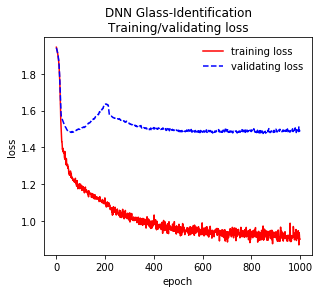

In [17]:
#----------------------------------------
# Summarize history for loss.

plt.figure('DNN Glass-Identification loss', figsize = (4.8, 4.0))
plt.plot(history.history['loss'], "r-")
plt.plot(history.history['val_loss'], "b--")
plt.title('DNN Glass-Identification' + '\n' + 'Training/validating loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validating loss'], loc = "best", frameon = False)
plt.show()


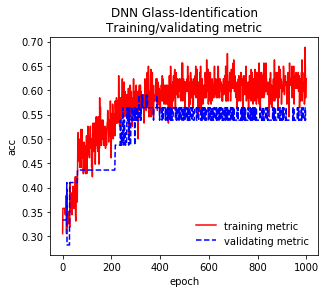

In [18]:
#----------------------------------------
# Summarize history for metric.

plt.figure('DNN Glass-Identification metric', figsize = (4.8, 4.0))
plt.plot(history.history['acc'], "r-")
plt.plot(history.history['val_acc'], "b--")
plt.title('DNN Glass-Identification' + '\n' + 'Training/validating metric')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['training metric', 'validating metric'], loc = "best", frameon = False)
plt.show()
